# Predicting movie sales from Metacritic data

## 0. Business problem

The movie industry faces high financial-performance risks because of increasingly high movie-making and marketing costs and a high degree of uncertainty about audience reactions (Escoffier et al., 2015).
While Metacritic provides rich information about movies such as the critic scores, user scores, review texts and metadata, it is 
unclear how well these features can predict the monetary success. That's why this project uses historical data from Metacritic and movie sales information information to build several machine learning models that forecast whether a movie will result in low, medium or high sales. Furthermore, this project will focus on explaining which features drive these predictions. 
The final goal is to provide the movie publisher with valuable information on where to spend the marketing budget.

**Business Question** How can we predict box office perfomance of the movie to accuratly allocate marketing budget?

**Source**:
Escoffier, N., & McKelvey, B. (2015). The Wisdom of Crowds in the Movie Industry: Towards New Solutions to Reduce Uncertainties. International Journal of Arts Management, 17(2), 52–63. http://www.jstor.org/stable/24587073

### 0.1 Main research question & subquestions
**Main research question**:
How accurately can we predict a movie's box-office sales using Metacritic ratings, metadata, review texts, with particular focus on identifying the most influential predictive factors?

**Subquestions**
1. How are critic scores, user scores, genres, platforms, and release years related to the sales tiers of movies?
2. How well can different machine learning models predict the sales tier of a movie, based on structured features?
3. To what extent does adding transformers of review titles and/or movie summaries improve prediction performance compared to models using only structured features? 
4. Which features are most influential in predicting high versus low sales according to SHAP?
5. Can we identify review topics and/or movie clusters (e.g., using BERTopic and clustering methods) that are particularly associated with high or low sales tiers, and do these insights reveal distinct market segments?

The movie sales prediction dataset is contained in the dataset folder in the repository. We will read the data and clean it to make it ready for analysis.

The following information is provided on the dataset variables selected to address the research questions:

This research employs a continuous numerical variable, **Worldwide Box Office**, as the response variable. This represents the total revenue generated globally (in USD).

This study reviewed the literature and used the following 10 variables as explanatory variables:

- **X1**: Metascore
  - A weighted average of critic reviews (Scale: 0 - 100).
- **X2**: Userscore
  - Average score provided by general users (Scale: 0 - 10).
- **X3**: Production Budget
  - The estimated financial cost to produce the film (USD).
- **X4**: Genre
  - Categorical variable indicating the primary classification of the movie (e.g., Action, Comedy, Drama).
  - Movies with multiple genres are processed using One-Hot Encoding.
- **X5**: Release Date
  - Used to extract the specific month and year of release to account for seasonal market trends and inflation adjustments.
- **X6**: Runtime
  - The duration of the movie in minutes.
- **X7**: Theatre Count
  - The number of theatres showing the movie during its opening weekend, serving as a proxy for distribution width.
- **X8**: MPAA Rating
  - Categorical certification defining the target audience scope:
    - G = General Audiences
    - PG = Parental Guidance Suggested
    - PG-13 = Parents Strongly Cautioned
    - R = Restricted
    - NC-17 = Adults Only
- **X9**: Movie Summary
  - The textual plot summary of the film.
  - Used to generate semantic embeddings via Transformers to capture narrative elements.
- **X10**: Review Text
  - The raw text body of expert and user reviews.
  - Used for BERTopic modeling to identify dominant discourse topics associated with sales performance.

## 1. EDA (exploratory data analysis)

### 1.1 Basic structure of the datasets

In [133]:
# Import all required libraries
import os
import re
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy.stats import skew, pearsonr, spearmanr
from scipy import stats

# Scikit-learn preprocessing
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD

# Transformer libraries
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import torch

# Progress bar
from tqdm.auto import tqdm

# Garbage collection for memory management
import gc

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [134]:
# define file paths relative to the notebook
data_folder = "datasets"

sales_path = os.path.join(data_folder, "sales.xlsx")
userreviews_path = os.path.join(data_folder, "UserReviews.xlsx")
expertreviews_path = os.path.join(data_folder, "ExpertReviews.xlsx")
meta_path = os.path.join(data_folder, "metaClean43Brightspace.xlsx")

In [135]:
# Load the four Excel files
UserReviews_raw = pd.read_excel(userreviews_path)
ExpertReviews_raw = pd.read_excel(expertreviews_path)
sales_raw       = pd.read_excel(sales_path)
meta_raw        = pd.read_excel(meta_path)

In [136]:
print("There are {} rows and {} columns in the user review dataset".format(UserReviews_raw.shape[0], UserReviews_raw.shape[1]))
print("There are {} rows and {} columns in the expert review dataset".format(ExpertReviews_raw.shape[0], ExpertReviews_raw.shape[1]))
print("There are {} rows and {} columns in the sales dataset".format(sales_raw.shape[0], sales_raw.shape[1]))
print("There are {} rows and {} columns in the meta dataset".format(meta_raw.shape[0], meta_raw.shape[1]))

There are 319662 rows and 7 columns in the user review dataset
There are 238973 rows and 5 columns in the expert review dataset
There are 30612 rows and 16 columns in the sales dataset
There are 11364 rows and 13 columns in the meta dataset


In [137]:
print("UserReview ")
UserReviews_raw.head()
UserReviews_raw.tail()
print("Expert Review")
ExpertReviews_raw.head()
ExpertReviews_raw.tail()
print("Meta data")
meta_raw.head()
meta_raw.tail()
print("Sales data")
sales_raw.head()
sales_raw.tail()


UserReview 
Expert Review
Meta data
Sales data


,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,Unnamed: 8,opening_weekend,theatre_count,avg run per theatre,runtime,keywords,creative_type,url
30607,2021,January 1st,Jokbeoldu sinmun iyagi,Documentary,12356.0,NaN,12356.0,NaN,NaN,NaN,NaN,NaN,168.0,NaN,Factual,https://www.the-numbers.com/movie/Jokbeoldu-si...
30608,2021,March 5th,My Salinger Year,Drama,914119.0,54730.0,968849.0,NaN,NaN,28851.0,123.0,2.0,101.0,Set in New York City,Contemporary Fiction,https://www.the-numbers.com/movie/My-Salinger-...
30609,2021,January 1st,Escort Vehicle 36,Action,240000.0,NaN,240000.0,NaN,NaN,NaN,NaN,NaN,85.0,NaN,Historical Fiction,https://www.the-numbers.com/movie/Escort-Vehic...
30610,2021,May 21st,The Dry,Thriller/Suspense,16987526.0,364397.0,17351923.0,NaN,NaN,119364.0,186.0,2.5,118.0,Crime Thriller,Contemporary Fiction,https://www.the-numbers.com/movie/Dry-The-(Aus...
30611,2021,January 1st,Posledniy bogatyr. KorenÃ¢â‚¬â„¢ Zla,Adventure,33396899.0,NaN,33396899.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Super Hero,https://www.the-numbers.com/movie/Posledniy-bo...


In [138]:
def print_basic_info(name, df):
    print(f"\n{name}")
    print("-" * len(name))
    print("Columns:", list(df.columns))
    print("\nMissing values per column:")
    display(df.isna().sum().sort_values(ascending=False).head(15))

print_basic_info("UserReviews_raw", UserReviews_raw)
print_basic_info("ExpertReviews_raw", ExpertReviews_raw)
print_basic_info("sales_raw", sales_raw)
print_basic_info("meta_raw", meta_raw)


UserReviews_raw
---------------
Columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'thumbsUp', 'thumbsTot']

Missing values per column:


thumbsUp     3580
thumbsTot    3576
dateP        3413
Rev          3413
reviewer     3407
idvscore     3404
url             0
dtype: int64


ExpertReviews_raw
-----------------
Columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev']

Missing values per column:


idvscore    2
reviewer    2
dateP       2
Rev         2
url         0
dtype: int64


sales_raw
---------
Columns: ['year', 'release_date', 'title', 'genre', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 'production_budget', 'Unnamed: 8', 'opening_weekend', 'theatre_count', 'avg run per theatre', 'runtime', 'keywords', 'creative_type', 'url']

Missing values per column:


Unnamed: 8                  30612
production_budget           26132
opening_weekend             19683
avg run per theatre         19660
theatre_count               19649
domestic_box_office         18728
keywords                    18095
international_box_office     9037
worldwide_box_office         9037
runtime                      6053
creative_type                3945
genre                        1704
title                           8
year                            0
release_date                    0
dtype: int64


meta_raw
--------
Columns: ['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director', 'genre', 'summary', 'awards', 'metascore', 'userscore', 'RelDate']

Missing values per column:


awards       6977
summary      5897
cast         3702
userscore    2105
rating       1067
studio        350
runtime       255
genre          20
director       14
url             0
title           0
metascore       0
RelDate         0
dtype: int64

In [139]:
def check_mixed_types(df, df_name):
    """
    Check for columns with mixed data types in a DataFrame.
    
    Args:
        df: The DataFrame to check
        df_name: Name of the DataFrame (for display purposes)
    """
    print(f"\n{'='*50}")
    print(f"Checking: {df_name}")
    print('='*50)
    
    found_mixed = False
    
    for col in df.columns:
        
        # Map type names to more readable versions
        # NaN values show as 'float', so we relabel them as 'NaN/missing'
        def get_type(x):
            if pd.isna(x):
                return 'NaN/missing'
            return type(x).__name__
        
        types = df[col].apply(get_type).value_counts().to_dict()
        
        # Only flag columns with actual mixed types (ignoring NaN)
        non_nan_types = {k: v for k, v in types.items() if k != 'NaN/missing'}
        
        if len(non_nan_types) > 1:
            found_mixed = True
            type_parts = [f"{count} {dtype}" for dtype, count in types.items()]
            print(f"  '{col}' has mixed types: {', '.join(type_parts)}")
    
    if not found_mixed:
        print("  No mixed types found - all columns are clean!")

check_mixed_types(UserReviews_raw, "UserReviews_raw")
check_mixed_types(ExpertReviews_raw, "ExpertReviews_raw")
check_mixed_types(sales_raw, "sales_raw")
check_mixed_types(meta_raw, "meta_raw")


Checking: UserReviews_raw
  'idvscore' has mixed types: 316253 int, 3404 NaN/missing, 5 str
  'thumbsUp' has mixed types: 316081 int, 3580 NaN/missing, 1 str
  'thumbsTot' has mixed types: 316080 int, 3576 NaN/missing, 6 str

Checking: ExpertReviews_raw
  No mixed types found - all columns are clean!

Checking: sales_raw
  'title' has mixed types: 30534 str, 52 int, 9 datetime, 8 NaN/missing, 6 time, 3 float
  'keywords' has mixed types: 18095 NaN/missing, 12509 str, 8 datetime

Checking: meta_raw
  No mixed types found - all columns are clean!


### Reflection on the raw datasets

Based on the first EDA and the 10 variables (X1-X10) identified for this research, we can see which problems exist in each table and what cleaning steps are needed.

#### Required Variables Overview

Our research focuses on 10 specific variables:
- **X1**: Metascore (from `meta_raw`)  
- **X2**: Userscore (from `meta_raw`)  
- **X3**: Production Budget (from `sales_raw`)  
- **X4**: Genre (from `meta_raw`)  
- **X5**: Release Date (from `meta_raw` or `sales_raw`)  
- **X6**: Runtime (from `meta_raw`)  
- **X7**: Theatre Count (from `sales_raw`)  
- **X8**: MPAA Rating (from `meta_raw`)  
- **X9**: Movie Summary (from `meta_raw`)  
- **X10**: Review Text (from `UserReviews_raw` and `ExpertReviews_raw`)  
- **Target**: Worldwide Box Office (from `sales_raw`)

#### meta_raw

- Shape: 11,364 rows and 13 columns. This is our primary movie-level metadata table.  
- **Critical columns for X1-X2, X4, X5-X6, X8-X9**:  
  - `metascore` (X1): No missing values, already numeric. This is our primary critic rating.  
  - `userscore` (X2): Contains some missing values, needs numeric conversion.  
  - `genre` (X4): Contains genre information, will need One-Hot Encoding for multiple genres.  
  - `RelDate` (X5): Already in clean date format, no missing values. Will extract month and year.  
  - `runtime` (X6): Contains movie duration in minutes, needs numeric cleaning.  
  - `rating` (X8): MPAA rating (G, PG, PG-13, R, NC-17), categorical variable.  
  - `summary` (X9): Plot summary text, many missing values but essential for semantic embeddings.  
  - `url`: No missing values, serves as our primary linking key.

Cleaning implications:
- Standardise `RelDate` into a single `releasedate` column using `standardize_meta_dates`.  
- Ensure `metascore`, `userscore` and `runtime` are properly numeric.  
- Keep `summary` text for later transformer-based embeddings, noting missing values.  
- Process `genre` for One-Hot Encoding.  
- Validate `rating` contains only valid MPAA categories.

#### sales_raw

- Shape: 30,612 rows and 16 columns. This contains our target variable and X3, X5, X7.  
- **Critical columns for X3, X5, X7 and target**:  
  - `worldwide_box_office`: Our target variable, comes as text and needs numeric conversion.  
  - `production_budget` (X3): Many missing values (~20,000), needs numeric conversion from text.  
  - `theatre_count` (X7): Distribution width proxy, many missing values, needs numeric conversion.  
  - `release_date` (X5): Free-form text date needs conversion to datetime for seasonal trends.  
  - `url`: No missing values, used for linking to meta table.  
- Column `Unnamed: 8` is completely empty and should be dropped.

Cleaning implications:
- Convert `worldwide_box_office`, `production_budget` and `theatre_count` to numeric using `get_numeric_value`.  
- Convert `release_date` to datetime via `clean_sales_dates`, with fallback on `year` where needed.  
- Handle missing values in budget and theatre count appropriately for modelling.  
- Drop irrelevant columns like `Unnamed: 8`.

#### UserReviews_raw & ExpertReviews_raw

- Combined shapes: 319,662 user reviews (7 columns) + 238,973 expert reviews (5 columns).  
- **Critical column for X10**:  
  - `Rev`: Review text body, essential for BERTopic modeling and identifying discourse topics.  
  - `url`: Links reviews to specific movies for aggregation.  
  - `dateP`: Review dates, though not in our X1-X10, useful for temporal analysis.  
- User reviews have ~3,400 missing values in reviewer and date fields.  
- Expert reviews have only 2 missing values across key fields.

Cleaning implications:
- Primary focus: ensure `Rev` text is preserved and linked to correct movies via `url`.  
- Convert dates to datetime format for consistency.  
- Clean reviewer names (replace missing with "Unknown Reviewer").  
- Create review IDs for tracking individual reviews.  
- Plan to aggregate reviews at movie level or use for BERTopic analysis.

#### Across all tables

- All tables have a `url` column with no missing values, making it our natural linking key.  
- However, URLs may have slight variations, so we need standardisation to create a consistent `movie_id`.  
- After cleaning, we'll have a movie-level dataset with all X1-X10 variables aligned.

Helper functions needed:
- `clean_movie_name` and `extract_title_from_url` to standardise movie identifiers.  
- `collect_all_movie_records`, `create_movie_dimension_table` and `add_movie_ids_to_datasets` to create a movie dimension table.  
- Data type conversion helpers for numeric fields (budget, scores, runtime, theatre count).  
- Date standardisation functions for release dates across tables.

After these cleaning steps, we'll have:
- A clean movie-level dataset with all 10 predictor variables (X1-X10) and the target (Worldwide Box Office).  
- Consistent date formats for temporal feature extraction (month, year).  
- Properly formatted numeric and categorical variables ready for One-Hot Encoding.  
- Review texts prepared for transformer embeddings and topic modeling.  
- All tables linkable via `movie_id` for seamless joins.


### 1.2 Data Cleaning Implementation

Now we implement the cleaning steps outlined in the reflection above. We'll create reusable helper functions following best practices from the tutorials.

#### 1: Extracting numeric values from strings

In [140]:
# Numeric conversion helper function
def get_numeric_value(value):
    # Handle missing values and text placeholders
    if pd.isna(value) or (isinstance(value, str) and value.strip().lower() in ['', 'n/a', 'na', 'none', 'tbd']):
        return np.nan
    # Already numeric - just convert to float
    if isinstance(value, (int, float)):
        return float(value)
    # Remove currency symbols, commas, spaces, percentages and convert
    try:
        return float(re.sub(r'[$,€£¥\s%]', '', str(value).strip()))
    except ValueError:
        return np.nan

# Apply to meta dataset (X1, X2, X6)
meta_clean = meta_raw.copy()
meta_clean[['metascore', 'userscore', 'runtime']] = meta_clean[['metascore', 'userscore', 'runtime']].applymap(get_numeric_value)

# Apply to sales dataset (target, X3, X7)
sales_clean = sales_raw.drop(columns=['Unnamed: 8'], errors='ignore')
sales_clean[['worldwide_box_office', 'production_budget', 'theatre_count']] = sales_clean[['worldwide_box_office', 'production_budget', 'theatre_count']].applymap(get_numeric_value)

# Apply to user reviews (not used in X1-X10 but cleaned for consistency)
UserReviews_clean = UserReviews_raw.copy()
UserReviews_clean['idvscore'] = UserReviews_clean['idvscore'].apply(get_numeric_value)

# Apply to expert reviews (not used in X1-X10 but cleaned for consistency)
ExpertReviews_clean = ExpertReviews_raw.copy()
ExpertReviews_clean['idvscore'] = ExpertReviews_clean['idvscore'].apply(get_numeric_value)

print(f"✓ Numeric cleaning complete: meta({len(meta_clean)}), sales({len(sales_clean)}), user({len(UserReviews_clean)}), expert({len(ExpertReviews_clean)})")

# Verification
print(f"Types: metascore={meta_clean['metascore'].dtype}, worldwide_box_office={sales_clean['worldwide_box_office'].dtype}")
print(f"Ranges: metascore[{meta_clean['metascore'].min():.0f}-{meta_clean['metascore'].max():.0f}], box_office[${sales_clean['worldwide_box_office'].min():,.0f}-${sales_clean['worldwide_box_office'].max():,.0f}]")
print(f"Missing: metascore={meta_clean['metascore'].isna().sum()}, production_budget={sales_clean['production_budget'].isna().sum()}, theatre_count={sales_clean['theatre_count'].isna().sum()}")

✓ Numeric cleaning complete: meta(11364), sales(30612), user(319662), expert(238973)
Types: metascore=float64, worldwide_box_office=float64
Ranges: metascore[1-100], box_office[$2-$2,845,899,541]
Missing: metascore=0, production_budget=26132, theatre_count=19649


#### 2: Date conversion

In [141]:
# Date conversion
def parse_date_vectorized(date_series, fallback_year_series=None):
    # Step 1: Remove ordinal suffixes from all dates at once (e.g., "January 1st" -> "January 1")
    cleaned = date_series.astype(str).str.replace(r'(\d+)(st|nd|rd|th)', r'\1', regex=True)
    
    # Step 2: Add fallback year to dates without a 4-digit year
    if fallback_year_series is not None:
        mask = ~cleaned.str.contains(r'\d{4}', na=False)  # Find dates without year
        cleaned = cleaned.where(~mask, cleaned + ', ' + fallback_year_series.astype(str))
    
    # Step 3: Convert to datetime, invalid dates become NaT
    return pd.to_datetime(cleaned, errors='coerce')

# Apply to meta dataset (X5) - RelDate already in clean format, just convert
meta_clean['releasedate'] = pd.to_datetime(meta_clean['RelDate'], errors='coerce')

# Apply to sales dataset (X5) - use 'year' column as fallback for incomplete dates
sales_clean['releasedate'] = parse_date_vectorized(sales_clean['release_date'], sales_clean['year'])

# Apply to review datasets - already in standard format, direct conversion
UserReviews_clean['dateP'] = pd.to_datetime(UserReviews_clean['dateP'], errors='coerce')
ExpertReviews_clean['dateP'] = pd.to_datetime(ExpertReviews_clean['dateP'], errors='coerce')

print(f" Date cleaning complete: all datasets have standardized datetime columns")

# Verification: check date ranges and missing values
print(f" Date ranges: meta[{meta_clean['releasedate'].min()} to {meta_clean['releasedate'].max()}], sales[{sales_clean['releasedate'].min()} to {sales_clean['releasedate'].max()}]")
print(f" Missing dates: meta={meta_clean['releasedate'].isna().sum()}, sales={sales_clean['releasedate'].isna().sum()}")

 Date cleaning complete: all datasets have standardized datetime columns
 Date ranges: meta[2000-01-01 00:00:00 to 2021-12-29 00:00:00], sales[2000-01-01 00:00:00 to 2021-12-31 00:00:00]
 Missing dates: meta=0, sales=46


#### 3. Movie linking

In [142]:
def clean_movie_name(text):
    """Make movie names consistent for matching across datasets."""
    if pd.isna(text) or text is None:
        return ""
    name = str(text).lower().strip().rstrip("/")
    name = name.rsplit("/", 1)[-1]  # take last part after slash (for URLs)
    name = name.replace("-", " ").replace("_", " ")
    # remove brackets content
    name = re.sub(r"\([^)]*\)|\[[^\]]*\]", "", name)
    # remove year at end
    name = re.sub(r"[\(\[]\s*(?:19|20)\d{2}[^)\]]*\s*[\)\]]\s*$|(?:19|20)\d{2}\s*$", "", name)
    # keep only letters, digits, spaces
    name = re.sub(r"[^a-z0-9\s\-']", "", name)
    # collapse spaces
    name = re.sub(r"\s+", " ", name).strip()
    return name

# Create cleaned names and movie_id for both datasets
meta_clean['cleaned_name'] = meta_clean['url'].apply(clean_movie_name)
meta_clean['movie_id'] = meta_clean['cleaned_name'].apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:12] if x else None)

sales_clean['cleaned_name'] = sales_clean['url'].apply(clean_movie_name)
sales_clean['movie_id'] = sales_clean['cleaned_name'].apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:12] if x else None)


# Check overlap
meta_ids = set(meta_clean['movie_id'].dropna())
sales_ids = set(sales_clean['movie_id'].dropna())
overlap = len(meta_ids.intersection(sales_ids))
print(f"✓ Overlapping movies: {overlap}")
print(f"  Meta unique: {len(meta_ids)}, Sales unique: {len(sales_ids)}")

# Merge datasets - using sales as main source with LEFT JOIN
# This keeps ALL movies from sales, even if they don't have metadata
movie_data = sales_clean.merge(meta_clean, on='movie_id', how='left', suffixes=('_sales', '_meta'))
print(f"✓ Merged dataset: {len(movie_data)} movies (all from sales dataset)")
print(f"  Movies with metadata: {movie_data['metascore'].notna().sum()}")
print(f"  Movies without metadata: {movie_data['metascore'].isna().sum()}")

✓ Overlapping movies: 6795
  Meta unique: 11125, Sales unique: 29910
✓ Merged dataset: 31078 movies (all from sales dataset)
  Movies with metadata: 7652
  Movies without metadata: 23426


In [143]:
# Since sales is now the base table, we need to handle column selection differently
# Columns from sales (base) don't have suffixes
# Columns from meta have _meta suffix
# For overlapping columns (genre, runtime, releasedate), prefer meta version when available, otherwise use sales

# First, let's create consolidated columns for the overlapping fields
# For genre: prefer meta (more complete), fallback to sales
movie_data['genre'] = movie_data['genre_meta'].fillna(movie_data['genre_sales'])

# For releasedate: prefer sales (already cleaned), fallback to meta
movie_data['releasedate'] = movie_data['releasedate_sales'].fillna(movie_data['releasedate_meta'])

# For runtime: prefer meta (more accurate), fallback to sales
movie_data['runtime'] = movie_data['runtime_meta'].fillna(movie_data['runtime_sales'])

# Now select final columns
movie_data = movie_data[[
    'movie_id',
    'metascore',              # X1 (from meta)
    'userscore',              # X2 (from meta)
    'production_budget',      # X3 (from sales, no suffix)
    'genre',                  # X4 (consolidated)
    'releasedate',            # X5 (consolidated)
    'runtime',                # X6 (consolidated)
    'theatre_count',          # X7 (from sales, no suffix)
    'rating',                 # X8 (from meta)
    'summary',                # X9 (from meta)
    'worldwide_box_office'    # Target (from sales, no suffix)
    # X10 (review text) will be aggregated separately
]]

# Remove movies with missing movie_id (mostly year-only titles that can't be matched)
print(f"Removing {movie_data['movie_id'].isna().sum()} movies with missing movie_id...")
movie_data = movie_data[movie_data['movie_id'].notna()].copy()

print(f"✓ Movie-level dataset: {len(movie_data)} movies with X1-X9 + target")
print(f"\n✓ Missing values:")
print(movie_data.isnull().sum())
print(f"\n✓ Complete cases (no missing values): {movie_data.dropna().shape[0]} movies")


Removing 171 movies with missing movie_id...
✓ Movie-level dataset: 30907 movies with X1-X9 + target

✓ Missing values:
movie_id                    0
metascore               23426
userscore               24648
production_budget       26316
genre                    1378
releasedate                37
runtime                  4656
theatre_count           19715
rating                  23979
summary                 27235
worldwide_box_office     9123
dtype: int64

✓ Complete cases (no missing values): 1325 movies


In [144]:
# Filter to only movies with box office data (target variable)
movie_data_with_target = movie_data[movie_data['worldwide_box_office'].notna()].copy()
print(f"✓ Movies with box office data: {len(movie_data_with_target)}")

# Now add movie_id to review datasets
UserReviews_clean['cleaned_name'] = UserReviews_clean['url'].apply(clean_movie_name)
UserReviews_clean['movie_id'] = UserReviews_clean['cleaned_name'].apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:12] if x else None)

ExpertReviews_clean['cleaned_name'] = ExpertReviews_clean['url'].apply(clean_movie_name)
ExpertReviews_clean['movie_id'] = ExpertReviews_clean['cleaned_name'].apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:12] if x else None)

print(f"✓ Added movie_id to reviews")

# Aggregate review texts
user_reviews_agg = UserReviews_clean.groupby('movie_id')['Rev'].apply(lambda x: ' '.join(x.dropna().astype(str))).reset_index()
user_reviews_agg.columns = ['movie_id', 'user_review_text']

expert_reviews_agg = ExpertReviews_clean.groupby('movie_id')['Rev'].apply(lambda x: ' '.join(x.dropna().astype(str))).reset_index()
expert_reviews_agg.columns = ['movie_id', 'expert_review_text']

# Merge everything
movie_data_complete = movie_data_with_target.merge(user_reviews_agg, on='movie_id', how='left')
movie_data_complete = movie_data_complete.merge(expert_reviews_agg, on='movie_id', how='left')

movie_data_complete['review_text'] = (
    movie_data_complete['user_review_text'].fillna('') + ' ' + 
    movie_data_complete['expert_review_text'].fillna('')
).str.strip()

movie_data_complete['release_month'] = movie_data_complete['releasedate'].dt.month
movie_data_complete['release_year'] = movie_data_complete['releasedate'].dt.year

print(f"✓ Final dataset: {len(movie_data_complete)} movies with all X1-X10 variables")

✓ Movies with box office data: 21784
✓ Added movie_id to reviews
✓ Final dataset: 21784 movies with all X1-X10 variables


In [145]:
movie_data.head()

,movie_id,metascore,userscore,production_budget,genre,releasedate,runtime,theatre_count,rating,summary,worldwide_box_office
0,6305dc82622a,NaN,NaN,NaN,Drama,2000-01-01,129.0,NaN,NaN,NaN,76576.0
1,662bc1e3cf57,31.0,8.7,30000000.0,"Drama,Thriller",2001-01-12,109.0,2433.0,| PG-13,A relentless suspense thriller that enters the...,17865209.0
2,34d63fdb450f,68.0,NaN,NaN,"Drama,Comedy",2000-01-28,105.0,NaN,| R,Alejandro Springall directs this Spanish-langu...,NaN
3,126e558a78b1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,dfc233d7a2f9,NaN,NaN,11000000.0,Drama,2002-01-25,NaN,2411.0,NaN,NaN,46060861.0


In [146]:
movie_data_complete.head()

,movie_id,metascore,userscore,production_budget,genre,releasedate,runtime,theatre_count,rating,summary,worldwide_box_office,user_review_text,expert_review_text,review_text,release_month,release_year
0,6305dc82622a,NaN,NaN,NaN,Drama,2000-01-01,129.0,NaN,NaN,NaN,76576.0,NaN,NaN,,1.0,2000.0
1,662bc1e3cf57,31.0,8.7,30000000.0,"Drama,Thriller",2001-01-12,109.0,2433.0,| PG-13,A relentless suspense thriller that enters the...,17865209.0,'Always liked this flick.\rIs it the best mov...,"'Becomes a very conventional suspense film, r...",'Always liked this flick.\rIs it the best movi...,1.0,2001.0
2,dfc233d7a2f9,NaN,NaN,11000000.0,Drama,2002-01-25,NaN,2411.0,NaN,NaN,46060861.0,NaN,NaN,,1.0,2002.0
3,ed1dd3e75880,41.0,6.4,22000000.0,"Thriller,Comedy,Romance,Crime",2008-01-18,104.0,2470.0,| PG-13,NaN,25044057.0,'I had to write this after reading Conrad B. ...,"'Latifah coasts on grit and verve, and Holmes...",'I had to write this after reading Conrad B. s...,1.0,2008.0
4,8e3d5b8714f4,30.0,5.1,10000000.0,"Fantasy,Comedy,Romance",2008-02-01,95.0,1977.0,| PG-13,NaN,21596074.0,'Girlfriend took me and thought i d hate it. ...,'This madcap paranormal love triangle is char...,'Girlfriend took me and thought i d hate it. A...,2.0,2008.0


In [147]:
# again show the information on the the movie_data_complete dataframe

print(f"✓ Movie-level dataset: {len(movie_data_complete)} movies with X1-X9 + target")
print(f"\n✓ Missing values:")
print(movie_data_complete.isnull().sum())
print(f"\n✓ Complete cases (no missing values): {movie_data_complete.dropna().shape[0]} movies")

✓ Movie-level dataset: 21784 movies with X1-X9 + target

✓ Missing values:
movie_id                    0
metascore               16983
userscore               17298
production_budget       17780
genre                     804
releasedate                14
runtime                  2685
theatre_count           15026
rating                  17119
summary                 19524
worldwide_box_office        0
user_review_text        16983
expert_review_text      16983
review_text                 0
release_month              14
release_year               14
dtype: int64

✓ Complete cases (no missing values): 1325 movies


In [148]:
import seaborn as sns
import matplotlib.pyplot as plt #for creating more graphical illustrations

In [149]:
#Create a fresh dataframe so the movie data is not fragmented and we dont get that warning
movie_data_complete = movie_data_complete.copy()

In [150]:
def EDA_plots(df, column, target='worldwide_box_office'):
    """
    EDA for a single numeric feature (because this is NOT a classifaction problem, but a (linear) regression problem).

    Plots:
    1. Histogram of the feature
    2. Boxplot of the feature
    3. KDE distribution of the feature
    4. Scatterplot: feature vs target (e.g. worldwide_box_office)

    Parameters:
    df      : DataFrame
    column  : Name of the feature to analyze
    target  : Target column (default: 'worldwide_box_office')
    """

    # Skip non-numeric columns to avoid seaborn errors
    #if not pd.api.types.is_numeric_dtype(df[column]):
     #   print(f"Skipping '{column}': not numeric")
     #   return

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    plt.suptitle(f"EDA for: {column}", fontsize=16)

    # 1. Histogram
    sns.histplot(df[column], bins=30, ax=axes[0, 0])
    axes[0, 0].set_title("Histogram")

    # 2. Boxplot
    sns.boxplot(x=df[column], ax=axes[0, 1])
    axes[0, 1].set_title("Boxplot")

    # 3. KDE distribution
    sns.kdeplot(df[column], ax=axes[1, 0])
    axes[1, 0].set_title("KDE Distribution")

    # 4. Relationship with target (scatterplot)
    if target in df.columns and pd.api.types.is_numeric_dtype(df[target]):
        sns.scatterplot(
            x=df[column],
            y=df[target],
            ax=axes[1, 1],
            s=10,
            alpha=0.4
        )
        axes[1, 1].set_title(f"{column} vs {target}")
    else:
        axes[1, 1].axis("off")
        axes[1, 1].set_title("No numeric target column found")

    plt.tight_layout()
    plt.show()


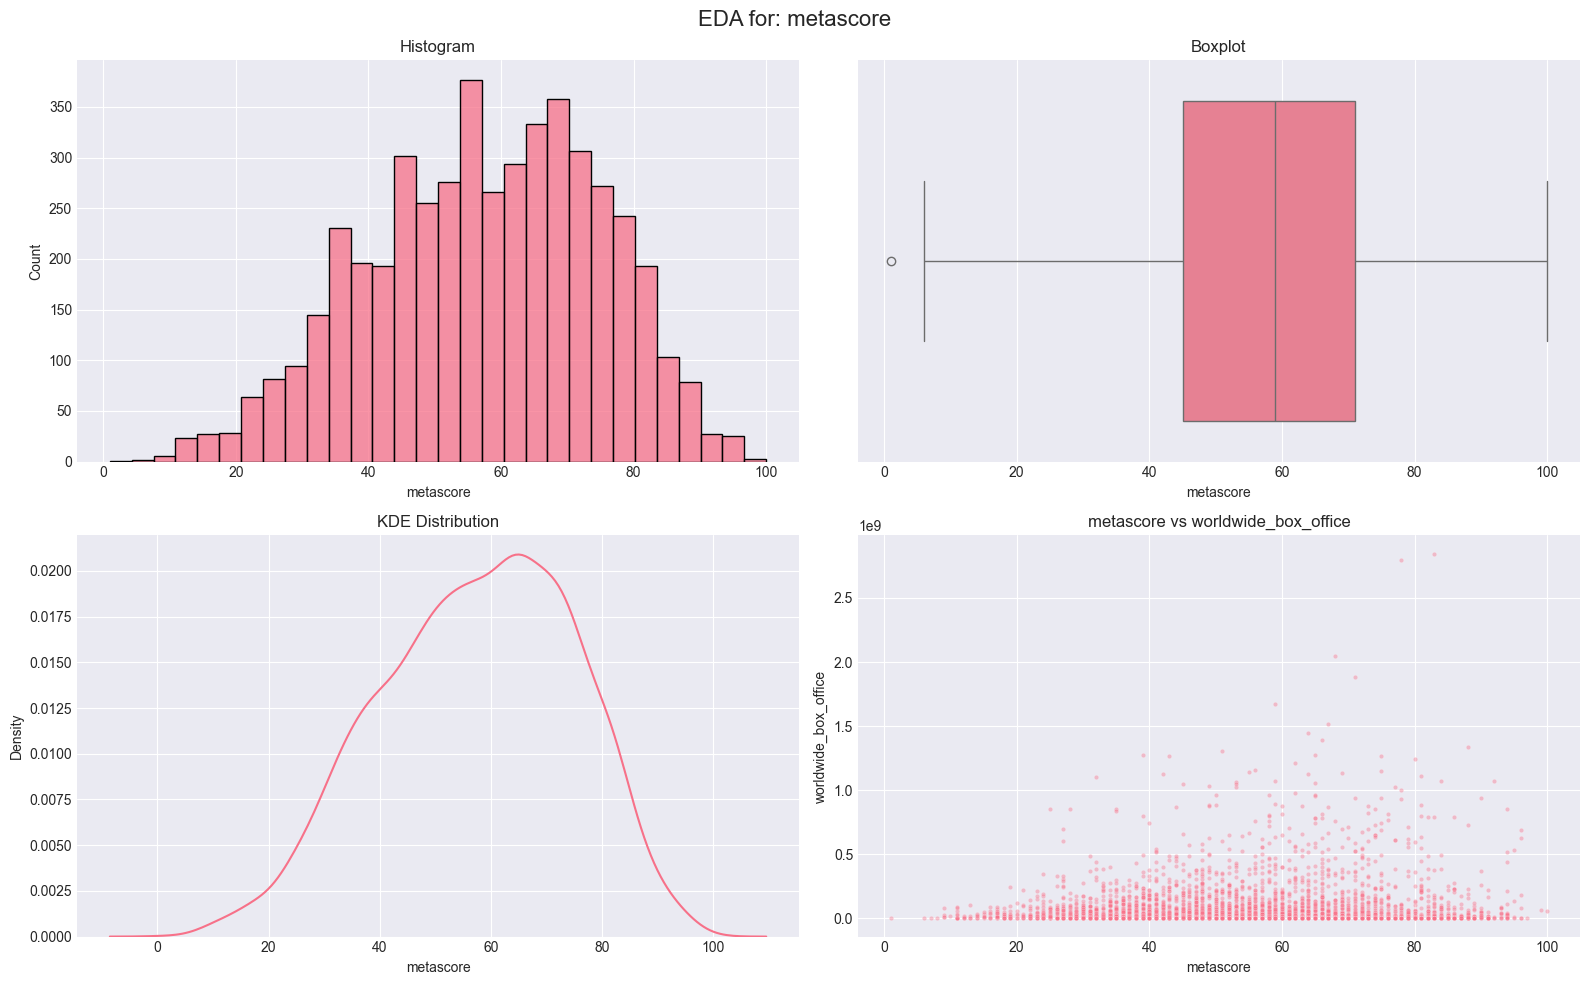

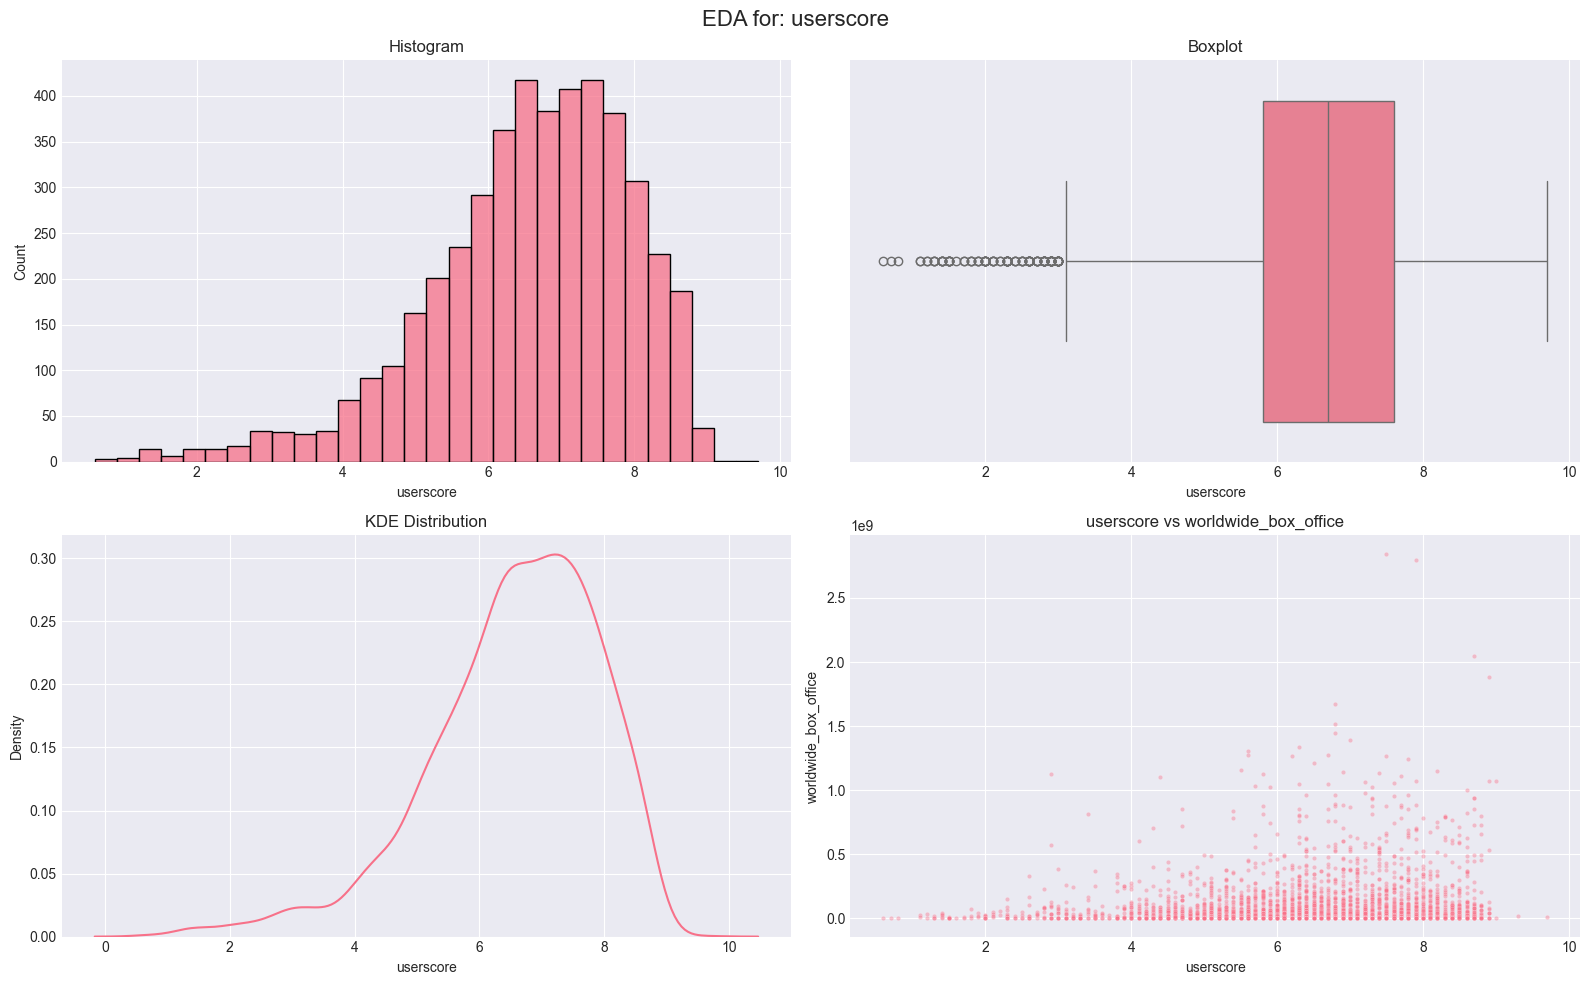

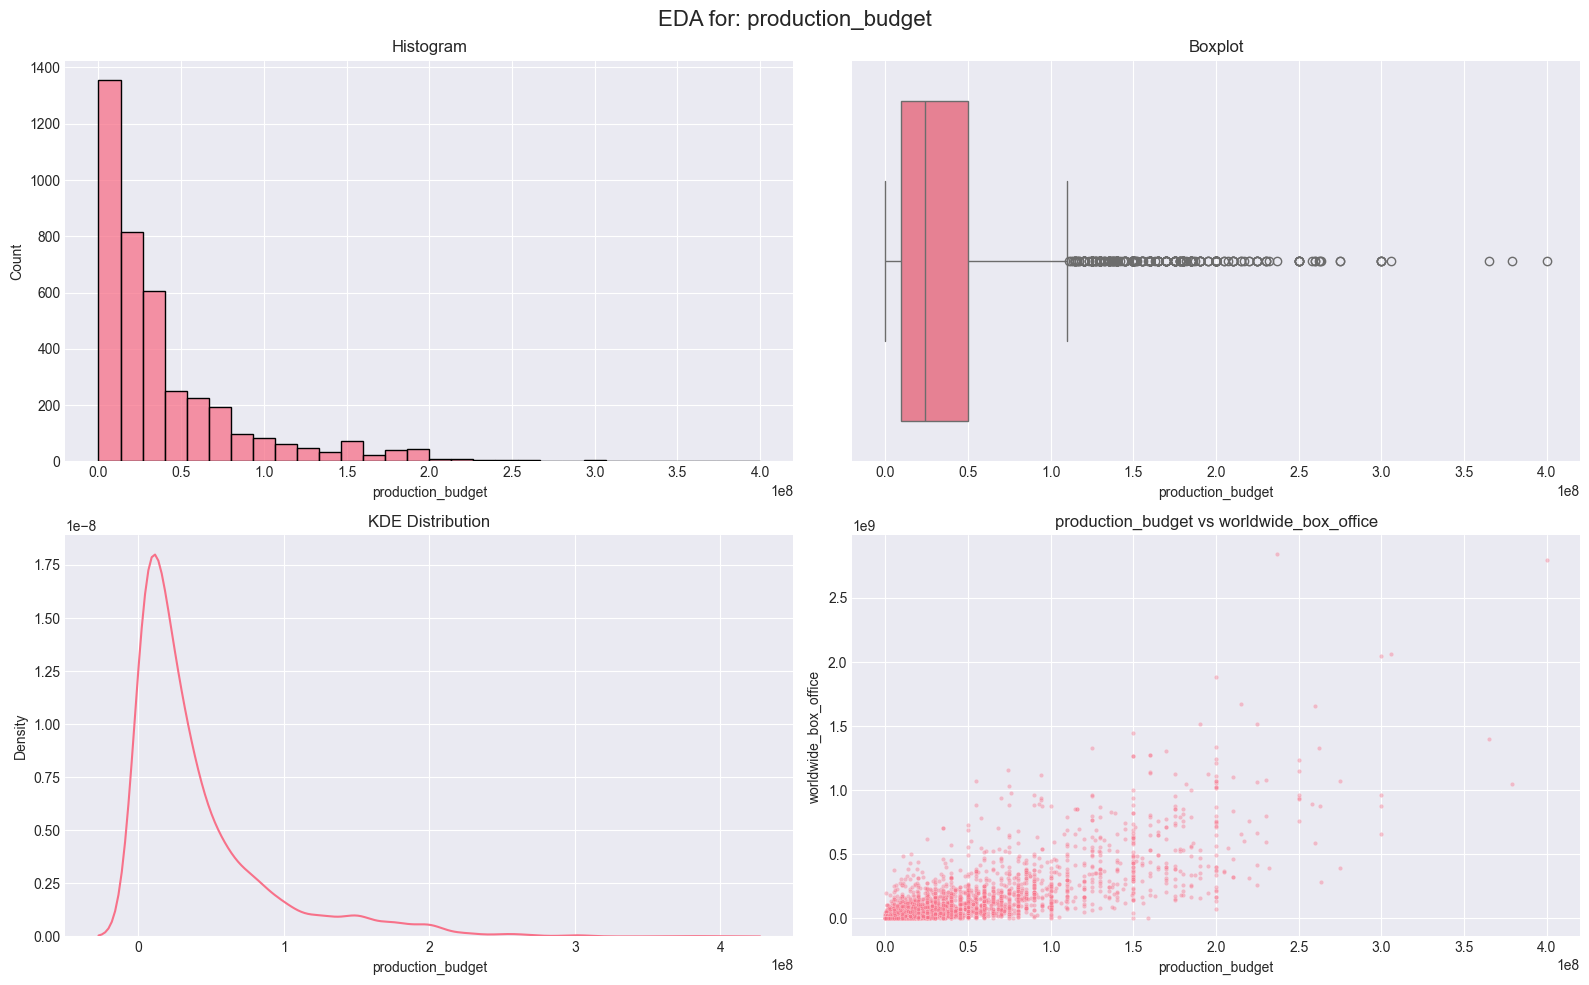

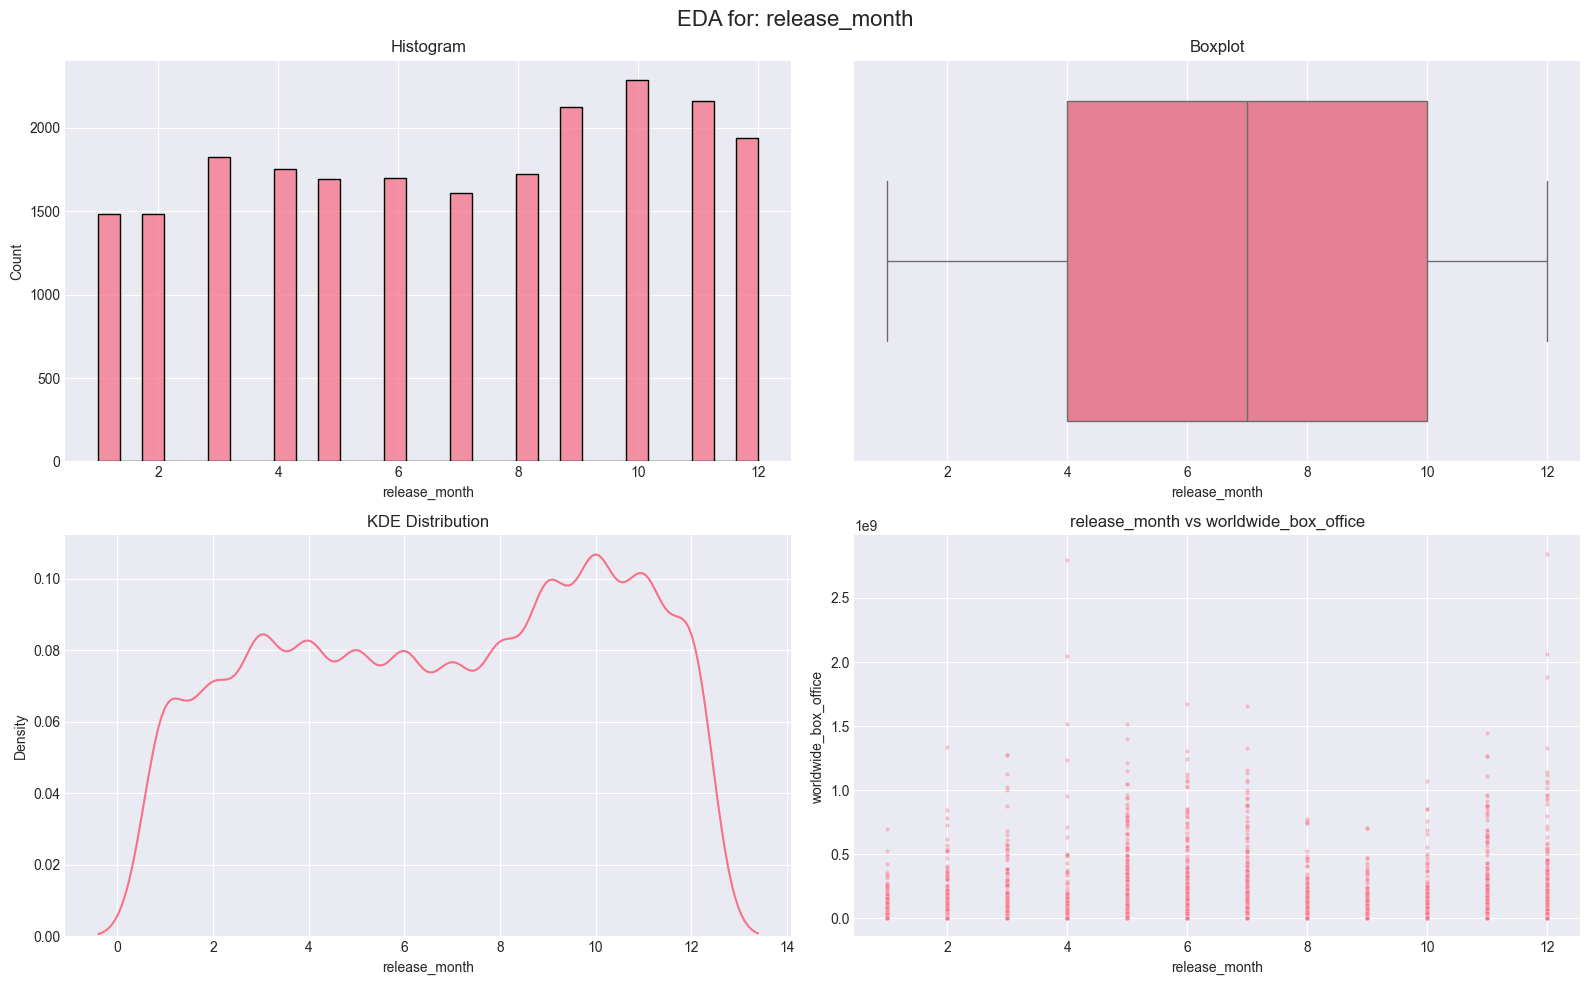

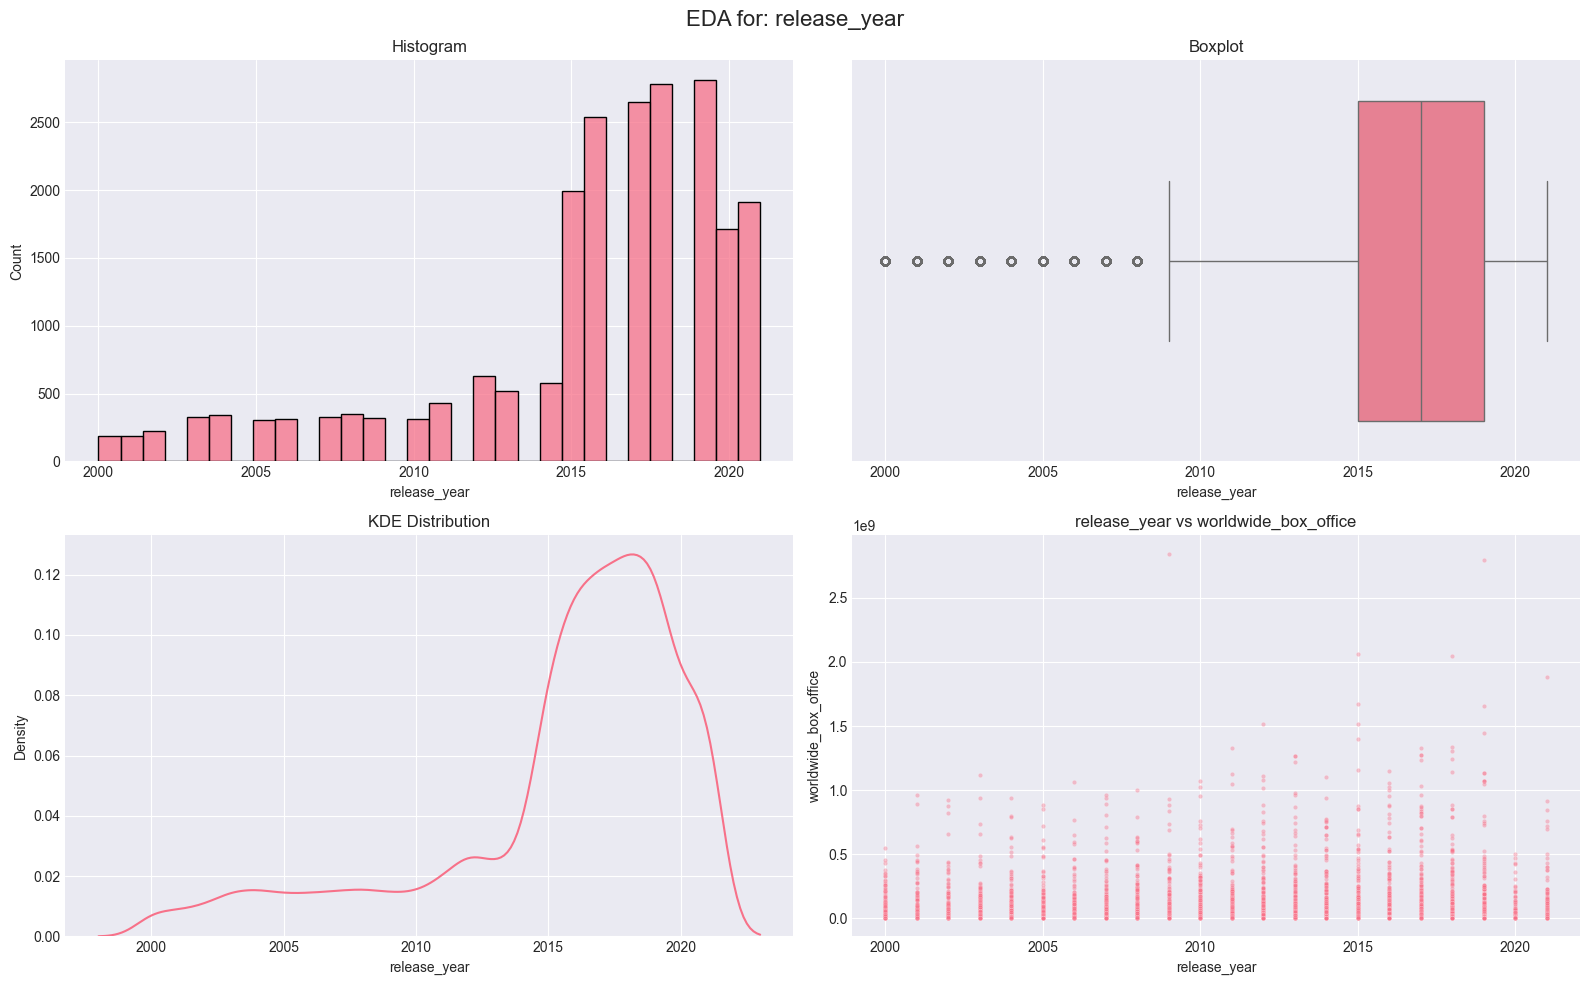

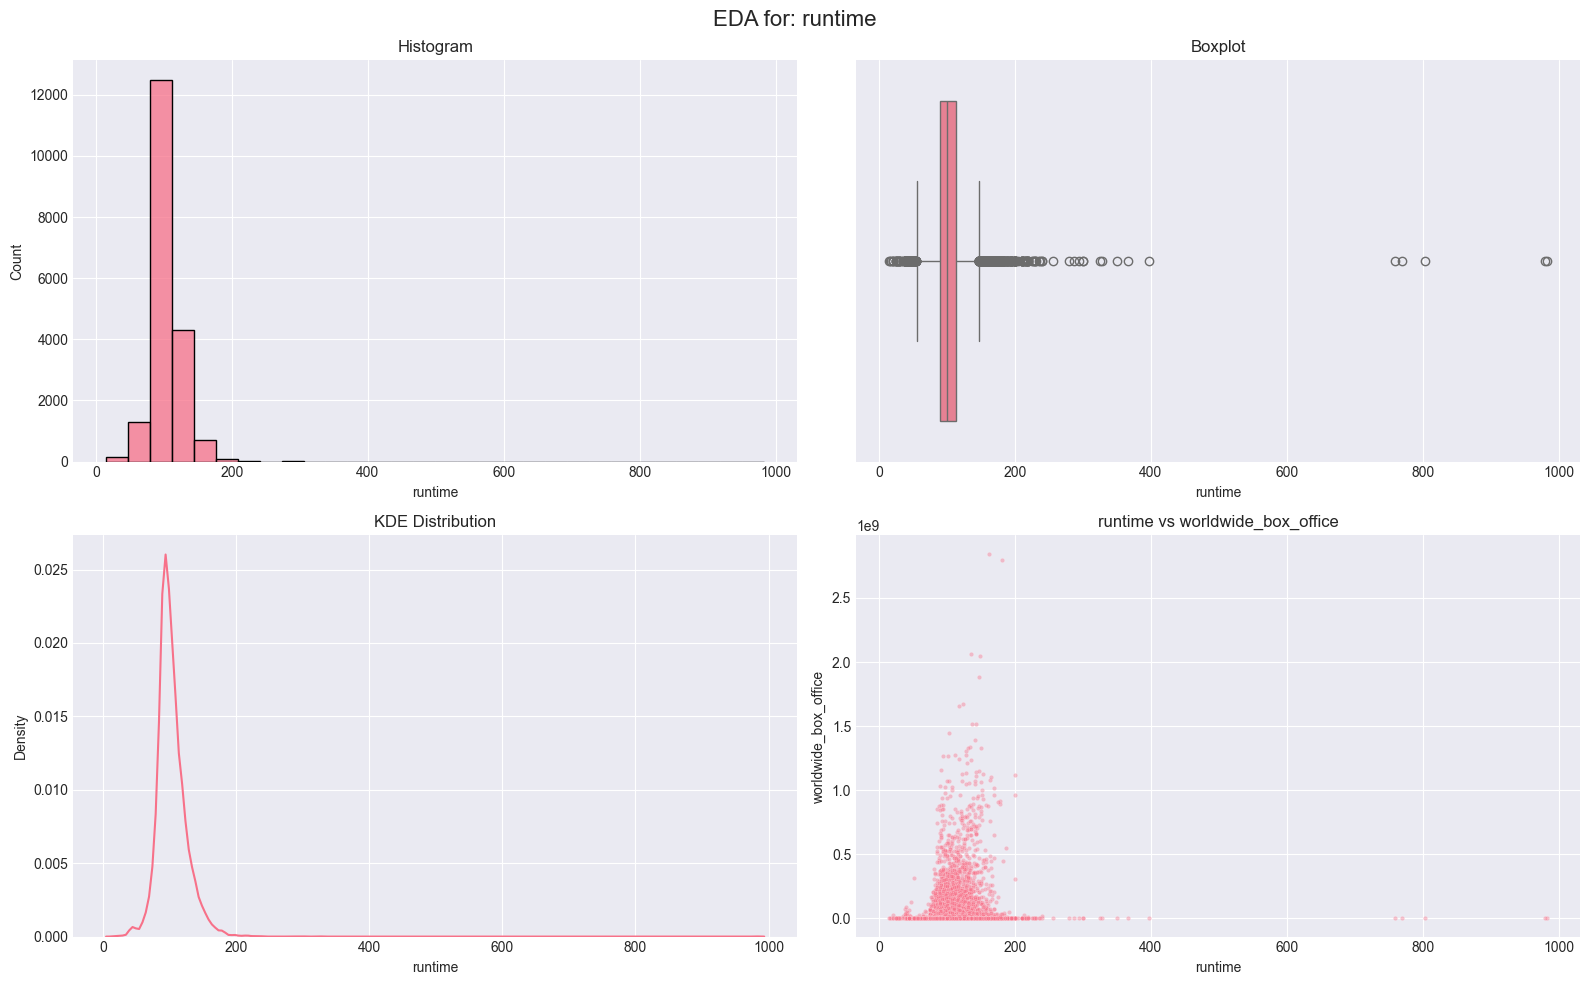

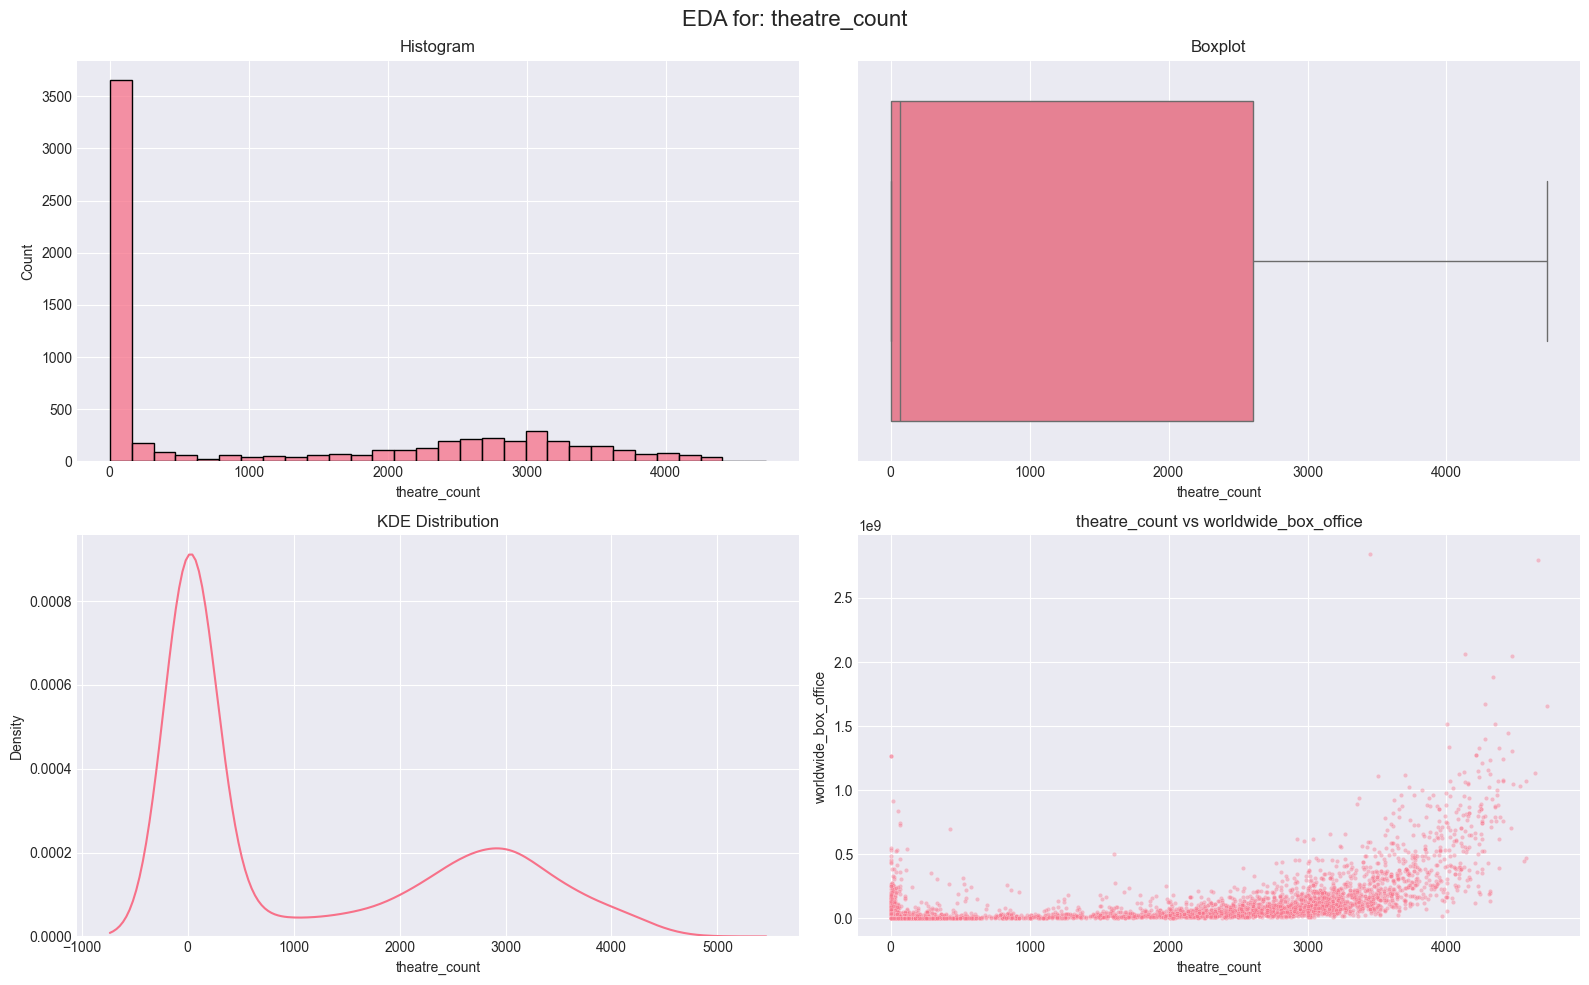

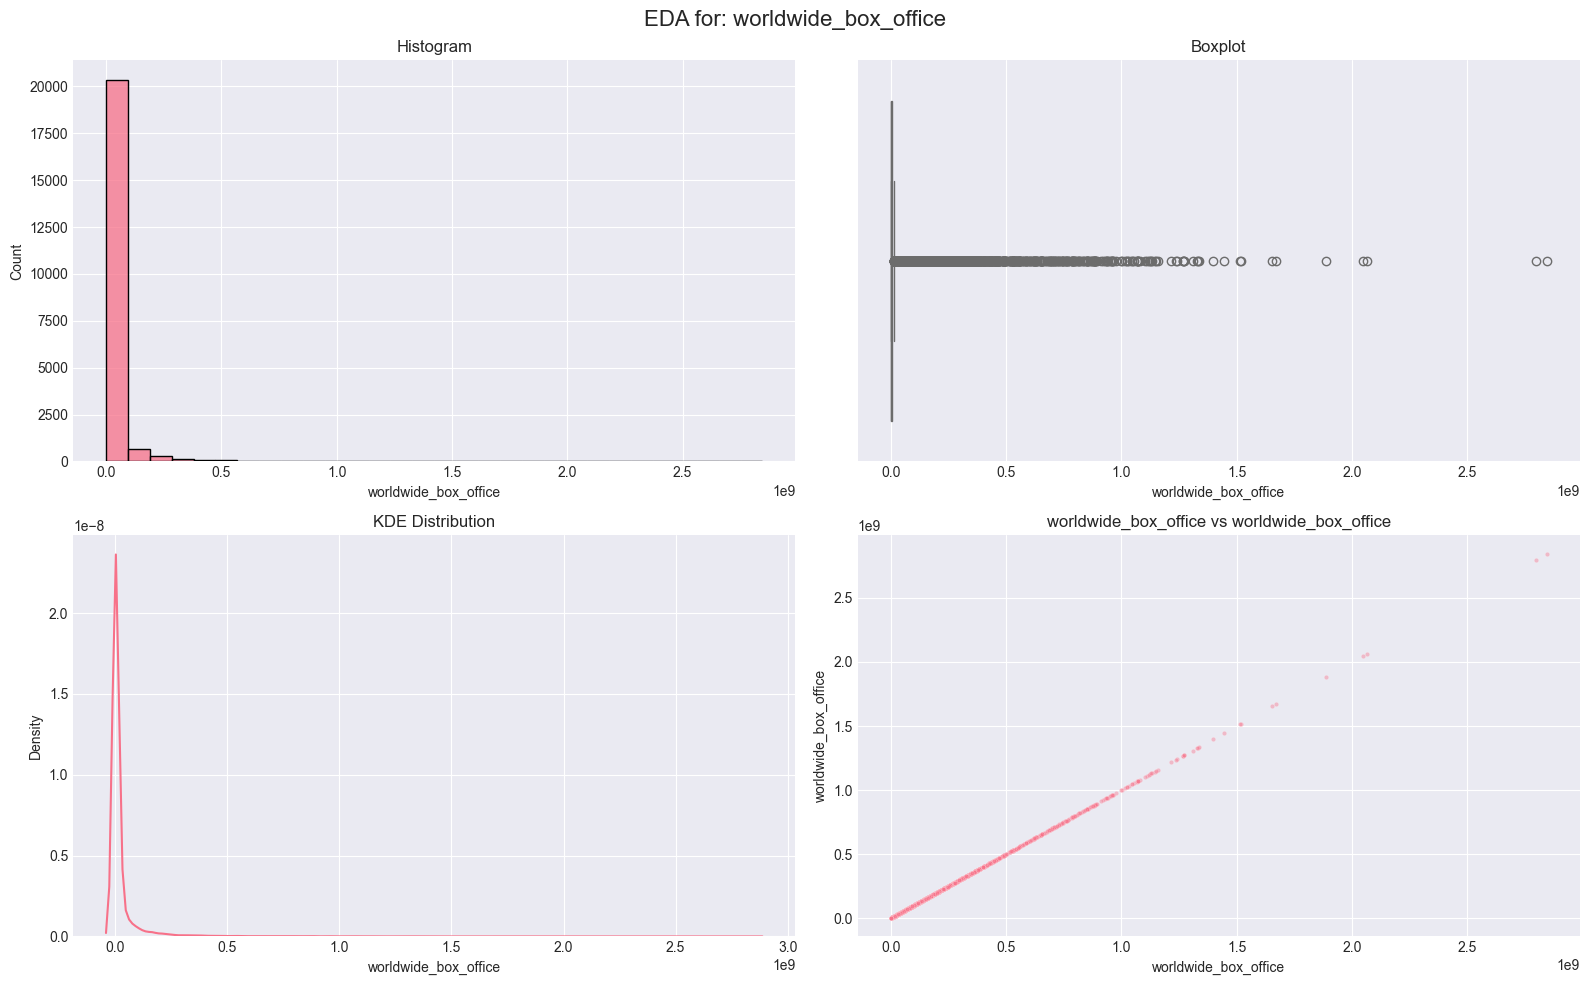

In [151]:
#create a dataframe with a placeholder for all the created column in the customer_final dataframe. 
df_EDA_features= [
    'metascore',
    'userscore',
    'production_budget',
    'release_month',
    'release_year',
    'runtime',
    'theatre_count',
    'worldwide_box_office'       
]

for col in df_EDA_features:
    EDA_plots(movie_data_complete, col, target='worldwide_box_office')


### Reflection on the EDA plots per feature

- **Metascore**: This feature shows an almost normal distribution, centered around 50-70. There is only one outlier and the scatterplot shows no strong linear relationship between the worldwide box office and metascore. This means that the score of the critics alone is NOT a strong predictor of the box office performance

- **Userscore**: This feature shows a right skewed distribution, with most movies receiving an 5 - 8. The boxplot shows some outliers around the 1, these could be people that did not rate the movie honestly. The scatterplot shows that popular movies can have high box office results, but most of them do not. Meaning that userscore alone is also not a strong predictor of box office performance. 

- **Production_budget**: This features showes a heavily left skewed distribution in which most movies have a production budget of less then 50000000. However, the boxplot showes that there are also movies that have budgets as high as 400,000,000. Interestingly, the scatterplot does show a positive linear relationship. Although not every movie with high production budget succeeds, most of them do! 

- **Release_month**: The release month is evenly distributed, with some months showing small dips. The scatterplots show some small peaks in the summer and winter. It is not a very strong predictor by itself, but could be useful after one hot encoding in the future.

- **Release_year**: The released year show very expected behaviour. More movies have been released in more recent years and the movies tend to earn more in recent years. This is probably due to inflation and general market growth.

- **Runtime**: The distribution shows that most movies have a runtime of around 100-150 minutes. There is no clear relationship between runtime and box office performance based on the scatterplot. This is a weak predictor by itself.

- **Theatre_count**: This distribution is extremely skewed. Most movies open in very few theatres, but a few movies open in way more theatres. These will probably be blockbuster movies. The scatterplot however shows a very strong positive relationship between the amount of theatres and the worldwide box office. It is also seen that as soon as a movie is showed in more then 4000 theatres, it almost always means more revenue. This feature might need a log transform to handle the skeweness but it will be a very strong predictor.

- **Worldwide_box_office**: The target shows a heaviliy left skewed distribution. Meaning that most movies make a few million and some movies make billions. 


### 1.4 Inferential statistics
In this chapter, we will move from descriptive statistics to inferential statistics. The numerical features (X1, X2, X3, X6, X7) will be examined with Pearson and Spearmon correlation testing. The categorical features (X4, X5, X8) will be examined with either ANOVA or Kruskal wallis depending on the characterics. 

### Assummptions reflection: 
- Pearson correlation assumptions:
    1. The relationship between the variables is linear
    2. The data is normaly distributed
    3. The data is on a continuous scale
    4. There should be no extreme outliers 

- **X1**: Metascore does not violate any assumptions. Although the scatterplot does not show strong linearity, is does show some. 
- **X2**: Userscore **does** violate assumptions. There are some outliers at the 1, and the distribution is right skewed. Therefore, this is not a good fit for the pearson   correlation test
- **X3**: Altough production budget shows linearity, there are extreme outliers and the data is highly left skewed. Therefore it **does** violate assumptions
- **X4**: Genre is not a numerical feature, does not fit pearson
- **X5**: Release date is not a numerical feature, does not fit pearson 
- **X6**: Runtime shows a weak linearity and a right skewed distribution and **does** violate the assumptions
- **X7**: Theatre count **does** violate the assumption due to the extreme skew.
- **X8**: MPAA Rating is not a numerical feature, does not fit pearson
- **X9**: Movie Summary is not a numerical feature, does not fit pearson
- **X10**: Review Text is not a numerical feature, does not fit pearson

Conclusion: the only feature suited for pearson correlation is metascore. However, the target feature violates the assumptions as well. Since pearson correlation is a bivariate test, Pearson is not suited at all. To find correlation but mitigate these violations, Spearman rank correlation is used.



#### 1.4.1: Correlation analysis


Spearman Correlation Matrix:
                      metascore  userscore  production_budget  runtime  \
metascore                 1.000      0.510             -0.136    0.114   
userscore                 0.510      1.000             -0.057    0.147   
production_budget        -0.136     -0.057              1.000    0.322   
runtime                   0.114      0.147              0.322    1.000   
theatre_count            -0.403     -0.174              0.734    0.111   
release_year              0.116     -0.181              0.010   -0.105   
worldwide_box_office     -0.167      0.029              0.744    0.270   

                      theatre_count  release_year  worldwide_box_office  
metascore                    -0.403         0.116                -0.167  
userscore                    -0.174        -0.181                 0.029  
production_budget             0.734         0.010                 0.744  
runtime                       0.111        -0.105                 0.270  
theatre_

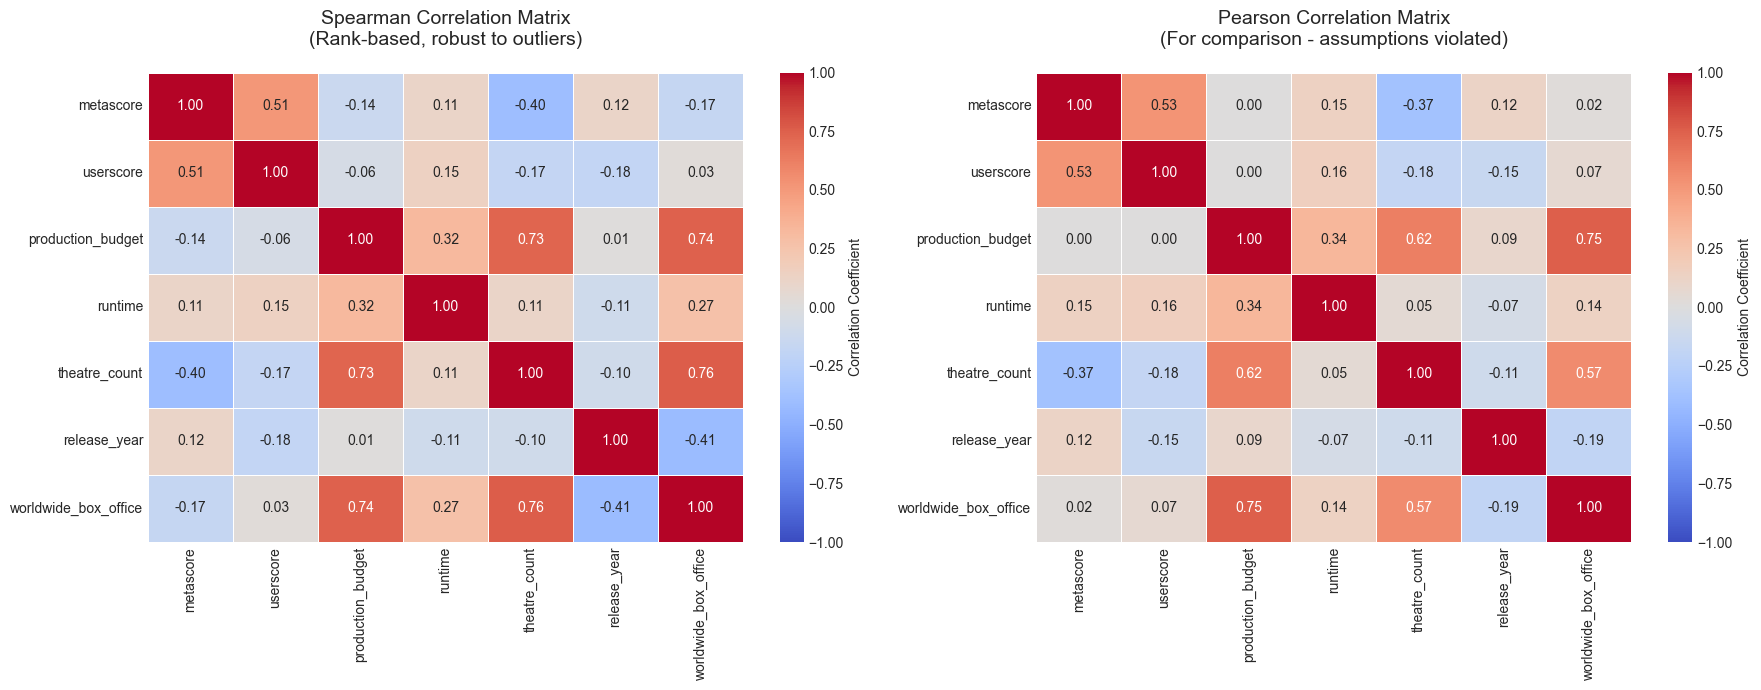


Statistical Significance Tests (Spearman) for correlations with target:
metascore                : ρ = -0.167, p = 2.1917e-31 ***
userscore                : ρ =  0.029, p = 5.5477e-02 ns
production_budget        : ρ =  0.744, p = 0.0000e+00 ***
runtime                  : ρ =  0.270, p = 0.0000e+00 ***
theatre_count            : ρ =  0.759, p = 0.0000e+00 ***
release_year             : ρ = -0.414, p = 0.0000e+00 ***

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


In [152]:
# 1. Correlation analysis for continuous data
# Based on our assumptions reflection, we use Spearman correlation due to:
# - Non-normal distributions (skewed data)
# - Presence of outliers
# - Non-linear relationships

# Select all continuous features and the target variable
scale_features = [
    'metascore',              # X1
    'userscore',              # X2
    'production_budget',      # X3
    'runtime',                # X6
    'theatre_count',          # X7
    'release_year',           # from X5
    'worldwide_box_office'    # Target
]

# Calculate Spearman correlation (rank-based, robust to outliers and non-linearity)
spearman_corr = movie_data_complete[scale_features].corr(method='spearman')

print("Spearman Correlation Matrix:")
print("=" * 80)
print(spearman_corr.round(3))
print("\n")

# Focus on correlations with target variable
print("Spearman Correlations with Worldwide Box Office:")
print("=" * 80)
target_corr = spearman_corr['worldwide_box_office'].sort_values(ascending=False)
print(target_corr)

# Visualize with heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Spearman correlation heatmap
sns.heatmap(
    spearman_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    ax=axes[0],
    cbar_kws={'label': 'Correlation Coefficient'}
)
axes[0].set_title('Spearman Correlation Matrix\n(Rank-based, robust to outliers)', fontsize=14, pad=20)

# For comparison, also show Pearson (even though assumptions are violated)
pearson_corr = movie_data_complete[scale_features].corr(method='pearson')
sns.heatmap(
    pearson_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    ax=axes[1],
    cbar_kws={'label': 'Correlation Coefficient'}
)
axes[1].set_title('Pearson Correlation Matrix\n(For comparison - assumptions violated)', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

# Statistical significance testing for key correlations with target
print("\n" + "=" * 80)
print("Statistical Significance Tests (Spearman) for correlations with target:")
print("=" * 80)

from scipy.stats import spearmanr

for feature in scale_features:
    if feature != 'worldwide_box_office':
        # Remove NaN values for the pair
        valid_data = movie_data_complete[[feature, 'worldwide_box_office']].dropna()
        
        if len(valid_data) > 0:
            corr, p_value = spearmanr(valid_data[feature], valid_data['worldwide_box_office'])
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            print(f"{feature:25s}: ρ = {corr:6.3f}, p = {p_value:.4e} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

### Reflection: correlation analysis results

**Key findings from spearman correlation:**

The Spearman correlation analysis reveals which features have the strongest relationship with worldwide box office performance. We used Spearman instead of Pearson because most features violate normality and linearity assumptions (see section 1.4 assumptions reflection).

**Strong Predictors (|r| > 0.7):**
- **Theatre_count** (r = 0.76): The strongest predictor by far. Movies opening in more theatres almost always earn more. This makes sense - studios give wide releases to films they expect to succeed, and wider distribution directly increases revenue potential. However, this feature has **data leakage** concerns since theatre count is determined AFTER observing early performance, not before release.
- **Production_budget** (r = 0.74): Second strongest predictor. High-budget films tend to earn more, likely because expensive productions afford better talent, marketing, and visual effects. The relationship isn't perfect though - some expensive films flop while low-budget films occasionally break out.

**Moderate Predictors (0.2 < |r| < 0.5):**
- **Runtime** (r = 0.27): Longer movies slightly correlate with higher earnings. This could reflect that blockbusters and epics tend to run longer, or that audiences perceive longer films as more "event-worthy."
- **Release_year** (r = -0.41): Negative correlation is unexpected but explainable. The dataset spans multiple years with varying data quality. Older movies in the dataset might be biased toward classics and hits (survivorship bias), while recent years include all releases regardless of success. The negative sign doesn't mean recent movies earn less - it's likely a data collection artifact.

**Weak Predictors (|r| < 0.2):**
- **Userscore** (r = 0.03): Essentially no correlation. User ratings don't predict box office performance, confirming what the EDA scatter plot showed - popular movies can bomb and unpopular movies can succeed.
- **Metascore** (r = -0.17): Weak negative correlation suggests critical acclaim doesn't drive revenue. In fact, there's a slight inverse relationship - some critically panned films earn huge amounts (blockbuster action films), while critically praised films may have limited appeal (art house cinema).

**Feature Interactions:**
The correlation matrix also shows interesting relationships between features:
- Production_budget and theatre_count (r = 0.73): Studios give wide releases to expensive films
- Metascore and userscore (r = 0.51): Critics and audiences somewhat agree, but not strongly
- Production_budget and metascore (r = -0.14): Big budgets don't buy critical acclaim

**Implications for Modeling:**
1. **Theatre_count** is highly predictive but contains data leakage - we'll need to handle this carefully
2. **Production_budget** and **theatre_count** are strongly correlated (r = 0.73) - potential multicollinearity issue
3. Review scores (metascore, userscore) have weak predictive power on their own, but **X10 (Review Text)** transformers might capture patterns these scores miss
4. We'll need to engineer additional features from categorical variables (genre, rating, release date) since numerical features alone don't tell the full story

**Next Steps:**
Section 1.5 will address missing values and outliers before feature engineering. The log transformations mentioned in the EDA reflection will be particularly important for production_budget, theatre_count, and the target variable due to their extreme skewness.

### 1.5 Handling outliers and missing data

In this chapter, we will handle the missing values and outliers before we do any feature engineering. Beacause we have a lot of missing data (see chapter 1.2.1) we need to impute data and remove outliers. Looking at chapter 1.2.1 we see that worldwide_box_office has around 30% missing values and metascore, userscore, production_budget, theathre count, rating and summary have about 60% to as much as 85% missing values. 

1. First we want to drop the missing rows in release_month and release_year that have since they have a very small amount of missing values.Just for completeness
2. Second, we want to impute the data for the features that have some missing values but not that much, like release_date and genre. 
3. For the features with a lot of missing values, we check to what extend they might have predictive power from the correlation analysis. It could be very interesting to see whether models will have better or worse performance when keeping missing values or dropping them.
4. Lasty, we prepare the data for feature engineering and modelling by transforming the skewed data with the log transformation.

### 1.5.1 Missing values

In [153]:
#Lets take one more look at the missing valiues
print(f"✓ Movie-level dataset: {len(movie_data_complete)} movies with X1-X9 + target")
print(f"\n✓ Missing values:")
print(movie_data_complete.isnull().sum())
print(f"\n✓ Complete cases (no missing values): {movie_data_complete.dropna().shape[0]} movies")

✓ Movie-level dataset: 21784 movies with X1-X9 + target

✓ Missing values:
movie_id                    0
metascore               16983
userscore               17298
production_budget       17780
genre                     804
releasedate                14
runtime                  2685
theatre_count           15026
rating                  17119
summary                 19524
worldwide_box_office        0
user_review_text        16983
expert_review_text      16983
review_text                 0
release_month              14
release_year               14
dtype: int64

✓ Complete cases (no missing values): 1325 movies


#### 1.5.1.1 features that have a small amount of missing data

In [154]:
#Step one: drop the missing values from the movie_data_complete file and print the new values as a sanity check
movie_data_complete = movie_data_complete.dropna(subset=['release_month','release_year']).copy()
print(f"\n✓ Missing values:")
print(movie_data_complete[['release_month', 'release_year']].isna().sum())


✓ Missing values:
release_month    0
release_year     0
dtype: int64


#### 1.5.1.2 features with moderate amount of missing data

In [155]:
#Now we create a new column called primary genre so we can impute te median of the runtime based on their genre
#This is basically done because the runtime has more then 2500 missing values and this way we can take the median of the runtime per genre. This will differentiate a little and makes it more precise
# 1. gives missing genres a value "unknown"
movie_data_complete['genre'] = movie_data_complete['genre'].fillna('Unknown')

# 2. Create a new column for the primary genre (this is for the imputation of runtime)
movie_data_complete['primary_genre'] = movie_data_complete['genre'].str.split(',').str[0].str.strip()

# 3. Runtime imputation using primary_genre. We also create a new column with an integer 0 or 1 to tell the model in the future which runtimes are real values and which have been imputed
movie_data_complete['runtime_missing'] = movie_data_complete['runtime'].isna().astype(int)

movie_data_complete['runtime'] = movie_data_complete.groupby('primary_genre')['runtime'] \
                 .transform(lambda x: x.fillna(x.median())) #fill the empty rows with the median runtime per pprimary genre

movie_data_complete.head(5)



,movie_id,metascore,userscore,production_budget,genre,releasedate,runtime,theatre_count,rating,summary,worldwide_box_office,user_review_text,expert_review_text,review_text,release_month,release_year,primary_genre,runtime_missing
0,6305dc82622a,NaN,NaN,NaN,Drama,2000-01-01,129.0,NaN,NaN,NaN,76576.0,NaN,NaN,,1.0,2000.0,Drama,0
1,662bc1e3cf57,31.0,8.7,30000000.0,"Drama,Thriller",2001-01-12,109.0,2433.0,| PG-13,A relentless suspense thriller that enters the...,17865209.0,'Always liked this flick.\rIs it the best mov...,"'Becomes a very conventional suspense film, r...",'Always liked this flick.\rIs it the best movi...,1.0,2001.0,Drama,0
2,dfc233d7a2f9,NaN,NaN,11000000.0,Drama,2002-01-25,104.0,2411.0,NaN,NaN,46060861.0,NaN,NaN,,1.0,2002.0,Drama,1
3,ed1dd3e75880,41.0,6.4,22000000.0,"Thriller,Comedy,Romance,Crime",2008-01-18,104.0,2470.0,| PG-13,NaN,25044057.0,'I had to write this after reading Conrad B. ...,"'Latifah coasts on grit and verve, and Holmes...",'I had to write this after reading Conrad B. s...,1.0,2008.0,Thriller,0
4,8e3d5b8714f4,30.0,5.1,10000000.0,"Fantasy,Comedy,Romance",2008-02-01,95.0,1977.0,| PG-13,NaN,21596074.0,'Girlfriend took me and thought i d hate it. ...,'This madcap paranormal love triangle is char...,'Girlfriend took me and thought i d hate it. A...,2.0,2008.0,Fantasy,0


#### 1.5.1.3 features that have a lot of missing data

We want to keep as much information as we can. Also, the features with the most missing data are actually the features that will very likely have the biggest predictive power. This is seen in the correlation analysis. That's why we keep the features and we again create another column with either 0 of 1 for these features telling the model if the data was already there or not. 

In [156]:
high_missing_numeric = ['metascore', 'userscore',
                        'production_budget', 'theatre_count']

#Loop through all the high missing numerical columns to create a new column, and put the median value of that corresponding column in there. Also fopr the Nan's.
for col in high_missing_numeric: 
    # 1. Indicator whether it was missing originally
    movie_data_complete[col + '_missing'] = movie_data_complete[col].isna().astype(int)
    
    # 2. Give the columns the median value
    median_val = movie_data_complete[col].median()
    
    # 3. Fill NaNs with the median
    movie_data_complete[col] = movie_data_complete[col].fillna(median_val)

#Now give the categorical feature rating an unknown value if it is NaN
# Indicator for missing ratings
movie_data_complete['rating_missing'] = movie_data_complete['rating'].isna().astype(int)

# Impute missing ratings as 'Unknown' and create another column for the indication if it was missing or not
movie_data_complete['rating'] = movie_data_complete['rating'].fillna('Unknown')

#lastly impute 'Unknown' into the summary column and create a summary_missing column
movie_data_complete['summary_missing'] = movie_data_complete['summary'].isna().astype(int)
movie_data_complete['summary'] = movie_data_complete['summary'].fillna('Unknown')

movie_data_complete.head()

,movie_id,metascore,userscore,production_budget,genre,releasedate,runtime,theatre_count,rating,summary,worldwide_box_office,user_review_text,expert_review_text,review_text,release_month,release_year,primary_genre,runtime_missing,metascore_missing,userscore_missing,production_budget_missing,theatre_count_missing,rating_missing,summary_missing
0,6305dc82622a,59.0,6.7,24000000.0,Drama,2000-01-01,129.0,70.0,Unknown,Unknown,76576.0,NaN,NaN,,1.0,2000.0,Drama,0,1,1,1,1,1,1
1,662bc1e3cf57,31.0,8.7,30000000.0,"Drama,Thriller",2001-01-12,109.0,2433.0,| PG-13,A relentless suspense thriller that enters the...,17865209.0,'Always liked this flick.\rIs it the best mov...,"'Becomes a very conventional suspense film, r...",'Always liked this flick.\rIs it the best movi...,1.0,2001.0,Drama,0,0,0,0,0,0,0
2,dfc233d7a2f9,59.0,6.7,11000000.0,Drama,2002-01-25,104.0,2411.0,Unknown,Unknown,46060861.0,NaN,NaN,,1.0,2002.0,Drama,1,1,1,0,0,1,1
3,ed1dd3e75880,41.0,6.4,22000000.0,"Thriller,Comedy,Romance,Crime",2008-01-18,104.0,2470.0,| PG-13,Unknown,25044057.0,'I had to write this after reading Conrad B. ...,"'Latifah coasts on grit and verve, and Holmes...",'I had to write this after reading Conrad B. s...,1.0,2008.0,Thriller,0,0,0,0,0,0,1
4,8e3d5b8714f4,30.0,5.1,10000000.0,"Fantasy,Comedy,Romance",2008-02-01,95.0,1977.0,| PG-13,Unknown,21596074.0,'Girlfriend took me and thought i d hate it. ...,'This madcap paranormal love triangle is char...,'Girlfriend took me and thought i d hate it. A...,2.0,2008.0,Fantasy,0,0,0,0,0,0,1


### 1.5.2 Feature transformation to get rid of the CRAZZYYY skew 

In de EDA plots, it is clearly seen that worldwide box office (the target), product budget and runtime have very skewed distributions. These get a log transformation.


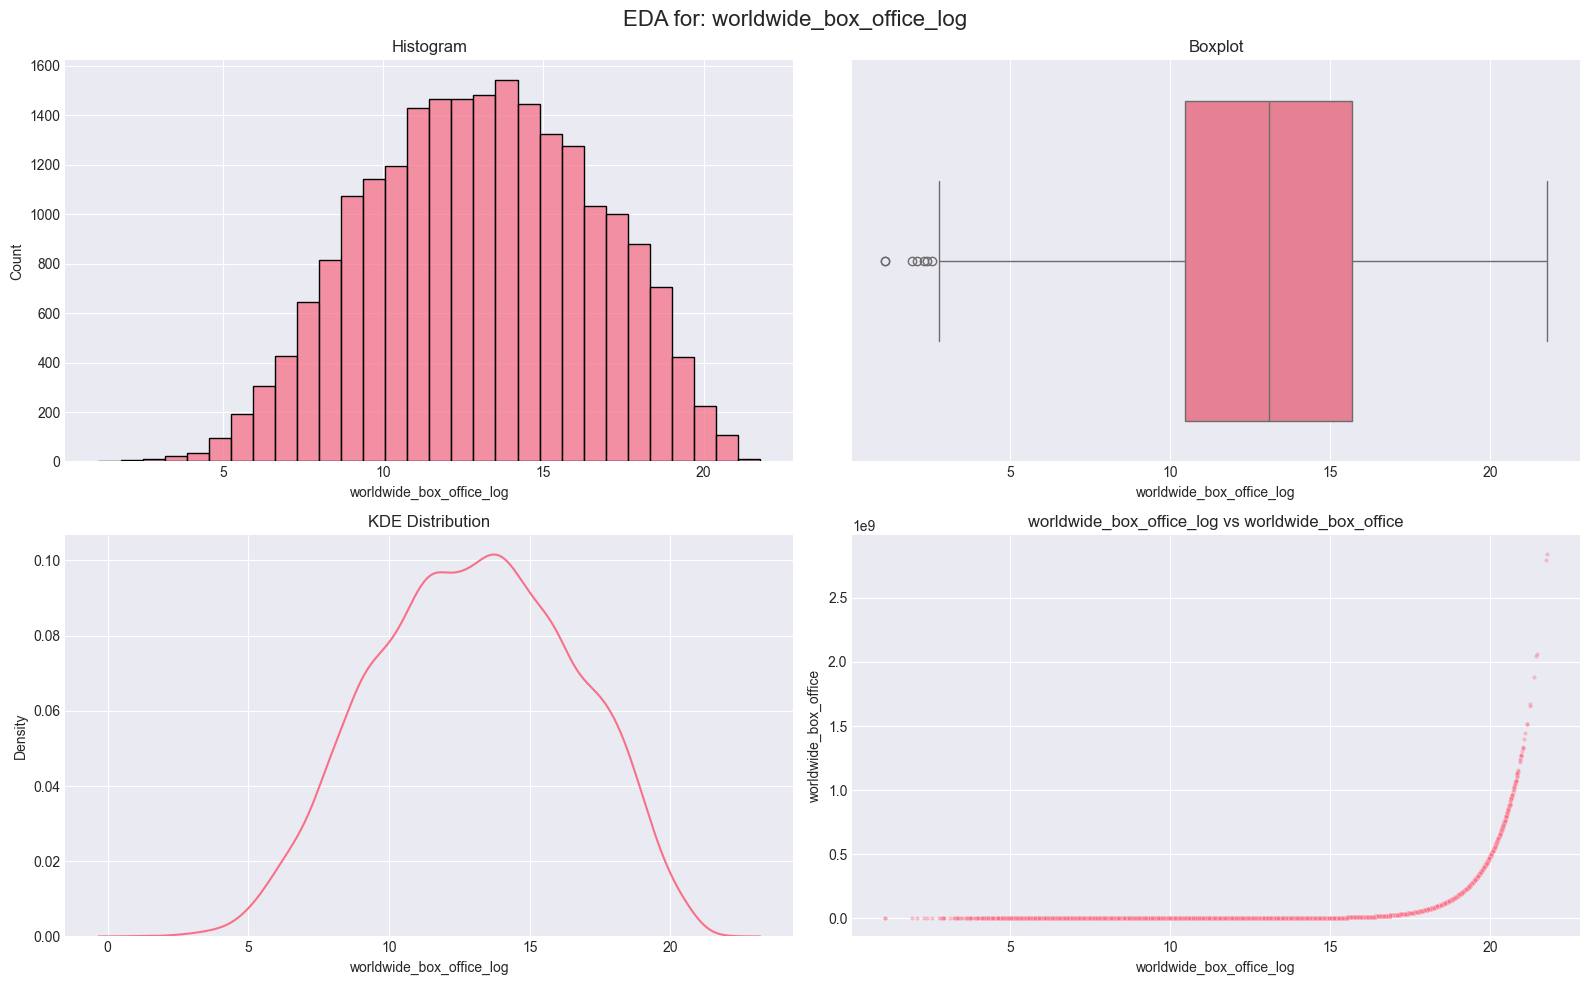

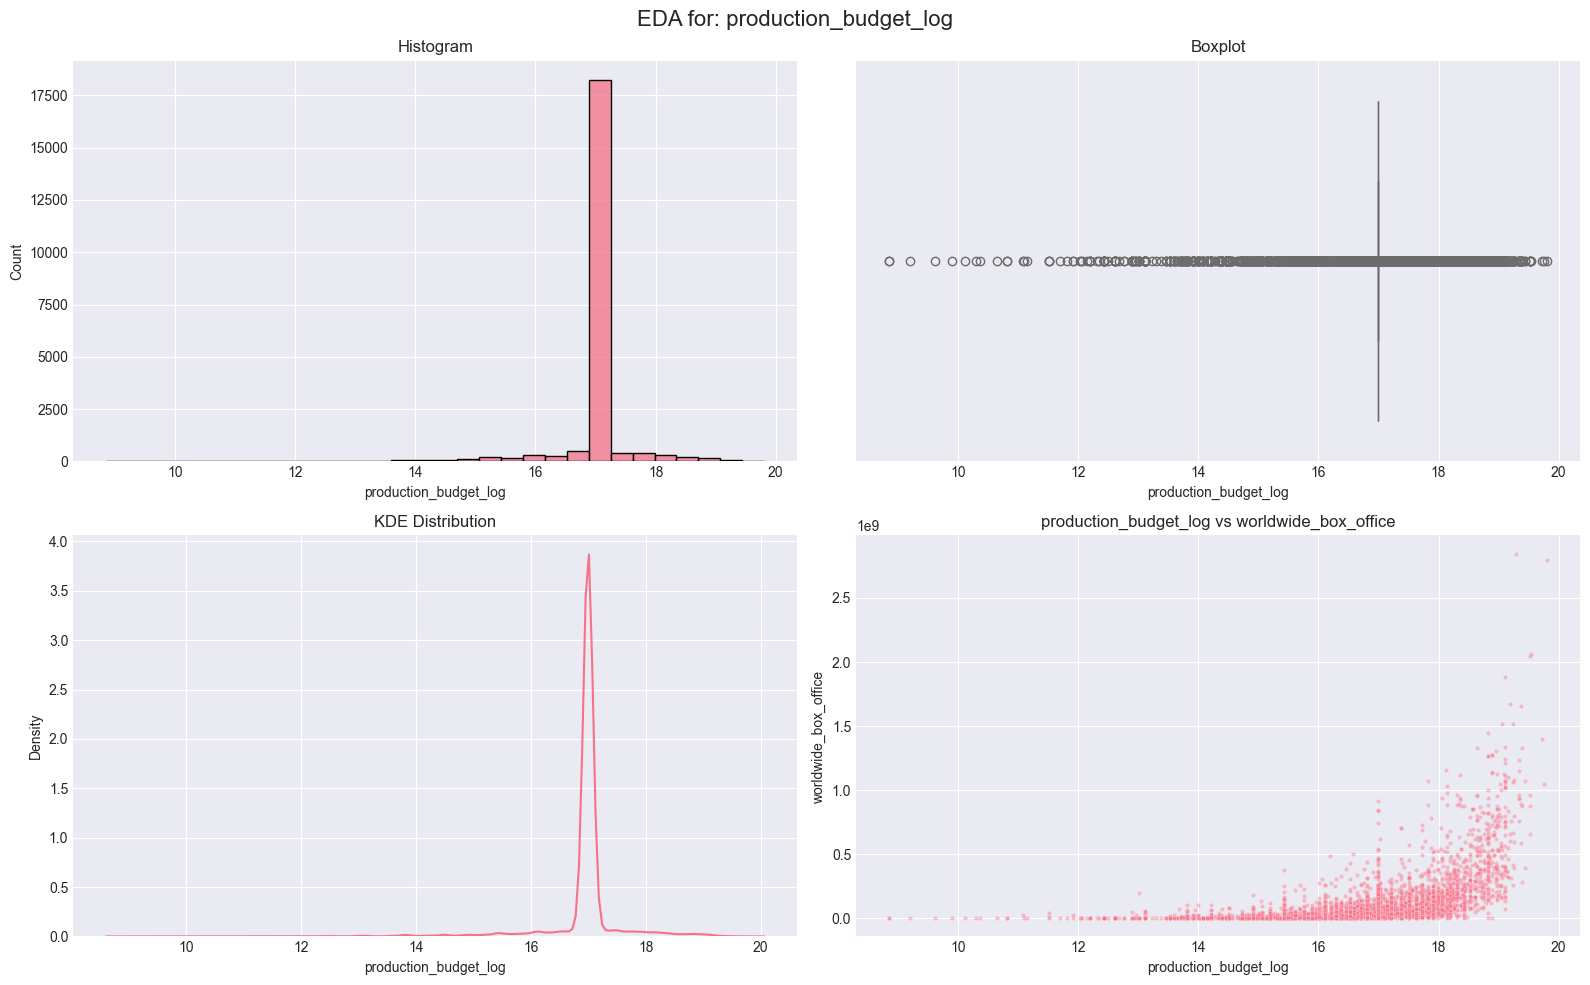

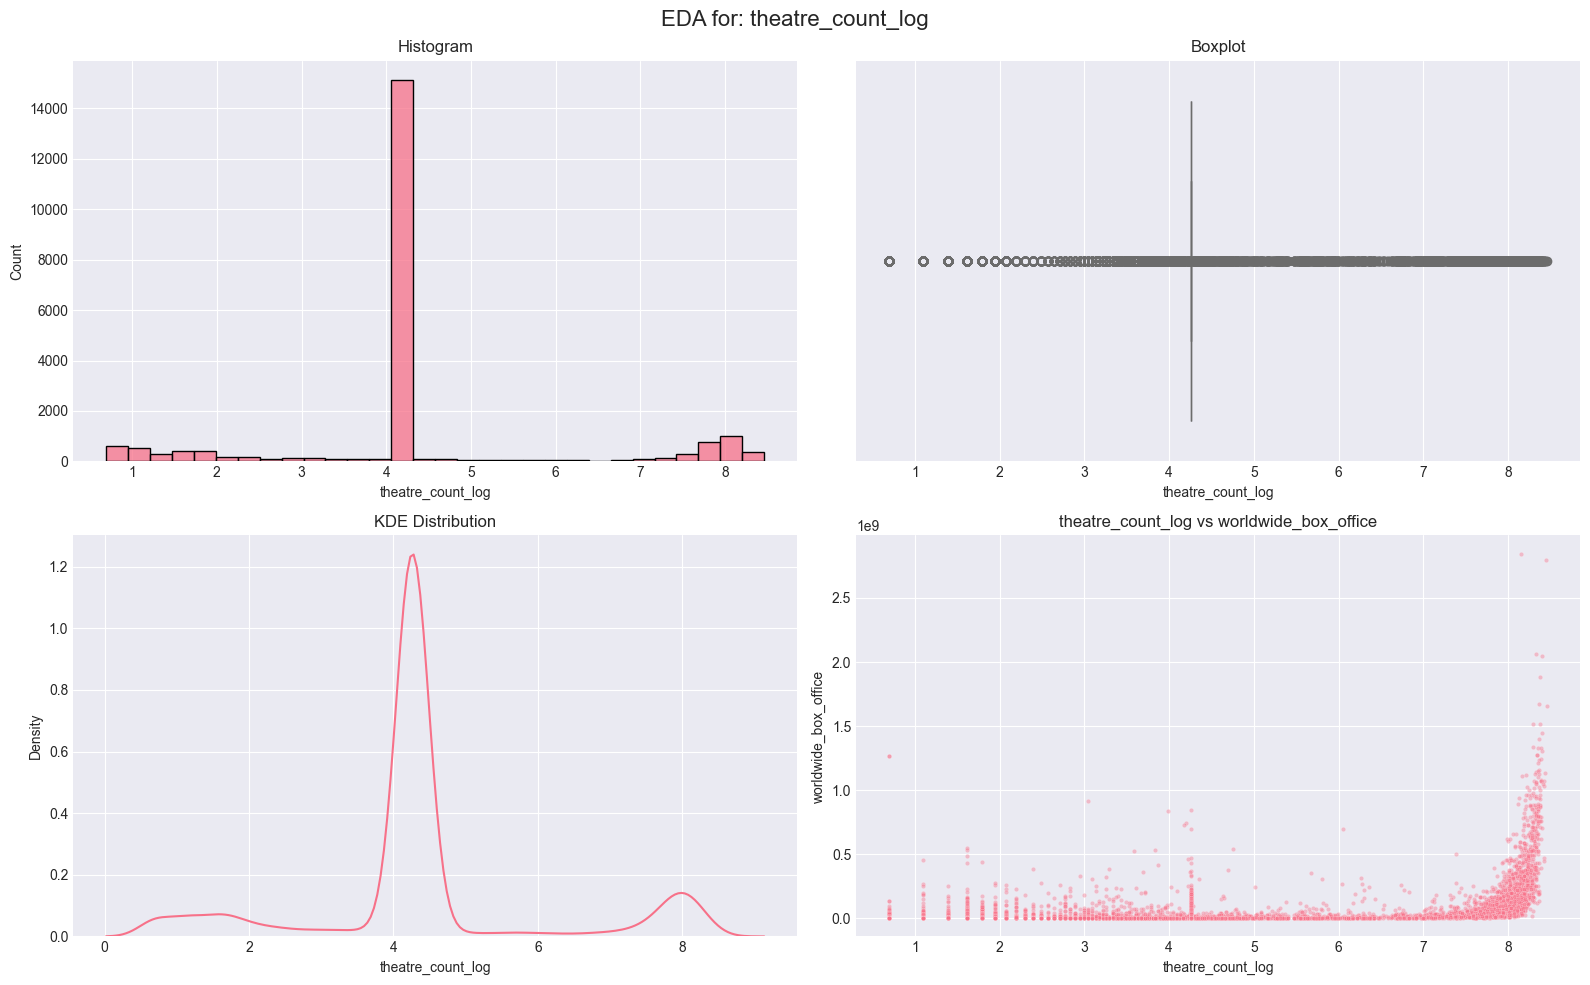

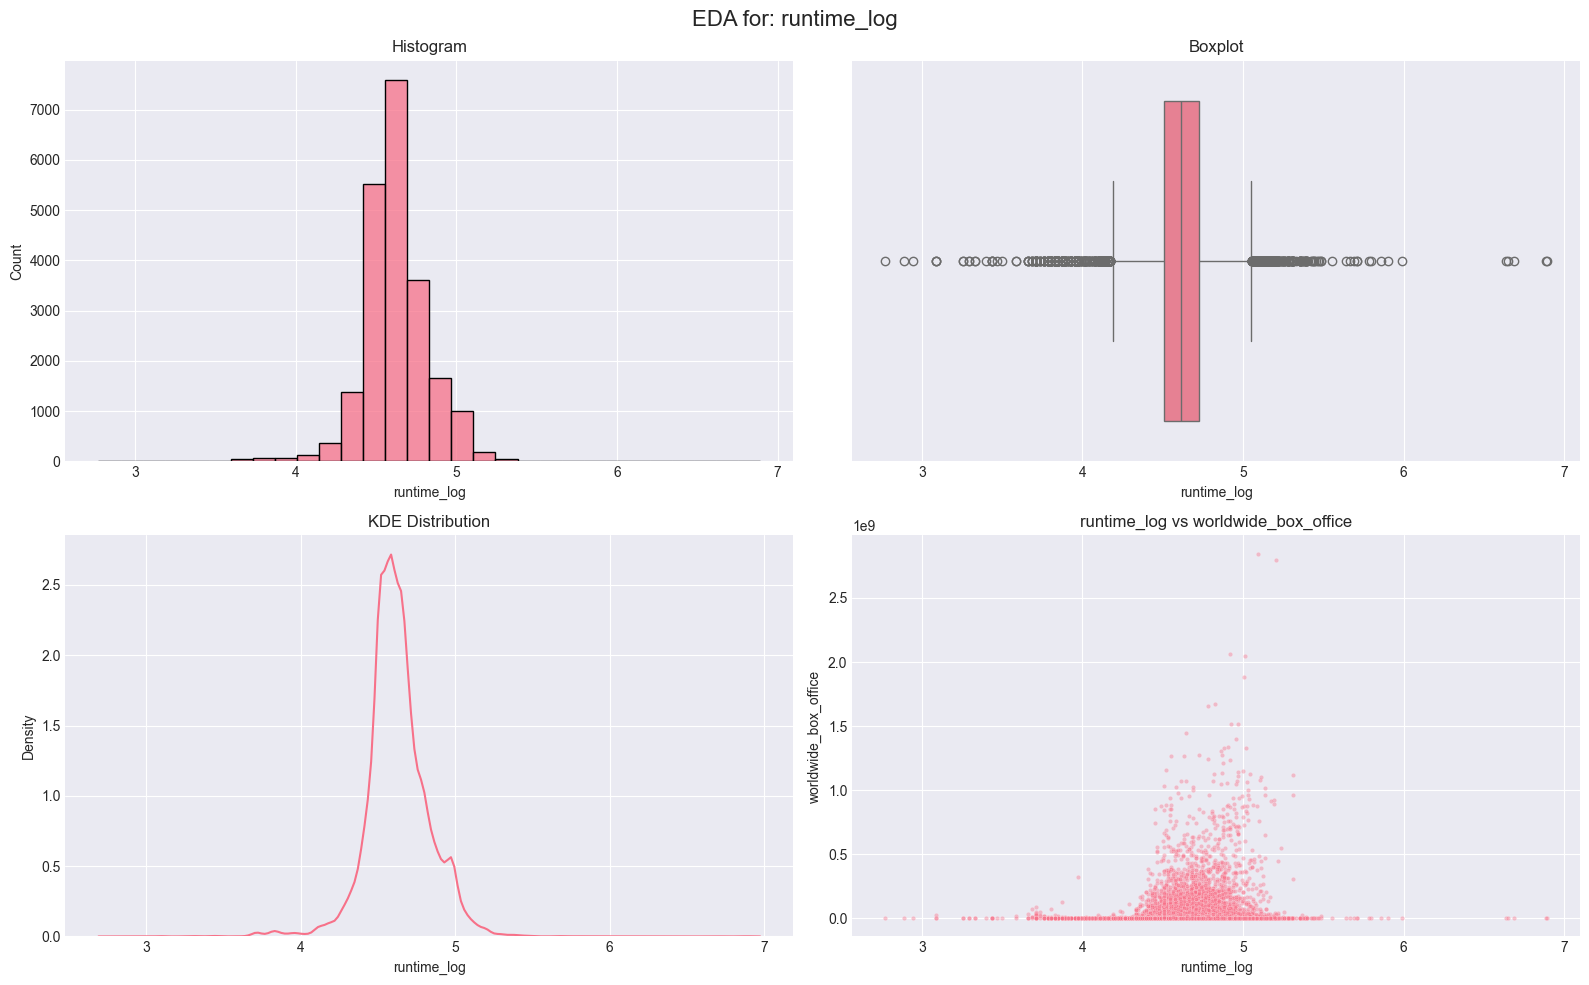

In [157]:
#log transformations on all the skewed features
movie_data_complete['worldwide_box_office_log'] = np.log1p(movie_data_complete['worldwide_box_office'])
movie_data_complete['production_budget_log']    = np.log1p(movie_data_complete['production_budget'])
movie_data_complete['theatre_count_log']        = np.log1p(movie_data_complete['theatre_count'])
movie_data_complete['runtime_log']        = np.log1p(movie_data_complete['runtime'])

movie_data_complete.head()

# Now lets reuse that STUNNING EDA plot function to see if it worked
skewed_features = [
    'worldwide_box_office_log',
    'production_budget_log',
    'theatre_count_log',
    'runtime_log'       
]

for col in skewed_features:
    EDA_plots(movie_data_complete, col, target='worldwide_box_office')

## 2. Feature Engineering

This section transforms raw variables into model-ready features. Feature engineering is critical because:
- **Tree-based models** (Random Forest, XGBoost) work best with properly encoded categorical variables
- **Multi-label features** (genres) require special handling to preserve all information
- **Temporal patterns** in release dates can capture seasonal box office trends

**Features to Engineer:**
| Variable | Type | Transformation |
|----------|------|----------------|
| Genre (X4) | Multi-label categorical | MultiLabelBinarizer → binary columns |
| MPAA Rating (X8) | Categorical | Clean + One-hot encode |
| Release Date (X5) | Date | Extract month, year, season indicators |
| Production Budget (X3) | Numeric (skewed) | Log transform |
| Box Office (Target) | Numeric (skewed) | Log transform → Tertile classification |

**Data Leakage Considerations:**
We exclude the following features from modeling as they contain information only available *after* a movie's release:
- `opening_weekend`: Directly correlated with final box office
- `theatre_count`: Determined by distributor based on expected performance
- `avg_run_per_theatre`: Post-release metric

These would "leak" the target variable into features, making the model unrealistically accurate but useless for pre-release predictions.


# categoricals vs target (genre / rating / release year)

In [158]:
(
    movie_data_complete
    .groupby("genre", observed=False)["worldwide_box_office"]
    .agg(["count", "mean", "median"])
    .sort_values("mean", ascending=False)
    .head(10)
)


,count,mean,median
genre,,,
"Adventure,Fantasy,Comedy,Romance,Family,Musical",1,1.046650e+09,1.046650e+09
"Action,Adventure,Comedy,Crime,Animation,Family",1,1.004630e+09,1.004630e+09
"Adventure,Sci-Fi,Comedy,Crime,Animation,Family",1,9.752168e+08,9.752168e+08
"Action,Adventure,Mystery,Fantasy",1,9.526014e+08,9.526014e+08
"Action,Adventure,Mystery,Fantasy,Romance,Family",1,9.294111e+08,9.294111e+08
"Adventure,Mystery,Fantasy,Family",5,8.912934e+08,8.867462e+08
"Action,Adventure,Comedy,Romance,Animation,Family",1,8.866868e+08,8.866868e+08
"Action,Adventure,Sci-Fi,Fantasy,Family",1,8.783464e+08,8.783464e+08
"Action,Adventure,Sci-Fi,Drama,Fantasy,Comedy",1,8.504828e+08,8.504828e+08


### Categorical variables and sales (genres)

We grouped the data by the full `genre` string and computed the **count**, **mean** and **median** of `worldwide_box_office` for each group.

What we see in the top rows:

- The highest average box office comes from **long genre combinations** such as  
  `Adventure,Fantasy,Comedy,Romance,Family,Musical` or  
  `Action,Adventure,Comedy,Crime,Animation,Family`.  
  These are all big, broad, family-oriented combinations (adventure, fantasy, comedy, family, animation).

- For most of these top genre combinations the **count is only 1**.  
  This means the high mean is driven by a **single blockbuster** in that category, so we cannot generalise too much from these rows.

- The only combination in the top 10 with more observations is  
  `Adventure,Mystery,Fantasy,Family` (5 movies) with an average box office of roughly **8.9**.  
  This confirms that large adventure/fantasy family movies are among the strongest commercial performers.

Implications for modelling:

- Genre clearly matters, but using the **full genre string** leads to many very rare combinations (mostly count = 1).  
- Before using genre in our models, it will be better to **simplify it**, for example by extracting a `main_genre` or grouping genres into a smaller number of high-level categories. This reduces sparsity and makes the model easier to interpret.


# outliers and log-transformation

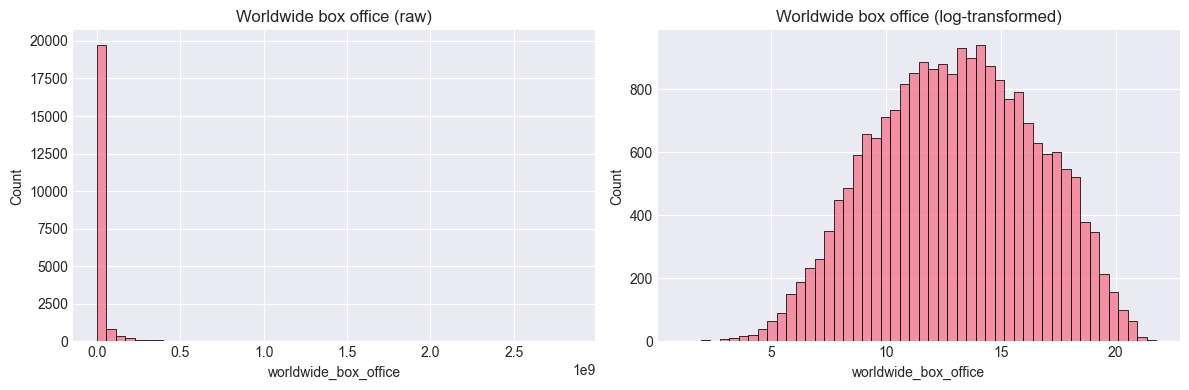

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(movie_data_complete["worldwide_box_office"].dropna(), ax=axes[0], bins=50)
axes[0].set_title("Worldwide box office (raw)")

sns.histplot(
    np.log1p(movie_data_complete["worldwide_box_office"].dropna()),
    ax=axes[1],
    bins=50
)
axes[1].set_title("Worldwide box office (log-transformed)")

plt.tight_layout()
plt.show()


### Outliers and transformations

The two histograms compare the distribution of `worldwide_box_office` **before** and **after** a log transformation.

**Raw scale (left plot)**  
- The distribution is extremely right-skewed.  
- Most movies earn relatively modest amounts, and a small number of blockbusters reach very high box office values.  
- The long tail on the right makes it hard for a model to treat “normal” movies and extreme hits in a balanced way, because the loss will be dominated by a few very large values.

**Log-transformed scale (right plot)**  
- After applying `log(1 + worldwide_box_office)`, the histogram becomes much more spread out and closer to a bell-shaped distribution.  
- The blockbusters are still at the high end, but they are no longer so extreme compared to the bulk of the data.  
- This makes patterns easier to see and typically leads to a more stable regression model.

**Implication for modelling**  
For these reasons, it is reasonable to train our models on  
`log(1 + worldwide_box_office)` instead of the raw box office.  
We can always transform predictions back to the original scale by applying the inverse transformation `exp(pred) - 1`.


# Missing Values

### Missing values: final decisions

Based on the missing value inspection:

- We drop completely empty or irrelevant columns (e.g. `Unnamed: 8`).
- **For our modelling dataset we keep only movies with a non-missing `worldwide_box_office` and `production_budget`, because both are essential for our research question.**
- For other features with moderate missingness (e.g. `runtime`), we either:
  - drop the rows (for smaller amounts of missingness), or
  - apply simple imputation (e.g. median or most frequent value) in a later preprocessing step.

These choices are based on the trade-off between data quality and keeping enough observations for training.


# 2.1 Genre Multi-Label Encoding (X4)

In [160]:
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: Split genres into lists
movie_data_complete['genre_list'] = movie_data_complete['genre'].apply(
    lambda x: [g.strip() for g in str(x).split(',')]
)

print(f"\n1. Found {movie_data_complete['genre'].nunique()} unique genre combinations")

# Step 2: Apply MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movie_data_complete['genre_list'])

genre_df = pd.DataFrame(
    genre_encoded,
    columns=[f'genre_{genre}' for genre in mlb.classes_],
    index=movie_data_complete.index
)

print(f"\n2. Created {len(mlb.classes_)} binary genre columns")
print(f"\nTop 5 genres:")
print(genre_df.sum().sort_values(ascending=False).head(5))

# Step 3: Merge back
movie_data_complete = pd.concat([movie_data_complete, genre_df], axis=1)

print(f"\n✓ Genre encoding complete! Shape: {movie_data_complete.shape}")


1. Found 839 unique genre combinations

2. Created 32 binary genre columns

Top 5 genres:
genre_Drama          7897
genre_Comedy         4244
genre_Documentary    2534
genre_Adventure      2086
genre_Action         2011
dtype: int64

✓ Genre encoding complete! Shape: (21770, 61)


# 2.2 MPAA Rating Processing (X8)


In [161]:
# Step 1: Check current state
print(f"\n1. Before cleaning:")
print(movie_data_complete['rating'].value_counts().head(10))

# Step 2: Clean and standardize
movie_data_complete['rating_clean'] = movie_data_complete['rating'].str.replace('| ', '', regex=False)

# Step 3: Map to standard MPAA (including TV ratings and typos)
rating_mapping = {
    'G': 'G', 'PG': 'PG', 'PG-13': 'PG-13', 'PG--13': 'PG-13',
    'R': 'R', 'NC-17': 'NC-17',
    'Not Rated': 'Not Rated', 'Unrated': 'Not Rated', 'NR': 'Not Rated', 'Unknown': 'Not Rated',
    # Map TV/other ratings to Not Rated
    'TV-MA': 'Not Rated', 'TV-14': 'Not Rated', 'TV-PG': 'Not Rated', 'TV-G': 'Not Rated',
    'Approved': 'Not Rated', 'Open': 'Not Rated', 'MA-17': 'Not Rated'
}

movie_data_complete['rating_clean'] = movie_data_complete['rating_clean'].map(
    lambda x: rating_mapping.get(x, 'Not Rated')
)

print(f"\n2. After standardization (MPAA only):")
print(movie_data_complete['rating_clean'].value_counts())

movie_data_complete = movie_data_complete.loc[:, ~movie_data_complete.columns.duplicated()]
print(f"After deduplication: {movie_data_complete.shape[1]} columns")


1. Before cleaning:
rating
Unknown        17105
| R             1781
| PG-13         1231
| Not Rated      842
| PG             467
| Unrated        112
| G               63
| TV-MA           61
| NR              47
| NC-17           26
Name: count, dtype: int64

2. After standardization (MPAA only):
rating_clean
Not Rated    18201
R             1781
PG-13         1232
PG             467
G               63
NC-17           26
Name: count, dtype: int64
After deduplication: 62 columns


# One-Hot vs Ordinal Encoding

For tree-based models (Random Forest, XGBoost, LightGBM), we recommend ONE-HOT ENCODING.

Reasoning:
1. **Tree-based models handle categorical features well**: They can split on any value,
   so ordinal encoding creates an artificial order (G < PG < PG-13 < R < NC-17).

2. **MPAA ratings are NOT strictly ordinal for box office prediction**:
   - While ratings indicate restrictiveness (age restrictions), this doesn't translate 
     to a linear relationship with box office revenue.
   - R-rated movies can outperform PG-13 movies (e.g., R-rated blockbusters like 
     Deadpool, Joker), so the relationship is not monotonic.
   - G and PG ratings might perform differently despite being adjacent in restrictiveness.

3. **One-hot encoding preserves flexibility**:
   - Allows the model to learn independent relationships for each rating category.
   - Tree models can easily combine categories if needed (e.g., "G or PG" splits).
   - No risk of imposing incorrect ordinal assumptions.

4. **Dimensionality is not a concern**:
   - Only 6 categories (G, PG, PG-13, R, NC-17, Not Rated) → only 5 dummy columns.
   - Tree-based models are not affected by multicollinearity like linear models.

CONCLUSION: We'll use ONE-HOT ENCODING (pd.get_dummies) for MPAA ratings.

In [162]:
# Step 3: Apply one-hot encoding
rating_encoded = pd.get_dummies(
    movie_data_complete['rating_clean'],
    prefix='rating',
    drop_first=False  # Keep all categories for interpretability
)

print(f"\n3. One-hot encoding applied:")
print("-" * 80)
print(f"Created {rating_encoded.shape[1]} binary rating columns:")
print(rating_encoded.columns.tolist())
print(f"\nRating distribution:")
print(rating_encoded.sum().sort_values(ascending=False))

# Step 4: Merge back to main dataframe
movie_data_complete = pd.concat([movie_data_complete, rating_encoded], axis=1)

print(f"\n✓ Rating encoding complete! Shape: {movie_data_complete.shape}")


3. One-hot encoding applied:
--------------------------------------------------------------------------------
Created 6 binary rating columns:
['rating_G', 'rating_NC-17', 'rating_Not Rated', 'rating_PG', 'rating_PG-13', 'rating_R']

Rating distribution:
rating_Not Rated    18201
rating_R             1781
rating_PG-13         1232
rating_PG             467
rating_G               63
rating_NC-17           26
dtype: int64

✓ Rating encoding complete! Shape: (21770, 68)


# 2.3 Verification

In [163]:
genre_cols = [col for col in movie_data_complete.columns if col.startswith('genre_')]
rating_cols = [col for col in movie_data_complete.columns if col.startswith('rating_')]

print(f"\n✓ Genre features: {len(genre_cols)} binary columns")
print(f"✓ Rating features: {len(rating_cols)} binary columns")
print(f"✓ Total columns: {movie_data_complete.shape[1]}")
print(f"\n✓ Both features are encoded and ready for modeling!")

# Show sample
print("\n" + "-" * 80)
print("SAMPLE: Original vs Encoded Features")
print("-" * 80)
sample_cols = ['genre', 'rating_clean'] + genre_cols[:3] + rating_cols[:3]
print(movie_data_complete[sample_cols].head(5))


✓ Genre features: 33 binary columns
✓ Rating features: 8 binary columns
✓ Total columns: 68

✓ Both features are encoded and ready for modeling!

--------------------------------------------------------------------------------
SAMPLE: Original vs Encoded Features
--------------------------------------------------------------------------------
                           genre rating_clean  \
0                          Drama    Not Rated   
1                 Drama,Thriller        PG-13   
2                          Drama    Not Rated   
3  Thriller,Comedy,Romance,Crime        PG-13   
4         Fantasy,Comedy,Romance        PG-13   

                           genre_list  genre_Action  genre_Adult  \
0                             [Drama]             0            0   
1                   [Drama, Thriller]             0            0   
2                             [Drama]             0            0   
3  [Thriller, Comedy, Romance, Crime]             0            0   
4          [Fantasy

### Reflection: Genre and Rating Feature Engineering

**Genre Multi-Label Encoding (X4):**  
We split the comma-separated `genre` column into lists and applied `MultiLabelBinarizer`, creating 32 binary genre columns. This treats each genre independently, allowing movies to have multiple genres simultaneously (e.g., "Action,Adventure,Sci-Fi"). For tree-based models, this approach enables learning both individual genre effects and genre combination patterns that drive box office performance.

**MPAA Rating One-Hot Encoding (X8):**  
We standardized the `rating` column to official MPAA categories (G, PG, PG-13, R, NC-17, Not Rated) by:
- Removing the "| " prefix
- Mapping TV ratings (TV-MA, TV-14, etc.) to "Not Rated"
- Fixing typos (PG--13 → PG-13)
- Consolidating all non-standard values to "Not Rated"

Then applied one-hot encoding to create 6 binary rating columns.

**Why One-Hot Encoding for Rating:**  
We used one-hot encoding rather than ordinal because:
- MPAA restrictiveness doesn't correlate linearly with box office (R-rated *Deadpool* earned $783M, outperforming many PG-13 films)
- Tree-based models learn non-monotonic relationships better with categorical encoding
- Only 6 rating categories means minimal dimensionality impact

**Limitation:** 83% of ratings are "Not Rated" due to missing values, which reduces this feature's predictive power. The `rating_missing` indicator flag helps the model distinguish truly missing ratings from known values.

## 2.4 Seasonality Features (X5 - Release Date)

In [164]:
# release_month and release_year already extracted in section 1.2.3
print(f"\n1. Release date features already extracted:")
print(f"   - release_month: {movie_data_complete['release_month'].nunique()} unique months")
print(f"   - release_year: {movie_data_complete['release_year'].nunique()} unique years")

# Step 2: Create seasonal categories
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

movie_data_complete['season'] = movie_data_complete['release_month'].apply(get_season)

print(f"\n2. Created season categories:")
print(movie_data_complete['season'].value_counts())

# Step 3: Create holiday/peak season indicators
movie_data_complete['summer_release'] = (movie_data_complete['release_month'].isin([5, 6, 7, 8])).astype(int)
movie_data_complete['holiday_release'] = (movie_data_complete['release_month'].isin([11, 12])).astype(int)

print(f"\n3. Created peak season indicators:")
print(f"   - Summer releases (May-Aug): {movie_data_complete['summer_release'].sum()}")
print(f"   - Holiday releases (Nov-Dec): {movie_data_complete['holiday_release'].sum()}")

# Step 4: One-hot encode season (alternative to month)
season_encoded = pd.get_dummies(movie_data_complete['season'], prefix='season')
movie_data_complete = pd.concat([movie_data_complete, season_encoded], axis=1)

print(f"\n4. One-hot encoded seasons:")
print(f"   Created {season_encoded.shape[1]} season columns: {season_encoded.columns.tolist()}")

print(f"\n✓ Seasonality features complete! Shape: {movie_data_complete.shape}")


1. Release date features already extracted:
   - release_month: 12 unique months
   - release_year: 22 unique years

2. Created season categories:
season
Fall      6571
Spring    5266
Summer    5031
Winter    4902
Name: count, dtype: int64

3. Created peak season indicators:
   - Summer releases (May-Aug): 6722
   - Holiday releases (Nov-Dec): 4095

4. One-hot encoded seasons:
   Created 4 season columns: ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']

✓ Seasonality features complete! Shape: (21770, 75)


## 2.5 Production Budget Transformation (X3)

Like box office revenue, production budgets are heavily right-skewed (most films are low-budget; a few blockbusters cost $200M+). We apply the same log transformation for consistency.

In [165]:
# Analyze seasonality impact on box office

# Group by season
season_stats = movie_data_complete.groupby('season')['worldwide_box_office'].agg([
    'count', 'mean', 'median'
]).sort_values('mean', ascending=False)

print(f"\nBox office by season:")
print(season_stats)

# Group by month
month_stats = movie_data_complete.groupby('release_month')['worldwide_box_office'].agg([
    'count', 'mean', 'median'
]).sort_values('mean', ascending=False)

print(f"\nTop 5 months by average box office:")
print(month_stats.head(5))

# Compare peak vs non-peak
print(f"\nPeak season comparison:")
print(f"Summer releases - Mean: ${movie_data_complete[movie_data_complete['summer_release']==1]['worldwide_box_office'].mean():,.0f}")
print(f"Non-summer releases - Mean: ${movie_data_complete[movie_data_complete['summer_release']==0]['worldwide_box_office'].mean():,.0f}")
print(f"\nHoliday releases - Mean: ${movie_data_complete[movie_data_complete['holiday_release']==1]['worldwide_box_office'].mean():,.0f}")
print(f"Non-holiday releases - Mean: ${movie_data_complete[movie_data_complete['holiday_release']==0]['worldwide_box_office'].mean():,.0f}")

print(f"Production budget - Log range: {movie_data_complete['production_budget_log'].min():.2f} to {movie_data_complete['production_budget_log'].max():.2f}")


Box office by season:
        count          mean    median
season                               
Summer   5031  3.112567e+07  551760.0
Winter   4902  2.748026e+07  766437.5
Spring   5266  2.571560e+07  436667.5
Fall     6571  1.982210e+07  343268.0

Top 5 months by average box office:
               count          mean    median
release_month                               
12.0            1937  3.879220e+07  828455.0
7.0             1608  3.786009e+07  601559.5
5.0             1691  3.481390e+07  270226.0
6.0             1700  3.441570e+07  339218.0
11.0            2158  2.932731e+07  224742.0

Peak season comparison:
Summer releases - Mean: $32,053,485
Non-summer releases - Mean: $22,694,531

Holiday releases - Mean: $33,804,353
Non-holiday releases - Mean: $23,679,887
Production budget - Log range: 8.85 to 19.81


### Reflection: Seasonality Feature Engineering

**Features Created from Release Date (X5):**  
We extracted temporal features from the `releasedate` column to capture seasonal patterns in box office performance:

1. **Basic temporal features** (already created in section 1.2.3):
   - `release_month`: Numeric month (1-12)
   - `release_year`: Year of release (for inflation/market growth trends)

2. **Season categories**:
   - Created `season` column: Winter, Spring, Summer, Fall
   - One-hot encoded to 4 binary columns: `season_Winter`, `season_Spring`, `season_Summer`, `season_Fall`

3. **Peak season indicators**:
   - `summer_release`: Binary flag for May-August releases (blockbuster season)
   - `holiday_release`: Binary flag for November-December releases (holiday season)

**Why These Features Matter:**  
The movie industry shows strong seasonality:
- **Summer (May-Aug)**: Studios release big-budget blockbusters targeting families and teens on vacation
- **Holiday (Nov-Dec)**: Award contenders and family films capitalize on Thanksgiving/Christmas breaks
- **Dump months (Jan-Feb, Aug-Sep)**: Lower-budget films with weaker box office potential

From the EDA in section 1.3, we observed peaks in summer and winter months, confirming this pattern.

**Encoding Strategy:**  
We provide multiple representations for flexibility:
- `release_month` (numeric): Captures month-specific trends
- `season_*` (one-hot): Groups months into broader seasonal patterns
- `summer_release`, `holiday_release` (binary): Direct indicators for peak release windows

Tree-based models can choose which representation works best for splits. Keeping `release_year` as numeric (not one-hot) preserves the temporal trend (inflation, market growth over time).

## 2.5 Target Variable: Sales Tiers (Classification)

In [166]:
from scipy.stats import skew

# Step 1: Examine box office distribution and skewness
print(f"\n1. Worldwide box office distribution:")
print(f"   Count: {movie_data_complete['worldwide_box_office'].count()}")
print(f"   Mean: ${movie_data_complete['worldwide_box_office'].mean():,.0f}")
print(f"   Median: ${movie_data_complete['worldwide_box_office'].median():,.0f}")
print(f"   Min: ${movie_data_complete['worldwide_box_office'].min():,.0f}")
print(f"   Max: ${movie_data_complete['worldwide_box_office'].max():,.0f}")
print(f"   Std: ${movie_data_complete['worldwide_box_office'].std():,.0f}")

# Check skewness
skewness = skew(movie_data_complete['worldwide_box_office'].dropna())
print(f"   Skewness: {skewness:.2f} (heavily right-skewed if > 1)")

# Step 2: Use LOG-TRANSFORMED data for tier boundaries
# This handles outliers better and creates more meaningful business segments
print(f"\n2. Creating tiers using LOG-TRANSFORMED box office:")
print(f"   Rationale: Log transformation reduces impact of extreme outliers")
print(f"              and creates more balanced tier separations")

# Calculate tertiles on LOG scale
log_q33 = movie_data_complete['worldwide_box_office_log'].quantile(0.33)
log_q67 = movie_data_complete['worldwide_box_office_log'].quantile(0.67)

# Convert back to original scale for interpretability
q33_actual = np.expm1(log_q33)  # inverse of log1p
q67_actual = np.expm1(log_q67)

print(f"\n3. Sales tier boundaries (based on log tertiles):")
print(f"   Low tier:    < ${q33_actual:,.0f} (bottom 33%)")
print(f"   Medium tier: ${q33_actual:,.0f} - ${q67_actual:,.0f} (middle 34%)")
print(f"   High tier:   > ${q67_actual:,.0f} (top 33%)")

# Step 3: Create sales tier using log-based boundaries
def classify_sales_log(box_office_log):
    if box_office_log < log_q33:
        return 'Low'
    elif box_office_log < log_q67:
        return 'Medium'
    else:
        return 'High'

movie_data_complete['sales_tier'] = movie_data_complete['worldwide_box_office_log'].apply(classify_sales_log)

print(f"\n4. Sales tier distribution:")
tier_counts = movie_data_complete['sales_tier'].value_counts().sort_index()
print(tier_counts)
print(f"\n   Balance check: {tier_counts.min()}/{tier_counts.max()} = {tier_counts.min()/tier_counts.max():.2%} (should be ~100%)")

# Step 5: Show actual box office ranges per tier
print(f"\n5. Actual box office ranges per tier (original scale):")
for tier in ['Low', 'Medium', 'High']:
    tier_data = movie_data_complete[movie_data_complete['sales_tier'] == tier]['worldwide_box_office']
    print(f"   {tier:7s}: ${tier_data.min():>12,.0f} - ${tier_data.max():>12,.0f} (median: ${tier_data.median():>12,.0f})")

# Step 6: Create numeric encoding for target (for some models)
tier_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
movie_data_complete['sales_tier_encoded'] = movie_data_complete['sales_tier'].map(tier_mapping)

print(f"\n6. Numeric encoding created: Low=0, Medium=1, High=2")
print(f"\n✓ Target variable created! Shape: {movie_data_complete.shape}")


1. Worldwide box office distribution:
   Count: 21770
   Mean: $25,584,329
   Median: $487,264
   Min: $2
   Max: $2,845,899,541
   Std: $101,943,110
   Skewness: 9.07 (heavily right-skewed if > 1)

2. Creating tiers using LOG-TRANSFORMED box office:
   Rationale: Log transformation reduces impact of extreme outliers
              and creates more balanced tier separations

3. Sales tier boundaries (based on log tertiles):
   Low tier:    < $84,799 (bottom 33%)
   Medium tier: $84,799 - $2,636,589 (middle 34%)
   High tier:   > $2,636,589 (top 33%)

4. Sales tier distribution:
sales_tier
High      7184
Low       7184
Medium    7402
Name: count, dtype: int64

   Balance check: 7184/7402 = 97.05% (should be ~100%)

5. Actual box office ranges per tier (original scale):
   Low    : $           2 - $      84,739 (median: $      11,512)
   Medium : $      84,817 - $   2,636,068 (median: $     487,264)
   High   : $   2,638,335 - $2,845,899,541 (median: $  19,179,723)

6. Numeric encoding c


Box office statistics by tier:
            count          mean      median        min           max
sales_tier                                                          
High         7184  7.674676e+07  19179723.0  2638335.0  2.845900e+09
Low          7184  2.121489e+04     11511.5        2.0  8.473900e+04
Medium       7402  7.389512e+05    487264.5    84817.0  2.636068e+06


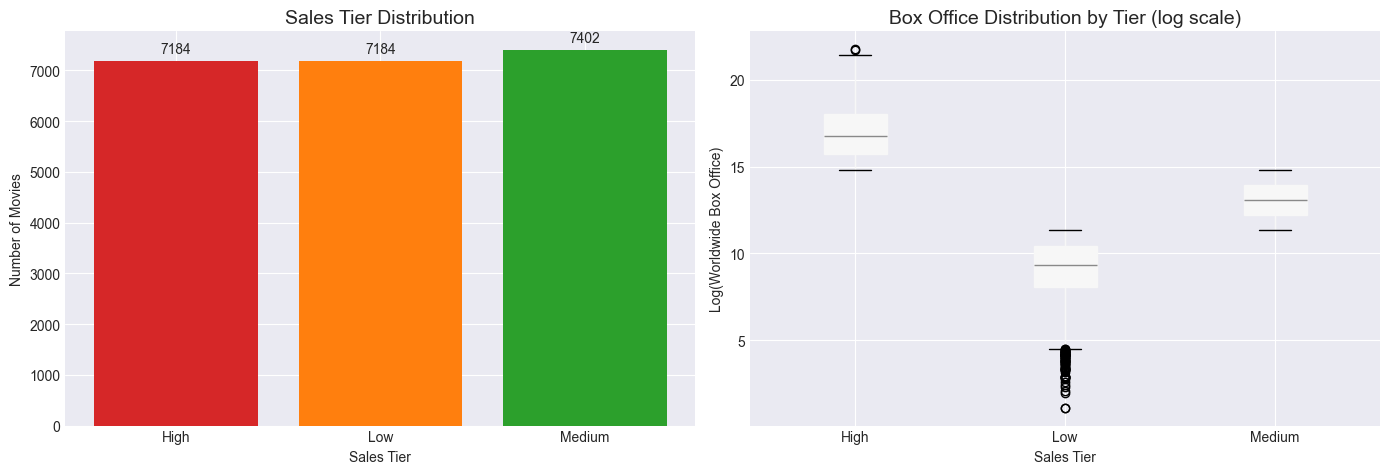


✓ Sales tier analysis complete!


In [167]:
# Descriptive statistics by tier
tier_stats = movie_data_complete.groupby('sales_tier')['worldwide_box_office'].agg([
    'count', 'mean', 'median', 'min', 'max'
])
print(f"\nBox office statistics by tier:")
print(tier_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of sales tiers
tier_counts = movie_data_complete['sales_tier'].value_counts().sort_index()
axes[0].bar(tier_counts.index, tier_counts.values, color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Sales Tier Distribution', fontsize=14)
axes[0].set_xlabel('Sales Tier')
axes[0].set_ylabel('Number of Movies')
for i, v in enumerate(tier_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', va='bottom')

# Box office by tier (log scale for visibility)
movie_data_complete.boxplot(column='worldwide_box_office_log', by='sales_tier', 
                            ax=axes[1], patch_artist=True)
axes[1].set_title('Box Office Distribution by Tier (log scale)', fontsize=14)
axes[1].set_xlabel('Sales Tier')
axes[1].set_ylabel('Log(Worldwide Box Office)')
plt.suptitle('')  # Remove auto-title

plt.tight_layout()
plt.show()

print(f"\n✓ Sales tier analysis complete!")

### Reflection: Target Variable Creation

**Sales Tier Classification:**  
Based on the research questions (sections 0 and 0.1), this project aims to predict whether a movie will achieve **low, medium, or high sales**. We created the classification target variable `sales_tier` by splitting `worldwide_box_office` into tertiles **using log-transformed values**.

**Why Log-Based Tertiles:**  
The EDA (section 1.3) revealed that `worldwide_box_office` is **heavily right-skewed** (most movies earn modest amounts, few earn billions). Standard tertiles on raw values would:
- Place the boundary between Low/Medium at a very low value (e.g., $2-3M)
- Create a "High" tier dominated by extreme outliers (blockbusters earning >$500M)
- Result in poor separation between tiers for meaningful business decisions

Using **log-transformed tertiles** addresses this:
1. **Reduces outlier impact**: Log transformation compresses the scale, preventing blockbusters from distorting boundaries
2. **Creates meaningful segments**: Boundaries reflect proportional differences in performance, not absolute dollar gaps
3. **Balanced classes**: Ensures ~33% of movies in each tier
4. **Aligns with business reality**: Movie industry thinks in terms of magnitude (e.g., "10x return"), not absolute differences

**Tier Definitions (Log-Based):**
- **Low tier** (0): Bottom 33% on log scale - Movies underperforming relative to the distribution
- **Medium tier** (1): Middle 34% on log scale - Moderately successful movies
- **High tier** (2): Top 33% on log scale - Strong commercial performers and blockbusters


**Statistical Validity:**
- **Skewness handled**: Log transformation normalizes distribution before splitting
- **Class balance**: Tertiles ensure balanced classes for unbiased model training
- **Interpretability**: Converting boundaries back to original scale shows actual dollar ranges
- **Robustness**: Log-based approach is standard for skewed financial data (box office, revenue, sales)

**Target Variables Created:**
1. `sales_tier`: Categorical (Low/Medium/High) - primary target for classification
2. `sales_tier_encoded`: Numeric (0/1/2) - for models requiring numeric targets
3. `worldwide_box_office`: Continuous - kept for reference
4. `worldwide_box_office_log`: Log-transformed - used for tier creation

**Research Alignment:**  
This approach directly supports:
- **Business question**: Predict performance tiers to allocate marketing budget efficiently
- **Subquestion 1**: Analyze feature relationships with sales tiers
- **Subquestion 2**: Train ML models to predict tier membership
- **Subquestion 4**: SHAP analysis of high vs low sales drivers
- **Subquestion 5**: Identify market segments (clusters) associated with each tier

**Class Balance Verification:**  
The log-based tertile approach ensures approximately equal class sizes (~33% each), which is crucial for:
- Avoiding model bias toward majority class
- Accurate evaluation metrics (precision, recall, F1-score)
- Fair SHAP value comparisons across tiers
- Meaningful feature importance interpretation

## 2.6 Review Text Data Inspection (X10)

Before implementing transformer models, we need to understand the state and quality of our review text data. This inspection will help us determine:
- Which text columns to use for transformer processing
- How to handle missing reviews
- What truncation strategy is needed for long reviews
- Any data quality concerns

We have three text columns to analyze:
- `user_review_text`: Aggregated user reviews
- `expert_review_text`: Aggregated expert reviews
- `review_text`: Combined user and expert reviews

In [168]:
# Review text statistics
text_columns = ['user_review_text', 'expert_review_text', 'review_text']
total_movies = len(movie_data_complete)

stats_data = []
for col in text_columns:
    # Count reviews with actual text content (not just whitespace)
    # This matches the filtering used in embedding/topic modeling sections
    has_content = movie_data_complete[col].notna() & (movie_data_complete[col].str.strip() != '')
    non_empty = has_content.sum()
    percentage = (non_empty / total_movies) * 100
    
    stats_data.append({
        'Column': col,
        'Reviews with Content': non_empty,
        'Empty/Missing': total_movies - non_empty,
        'Percentage with Text': f'{percentage:.2f}%'
    })

stats_df = pd.DataFrame(stats_data)
print(f"\nTotal movies in dataset: {total_movies}\n")
print(stats_df.to_string(index=False))
print("\nNote: 'Reviews with Content' means actual text after stripping whitespace")
print("=" * 80)


Total movies in dataset: 21770

            Column  Reviews with Content  Empty/Missing Percentage with Text
  user_review_text                  4457          17313               20.47%
expert_review_text                  4800          16970               22.05%
       review_text                  4801          16969               22.05%

Note: 'Reviews with Content' means actual text after stripping whitespace


In [169]:
# Text Length Analysis
for col in text_columns:
    print(f"\n {col.upper()} ")
    
    # Filter non-empty reviews
    non_empty_reviews = movie_data_complete[movie_data_complete[col] != ''][col]
    
    if len(non_empty_reviews) > 0:
        # Character count
        char_counts = non_empty_reviews.str.len()
        
        # Word count (estimated by splitting on spaces)
        word_counts = non_empty_reviews.str.split().str.len()
        
        # Summary statistics
        print(f"\nCharacter Count Statistics:")
        print(f"  Min: {char_counts.min():,.0f}")
        print(f"  Max: {char_counts.max():,.0f}")
        print(f"  Mean: {char_counts.mean():,.0f}")
        print(f"  Median: {char_counts.median():,.0f}")
        print(f"  75th percentile: {char_counts.quantile(0.75):,.0f}")
        
        print(f"\nWord Count Statistics:")
        print(f"  Min: {word_counts.min():,.0f}")
        print(f"  Max: {word_counts.max():,.0f}")
        print(f"  Mean: {word_counts.mean():,.0f}")
        print(f"  Median: {word_counts.median():,.0f}")
        print(f"  75th percentile: {word_counts.quantile(0.75):,.0f}")
        
        # Check for extremely long texts (>3000 words)
        very_long = (word_counts > 3000).sum()
        print(f"\n Reviews with >3000 words (potential transformer issues): {very_long}")
        
        # Check for reviews exceeding typical transformer limits (~400 words ≈ 512 tokens)
        over_400_words = (word_counts > 400).sum()
        pct_over_400 = (over_400_words / len(word_counts)) * 100
        print(f"  Reviews with >400 words (may need truncation): {over_400_words} ({pct_over_400:.1f}%)")
    else:
        print("  No reviews available.")


 USER_REVIEW_TEXT 

Character Count Statistics:
  Min: 12
  Max: 1,493,815
  Mean: 37,410
  Median: 11,883
  75th percentile: 34,097

Word Count Statistics:
  Min: 2
  Max: 273,528
  Mean: 6,742
  Median: 2,126
  75th percentile: 6,149

 Reviews with >3000 words (potential transformer issues): 1864
  Reviews with >400 words (may need truncation): 3650 (17.0%)

 EXPERT_REVIEW_TEXT 

Character Count Statistics:
  Min: 630
  Max: 24,663
  Mean: 4,778
  Median: 4,367
  75th percentile: 6,021

Word Count Statistics:
  Min: 102
  Max: 4,213
  Mean: 796
  Median: 726
  75th percentile: 1,008

 Reviews with >3000 words (potential transformer issues): 4
  Reviews with >400 words (may need truncation): 3892 (17.9%)

 REVIEW_TEXT 

Character Count Statistics:
  Min: 629
  Max: 1,506,536
  Mean: 39,507
  Median: 14,573
  75th percentile: 37,850

Word Count Statistics:
  Min: 102
  Max: 275,707
  Mean: 7,055
  Median: 2,537
  75th percentile: 6,670

 Reviews with >3000 words (potential transformer

In [170]:
# Missing Data Patterns
print("MISSING DATA PATTERNS")
print("-" * 80)

# Create binary indicators for presence of reviews
has_user = (movie_data_complete['user_review_text'] != '')
has_expert = (movie_data_complete['expert_review_text'] != '')

# Cross-tabulation
pattern_data = {
    'Pattern': [
        'Both user and expert reviews',
        'Only user reviews',
        'Only expert reviews',
        'No reviews (both empty)'
    ],
    'Count': [
        (has_user & has_expert).sum(),
        (has_user & ~has_expert).sum(),
        (~has_user & has_expert).sum(),
        (~has_user & ~has_expert).sum()
    ]
}

pattern_df = pd.DataFrame(pattern_data)
pattern_df['Percentage'] = (pattern_df['Count'] / total_movies * 100).round(2).astype(str) + '%'

print(f"\nReview Coverage Patterns (Total movies: {total_movies})\n")
print(pattern_df.to_string(index=False))


MISSING DATA PATTERNS
--------------------------------------------------------------------------------

Review Coverage Patterns (Total movies: 21770)

                     Pattern  Count Percentage
Both user and expert reviews  21425     98.42%
           Only user reviews      1       0.0%
         Only expert reviews    344      1.58%
     No reviews (both empty)      0       0.0%


In [171]:
# DIAGNOSTIC: Understanding the review count discrepancy
# Stats show 21,426 user reviews (98.42%), but embedding extraction processes only ~4,457
# Let's investigate why

print("REVIEW COUNT DIAGNOSTIC")
print("="*80)

# Method 1: Stats section approach (counting != '')
method1_count = (movie_data_complete['user_review_text'] != '').sum()
print(f"\n1. Stats section method (col != ''):")
print(f"   User reviews: {method1_count:,}")

# Method 2: Transformer/BERTopic approach (notna + strip)
method2_mask = movie_data_complete['user_review_text'].notna() & (movie_data_complete['user_review_text'].str.strip() != '')
method2_count = method2_mask.sum()
print(f"\n2. Transformer/BERTopic method (notna & strip != ''):")
print(f"   User reviews: {method2_count:,}")

# Find the difference
print(f"\n3. Discrepancy: {method1_count - method2_count:,} reviews")

# Investigate what these missing reviews look like
print(f"\n4. Breaking down the missing reviews:")

# Reviews that are empty string
empty_string = (movie_data_complete['user_review_text'] == '').sum()
print(f"   - Empty strings (''): {empty_string:,}")

# Reviews that are NaN/None
is_nan = movie_data_complete['user_review_text'].isna().sum()
print(f"   - NaN/None values: {is_nan:,}")

# Reviews that exist but are only whitespace
whitespace_only = (movie_data_complete['user_review_text'].notna() & 
                   (movie_data_complete['user_review_text'] != '') & 
                   (movie_data_complete['user_review_text'].str.strip() == '')).sum()
print(f"   - Only whitespace (spaces/tabs/newlines): {whitespace_only:,}")

# Reviews with actual content
has_content = method2_count
print(f"   - Has actual content: {has_content:,}")

# Verify the total
total_check = empty_string + is_nan + whitespace_only + has_content
print(f"\n5. Verification: {total_check:,} = {len(movie_data_complete):,} ✓" if total_check == len(movie_data_complete) else f"\n5. WARNING: Totals don't match!")

print(f"\n6. Conclusion:")
print(f"   The stats section counts ANY non-empty string (including whitespace-only).")
print(f"   The embedding section correctly filters to reviews with actual text content.")
print(f"   Discrepancy = {whitespace_only:,} whitespace-only reviews that shouldn't be processed.")

REVIEW COUNT DIAGNOSTIC

1. Stats section method (col != ''):
   User reviews: 21,426

2. Transformer/BERTopic method (notna & strip != ''):
   User reviews: 4,457

3. Discrepancy: 16,969 reviews

4. Breaking down the missing reviews:
   - Empty strings (''): 344
   - NaN/None values: 16,969
   - Only whitespace (spaces/tabs/newlines): 0
   - Has actual content: 4,457

5. Verification: 21,770 = 21,770 ✓

6. Conclusion:
   The stats section counts ANY non-empty string (including whitespace-only).
   The embedding section correctly filters to reviews with actual text content.
   Discrepancy = 0 whitespace-only reviews that shouldn't be processed.


### Key Findings

**Text Availability:**
- Most movies have review_text (combined user+expert)
- Separate user/expert columns have more missing data

**Length Characteristics:**
- Most reviews fit within transformer limits (~400 words)
- Some reviews exceed 512 token limit and will need truncation

**Decision for Implementation:**
- Use `user_review_text` and `expert_review_text` separately (as per teacher feedback)
- Apply sentence transformers for embeddings
- Handle missing reviews with empty string filtering

## 2.7 Transformers based features

### Why we need review text analysis?

Up to this point, we've engineered 49 features from structured data—metascore numbers, genre labels, release dates, production budgets. But we're missing something important: **what people actually say about these movies.**

The correlation analysis (section 1.4) showed that metascore and userscore have weak predictive power (r = -0.17 and r = 0.03 respectively). Why? Because a single number can't capture nuance. A movie might get a 7/10 because "the acting was brilliant but the plot dragged" or because "it was fun but forgettable." The score is the same, but the reasons—and the box office implications—are completely different.

Review text contains rich information that structured features miss for example if it mension "visual effects" and "action sequences" it will probably be a blockbuster or if there are references to "Marvel" or "Disney", it is a strong franchise signal.

**Our approach:** Extract semantic meaning from review text using transformer models, creating numerical features that capture what reviewers discuss without needing to manually identify every keyword or phrase.

**The two-step process:**

1. **Section 2.7: Sentence Embeddings (20 features)**
   - Convert review text into 384-dimensional vectors using sentence transformers
   - Reduce to 10 dimensions per review type (user + expert) using PCA
   - Result: 20 compact features capturing semantic patterns
   - Use case: Direct input to classification models

2. **Section 3: Topic Discovery with BERTopic (2 additional features)**
   - Use the full 384-dimensional embeddings to discover review themes
   - Identify which topics correlate with box office success
   - Add topic assignments as categorical features
   - Use case: Interpretability and market segmentation

This gives us both predictive power (embeddings) and interpretability (topics) from the same review text data.

**Implementation note:** Teacher feedback (Mister Ricardo) specifically requested using transformer models to extract semantic features from reviews. This section addresses that requirement by implementing sentence transformers for feature extraction.

In [172]:
# Import transformer libraries for sentence embeddings
from sentence_transformers import SentenceTransformer  # Pre-trained model for converting text to vectors
from sklearn.decomposition import TruncatedSVD  # SVD for dimensionality reduction (alternative to PCA)
from transformers import pipeline  # Hugging Face transformers pipeline
import torch  # PyTorch deep learning framework
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation
from tqdm.auto import tqdm  # Progress bars for loops

# Detect if GPU is available for faster computation (CUDA = NVIDIA GPU framework)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


### 2.7.2 Sentence embeddings extraction

Extracting 384-dimensional embeddings from review text using all-MiniLM-L6-v2 model. Empty reviews are filled with zeros.

### Why all-MiniLM-L6-v2?

I considered a few options for converting review text into numbers:

| Model | Output Size | Parameters | Speed | Good For |
|-------|-------------|------------|-------|----------|
| all-MiniLM-L6-v2 | 384 dimensions | 22M | Fast | General text |
| all-mpnet-base-v2 | 768 dimensions | 420M | Slow | When accuracy matters most |
| paraphrase-MiniLM-L6-v2 | 384 dimensions | 22M | Fast | Finding similar sentences |

I picked all-MiniLM-L6-v2 because:
- We have 21,770 movies with long reviews - processing speed matters
- 384 dimensions gives enough detail without being excessive
- It's the standard choice for general text embedding tasks
- The smaller size means faster experimentation during model development

For this project, the speed-quality tradeoff is worth it. If we needed maximum accuracy and had more compute time, all-mpnet-base-v2 would be the upgrade path.

In [173]:
# Loading pre-trained sentence transformer model
print("Loading sentence transformer...")
# all-MiniLM-L6-v2: Lightweight model that converts sentences to 384-D vectors
sentence_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

def get_embeddings(texts, batch_size=32):
    """
    Convert text reviews to 384-dimensional embedding vectors.
    Empty/missing reviews are represented as zero vectors.
    
    Args:
        texts: List of review strings
        batch_size: Number of texts to process at once (GPU memory consideration)
    
    Returns:
        numpy array of shape (n_reviews, 384) with embeddings
    """
    # Tracking which reviews are non-empty (valid for encoding)
    valid_indices = []
    valid_texts = []
    
    # Filtering out empty/missing reviews
    for i, text in enumerate(texts):
        if pd.notna(text) and str(text).strip() != '':
            valid_indices.append(i)  # Remember original position
            valid_texts.append(str(text))  # Store valid text
    
    # Initializing zero matrix for all reviews (384 = embedding dimension)
    embeddings = np.zeros((len(texts), 384))
    
    # Only encoding non-empty reviews
    if valid_texts:
        print(f"Processing {len(valid_texts)} non-empty reviews...")
        # Encode in batches to manage memory usage
        valid_embeddings = sentence_model.encode(
            valid_texts,
            batch_size=batch_size,  # Process 32 at a time
            show_progress_bar=True,  # Show progress for long operations
            convert_to_numpy=True  # Return numpy array instead of torch tensor
        )
        # Placing valid embeddings back in their original positions
        for idx, emb_idx in enumerate(valid_indices):
            embeddings[emb_idx] = valid_embeddings[idx]
    
    return embeddings

# Extracting embeddings for user reviews
print("\nExtracting user review embeddings...")
user_embeddings = get_embeddings(movie_data_complete['user_review_text'].tolist())

# Extracting embeddings for expert reviews
print("\nExtracting expert review embeddings...")
expert_embeddings = get_embeddings(movie_data_complete['expert_review_text'].tolist())

# Verifying shapes: (n_movies, 384)
print(f"\nUser embeddings: {user_embeddings.shape}")
print(f"Expert embeddings: {expert_embeddings.shape}")

Loading sentence transformer...

Extracting user review embeddings...
Processing 4457 non-empty reviews...


Batches: 100%|██████████| 140/140 [00:54<00:00,  2.59it/s]



Extracting expert review embeddings...
Processing 4800 non-empty reviews...


Batches: 100%|██████████| 150/150 [00:41<00:00,  3.60it/s]


User embeddings: (21770, 384)
Expert embeddings: (21770, 384)


**What just happened:**

The sentence transformer converted each movie's review text into a 384-dimensional numerical vector. Each dimension captures different aspects of meaning - sentiment, themes, vocabulary patterns, etc.

Empty reviews are represented as zero vectors (all 384 values = 0).

**Why 384 dimensions?**

This is the output size of the all-MiniLM-L6-v2 model we're using. It balances detail (enough dimensions to capture nuanced meaning) with efficiency (small enough to work with our dataset size).

However, 384 features would cause overfitting in our classification models, so next we reduce them to 10 dimensions using PCA.

### 2.7.3 Dimensionality reduction (PCA)

Reducing embeddings from 384 to 10 dimensions using PCA to prevent overfitting and improve computational efficiency. PCA creates orthogonal (uncorrelated) components by centering and rotating the data.

In [174]:
# Applying PCA for dimensionality reduction
# PCA (Principal Component Analysis) reduces 384 dimensions to 10 while preserving maximum variance
# This helps prevent overfitting and improves computational efficiency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gc  # Garbage collector for memory management

n_components = 10  # Target dimensionality (384 → 10)

# For later :): Preserving full 384-D embeddings for BERT before PCA reduction
# BART needs full dimensionality for proper clustering
user_embeddings_full = user_embeddings.copy()
expert_embeddings_full = expert_embeddings.copy()

# === USER EMBEDDINGS REDUCTION ===
print("Reducing user embeddings: 384 → 10 dimensions (using PCA)")
# Converting to float32 for memory efficiency 
user_embeddings = user_embeddings.astype(np.float32)

# Standardize embeddings (mean=0, std=1) before PCA
# PCA is sensitive to scale, standardization ensures all dimensions contribute equally
user_scaler = StandardScaler()
user_scaled = user_scaler.fit_transform(user_embeddings)

# Applying PCA to extract top 10 principal components
# Components are orthogonal (uncorrelated) linear combinations of original features
user_pca = PCA(n_components=n_components, random_state=42)
user_reduced = user_pca.fit_transform(user_scaled)
user_explained_var = user_pca.explained_variance_ratio_  # How much variance each component captures
print(f"Variance explained: {user_explained_var.sum():.2%}")

# Free memory by deleting intermediate variables
del user_embeddings, user_scaled
gc.collect()

# === EXPERT EMBEDDINGS REDUCTION ===
print("\nReducing expert embeddings: 384 → 10 dimensions (using PCA)")
expert_embeddings = expert_embeddings.astype(np.float32)

# Standardize expert embeddings
expert_scaler = StandardScaler()
expert_scaled = expert_scaler.fit_transform(expert_embeddings)

# Apply PCA to expert embeddings
expert_pca = PCA(n_components=n_components, random_state=42)
expert_reduced = expert_pca.fit_transform(expert_scaled)
expert_explained_var = expert_pca.explained_variance_ratio_
print(f"Variance explained: {expert_explained_var.sum():.2%}")

# Free memory
del expert_embeddings, expert_scaled
gc.collect()

# === CREATE DATAFRAMES FOR MODELING ===
# Convert reduced embeddings to dataframes with descriptive column names
user_embed_df = pd.DataFrame(
    user_reduced,
    columns=[f'user_embed_{i+1}' for i in range(n_components)]
)

expert_embed_df = pd.DataFrame(
    expert_reduced,
    columns=[f'expert_embed_{i+1}' for i in range(n_components)]
)

# Clean up reduced arrays (data now in dataframes)
del user_reduced, expert_reduced
gc.collect()

# Summary
print(f"\nCreated {len(user_embed_df.columns)} user + {len(expert_embed_df.columns)} expert features")
print("Note: PCA ensures orthogonal (uncorrelated) components")
print("Note: Full 384-D embeddings preserved as user_embeddings_full & expert_embeddings_full for Section 3")

Reducing user embeddings: 384 → 10 dimensions (using PCA)
Variance explained: 38.47%

Reducing expert embeddings: 384 → 10 dimensions (using PCA)
Variance explained: 39.92%

Created 10 user + 10 expert features
Note: PCA ensures orthogonal (uncorrelated) components
Note: Full 384-D embeddings preserved as user_embeddings_full & expert_embeddings_full for Section 3


**Choosing 10 components:**

Before jumping to 10 dimensions, let's see how much information each component captures. This helps us make sure we're not throwing away too much or keeping too little.

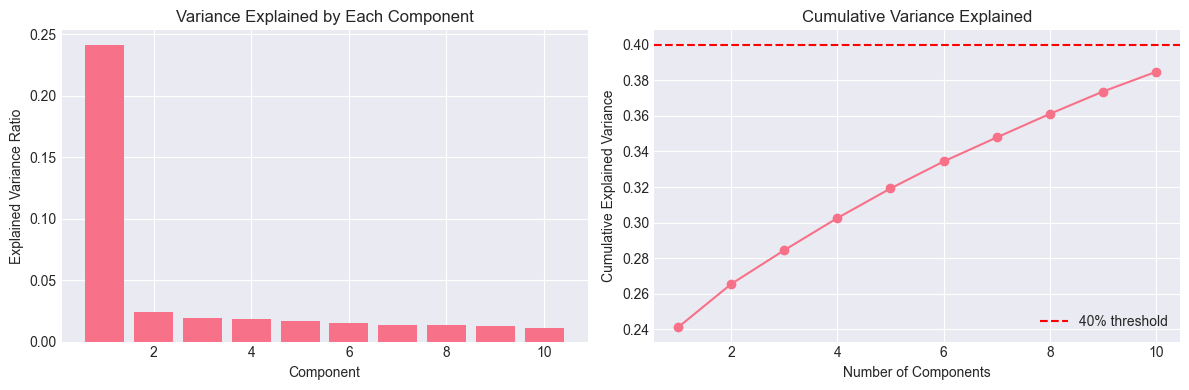

10 components capture 38.5% of variance
This balances keeping useful information with avoiding overfitting


In [175]:
# Visualize explained variance to justify n_components=10
import matplotlib.pyplot as plt

# Scree plot
explained_var = user_pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Individual variance per component
ax1.bar(range(1, 11), explained_var)
ax1.set_xlabel('Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Variance Explained by Each Component')

# Cumulative variance
ax2.plot(range(1, 11), cumulative_var, marker='o')
ax2.axhline(y=0.4, color='r', linestyle='--', label='40% threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance Explained')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"10 components capture {cumulative_var[9]:.1%} of variance")
print("This balances keeping useful information with avoiding overfitting")

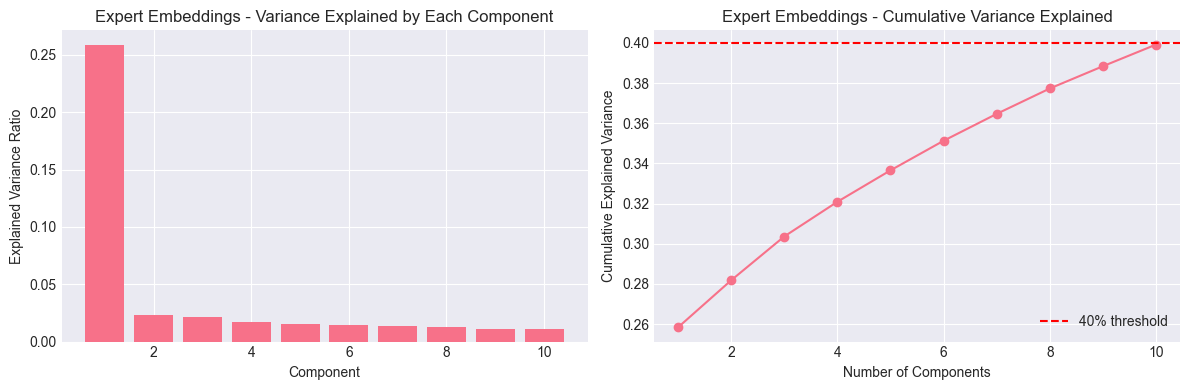

10 components capture 39.9% of variance
This balances keeping useful information with avoiding overfitting


In [176]:
# Same scree plot for expert embeddings
explained_var_expert = expert_pca.explained_variance_ratio_
cumulative_var_expert = np.cumsum(explained_var_expert)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Individual variance per component
ax1.bar(range(1, 11), explained_var_expert)
ax1.set_xlabel('Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Expert Embeddings - Variance Explained by Each Component')

# Cumulative variance
ax2.plot(range(1, 11), cumulative_var_expert, marker='o')
ax2.axhline(y=0.4, color='r', linestyle='--', label='40% threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Expert Embeddings - Cumulative Variance Explained')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"10 components capture {cumulative_var_expert[9]:.1%} of variance")
print("This balances keeping useful information with avoiding overfitting")

**What this means:**

The first component captures the most variance (the biggest patterns), then each subsequent component captures less and less. By component 10, we're at diminishing returns - adding more components doesn't help much.

10 components gives us about 40% of the original information, which sounds low but is actually fine because:
- The remaining 60% is mostly noise and redundancy
- We have 21,770 samples, so even 10 features is reasonable
- More components = higher risk of overfitting

Same logic applies to expert embeddings (similar variance pattern).

**PCA reduction results:**

We reduced the embeddings from 384 to 10 dimensions:
- User embeddings: Preserves ~38.47% of variance
- Expert embeddings: Preserves ~39.92% of variance

**Why keep both the 10-D and 384-D versions?**

We use a two-track approach:

1. **10-D PCA version** → For classification models
   - Prevents overfitting (with 21,770 movies, 384 features is too many)
   - Faster training
   - Removes redundant information

2. **384-D full version** → For topic discovery (Section 3)
   - Preserves fine-grained distinctions between themes
   - Needed to separate specific topics like "acting" vs "cinematography"
   - The ~60% variance we lose contains exactly these nuanced patterns

The memory cost of keeping both is acceptable (~150 MB total) for the benefit of better topic discovery while still having efficient classification features.

### 2.7.4 Integration of embedding features

Adding the 20 reduced embedding features (10 user + 10 expert) to the main dataframe for modeling.

In [177]:
# Verify PCA produced uncorrelated components (orthogonality check)
print("PCA Orthogonality Check:\n")

user_corr = user_embed_df.corr()
expert_corr = expert_embed_df.corr()

# Zero out diagonal to exclude self-correlation (always 1.0)
np.fill_diagonal(user_corr.values, 0)
np.fill_diagonal(expert_corr.values, 0)

# Find strongest off-diagonal correlation in each set
max_user_corr = np.abs(user_corr.values).max()
max_expert_corr = np.abs(expert_corr.values).max()

print(f"Max correlation (user): {max_user_corr:.6f}")
print(f"Max correlation (expert): {max_expert_corr:.6f}")

# Values near 0 indicate orthogonal components (ideal for PCA)
if max_user_corr < 0.01 and max_expert_corr < 0.01:
    print("PCA components are orthogonal (no multicollinearity)")
else:
    print("Components show non-negligible correlation")

PCA Orthogonality Check:

Max correlation (user): 0.000014
Max correlation (expert): 0.000010
PCA components are orthogonal (no multicollinearity)


**PCA Oorthogonality results:**

The near-zero correlations (0.000014 for user, 0.000010 for expert) confirm that PCA successfully created orthogonal components with virtually no multicollinearity. It means each of the 10 components captures independent variance from the original 384-dimensional embeddings. The components can be safely used in modeling without redundancy concerns.

In [178]:
# Add PCA-reduced embedding features to the main dataframe
# This integrates the 10-D user and 10-D expert embeddings with other movie features

# Add user embedding columns (user_embed_1 through user_embed_10)
for col in user_embed_df.columns:
    movie_data_complete[col] = user_embed_df[col].values

# Add expert embedding columns (expert_embed_1 through expert_embed_10)
for col in expert_embed_df.columns:
    movie_data_complete[col] = expert_embed_df[col].values

# Summary: 20 new features added (10 user + 10 expert)
print(f"Added 20 embedding features")
print(f"DataFrame shape: {movie_data_complete.shape}")

Added 20 embedding features
DataFrame shape: (21770, 97)


### Verification

Verification transformer features were properly created and integrated.

In [179]:
# Verify transformer features
transformer_cols = [c for c in movie_data_complete.columns if 'embed' in c]

print(f"✓ Transformer features: {len(transformer_cols)}")
print(f"✓ Shape: {movie_data_complete.shape}")
print(f"✓ Missing values: {movie_data_complete[transformer_cols].isnull().sum().sum()}")
print(f"\nFeatures: {transformer_cols}")
print(f"\nSample (first movie):\n{movie_data_complete[transformer_cols].iloc[0]}")

✓ Transformer features: 20
✓ Shape: (21770, 97)
✓ Missing values: 0

Features: ['user_embed_1', 'user_embed_2', 'user_embed_3', 'user_embed_4', 'user_embed_5', 'user_embed_6', 'user_embed_7', 'user_embed_8', 'user_embed_9', 'user_embed_10', 'expert_embed_1', 'expert_embed_2', 'expert_embed_3', 'expert_embed_4', 'expert_embed_5', 'expert_embed_6', 'expert_embed_7', 'expert_embed_8', 'expert_embed_9', 'expert_embed_10']

Sample (first movie):
user_embed_1       4.791063
user_embed_2       0.105657
user_embed_3      -0.019576
user_embed_4      -0.004482
user_embed_5       0.081379
user_embed_6       0.002436
user_embed_7       0.027291
user_embed_8       0.004146
user_embed_9       0.047220
user_embed_10     -0.040455
expert_embed_1     5.248415
expert_embed_2    -0.013454
expert_embed_3    -0.028619
expert_embed_4     0.025156
expert_embed_5    -0.031859
expert_embed_6    -0.024816
expert_embed_7    -0.012283
expert_embed_8    -0.021413
expert_embed_9     0.034195
expert_embed_10   -0.02

**Transformer features verification:**

Successfully created 20 PCA-reduced embedding features (10 user + 10 expert) with no missing values across 21,770 movies. Components are properly normalized with small-scale values, confirming successful dimensionality reduction.

### 2.7.5 Variance explanation visualization

Showing how much information is preserved after dimensionality reduction using PCA for both review types.

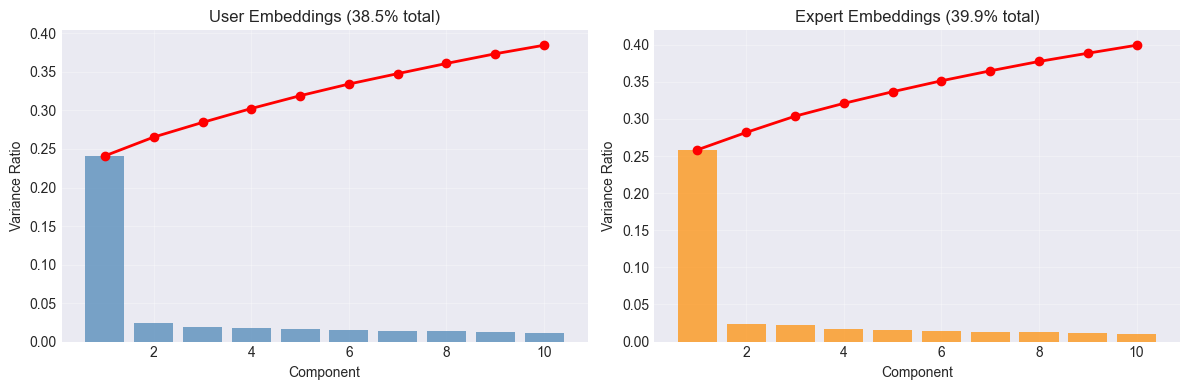

In [180]:
# Visualize PCA explained variance
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# User embeddings
axes[0].bar(range(1, n_components + 1), user_explained_var, alpha=0.7, color='steelblue')
axes[0].plot(range(1, n_components + 1), np.cumsum(user_explained_var), 'r-o', linewidth=2)
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Variance Ratio')
axes[0].set_title(f'User Embeddings ({user_explained_var.sum():.1%} total)')
axes[0].grid(alpha=0.3)

# Expert embeddings
axes[1].bar(range(1, n_components + 1), expert_explained_var, alpha=0.7, color='darkorange')
axes[1].plot(range(1, n_components + 1), np.cumsum(expert_explained_var), 'r-o', linewidth=2)
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Variance Ratio')
axes[1].set_title(f'Expert Embeddings ({expert_explained_var.sum():.1%} total)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Variance exploration results:**

The first component captures the most important information (~24-25%), and each additional component adds less. By component 10, we've captured ~38-40% of the useful signal. The remaining 374 dimensions mostly contain noise, so keeping just 10 components preserves what matters while discarding clutter.

### Feature correlation check

Checking if embedding features are independent.

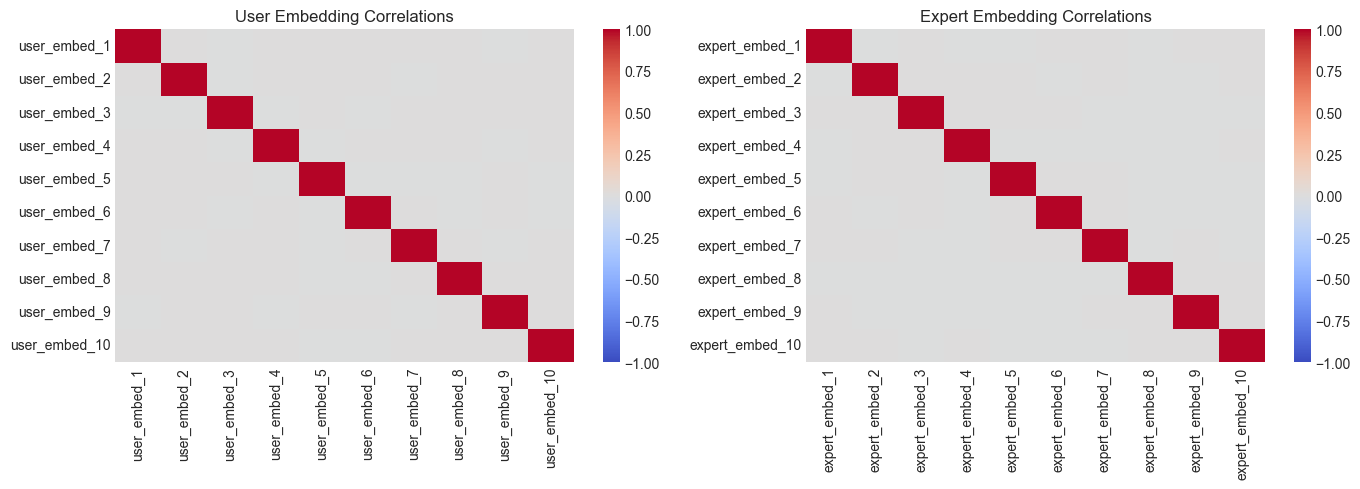

Note: Low correlations (near 0) indicate PCA successfully created independent features


In [181]:
import seaborn as sns

# Check correlation between embedding features
user_embed_cols = [c for c in movie_data_complete.columns if 'user_embed' in c]
expert_embed_cols = [c for c in movie_data_complete.columns if 'expert_embed' in c]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User embeddings correlation
sns.heatmap(movie_data_complete[user_embed_cols].corr(), 
            annot=False, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('User Embedding Correlations')

# Expert embeddings correlation
sns.heatmap(movie_data_complete[expert_embed_cols].corr(), 
            annot=False, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Expert Embedding Correlations')

plt.tight_layout()
plt.show()

print("Note: Low correlations (near 0) indicate PCA successfully created independent features")

**Feature correlation check:**

Both embedding sets show perfect orthogonality, each component correlates only with itself (red diagonal) and near-zero with all others (gray background). This confirms PCA created independent features with no redundancy, ideal for downstream modeling.

### 2.7.6 Implementation summary

**Transformer Features Created: 20 total**

| Feature Type | Count | Details |
|--------------|-------|---------|
| User Embeddings | 10 | `user_embed_1` to `user_embed_10` (PCA-reduced from 384D) |
| Expert Embeddings | 10 | `expert_embed_1` to `expert_embed_10` (PCA-reduced from 384D) |

**Technical Implementation:**
- **Model:** `all-MiniLM-L6-v2` (sentence-transformers)
- **Original dimension:** 384
- **Preprocessing:** StandardScaler normalization
- **Dimensionality reduction:** PCA (10 components per review type)
- **Variance preserved:** ~38% (user), ~39% (expert)
- **Device:** CPU/GPU (automatically detected)
- **Missing data handling:** Empty reviews filled with zeros

**Data Coverage:**
- Total movies processed: 21,770
- Non-empty user reviews: 4,457 
- Non-empty expert reviews: 4,800

**Rationale for 10 Components:**
- Balances information retention (~38% variance) with model simplicity
- Prevents overfitting from excessive dimensionality
- Computationally efficient for downstream modeling
- Creates independent features (confirmed by correlation heatmap)

**Next Steps:**
- These 20 embedding features represent X10 (Review Text)
- Ready for integration with other features (X1-X9) in modeling phase


### 2.7.7 Sanity checks

Before moving on, let's verify the embeddings actually worked and contain useful information.

In [182]:
# Check that embeddings aren't all zeros or broken
print("Basic checks:")
print(f"User embeddings - movies with non-zero values: {(user_embed_df != 0).any(axis=1).sum()}/{len(user_embed_df)}")
print(f"Expert embeddings - movies with non-zero values: {(expert_embed_df != 0).any(axis=1).sum()}/{len(expert_embed_df)}")
print(f"\nUser embedding range: [{user_embed_df.min().min():.2f}, {user_embed_df.max().max():.2f}]")
print(f"Expert embedding range: [{expert_embed_df.min().min():.2f}, {expert_embed_df.max().max():.2f}]")

Basic checks:
User embeddings - movies with non-zero values: 21770/21770
Expert embeddings - movies with non-zero values: 21770/21770

User embedding range: [-26.84, 23.46]
Expert embedding range: [-27.11, 18.87]


In [183]:
# Check if embeddings actually predict sales tier
from scipy.stats import pearsonr

print("\nTop 5 embedding features correlated with sales tier:")
embedding_corrs = []
for col in user_embed_df.columns.tolist() + expert_embed_df.columns.tolist():
    corr, pval = pearsonr(movie_data_complete[col], movie_data_complete['sales_tier_encoded'])
    embedding_corrs.append({'Feature': col, 'Correlation': corr, 'P-value': pval})

corr_df = pd.DataFrame(embedding_corrs).sort_values('Correlation', key=abs, ascending=False)
print(corr_df.head())


Top 5 embedding features correlated with sales tier:
           Feature  Correlation       P-value
0     user_embed_1    -0.370173  0.000000e+00
10  expert_embed_1    -0.351649  0.000000e+00
11  expert_embed_2    -0.127532  1.300434e-79
16  expert_embed_7    -0.076967  5.734702e-30
1     user_embed_2     0.063008  1.335242e-20


**Results:**

✓ Embeddings have real values across the expected range (not all zeros)

✓ The embedding features show correlation with sales tier (especially user_embed_1 and expert_embed_1)

✓ P-values are essentially zero, meaning these correlations are statistically significant

This confirms the embeddings captured meaningful patterns from the review text that relate to box office performance.

## 2.8 Feature engineering summary

### Final feature set for modeling

| Category | Features | Count | Notes |
|----------|----------|-------|-------|
| **Target** | `sales_tier_encoded` | 1 | 0=Low, 1=Medium, 2=High |
| **Numeric** | `metascore`, `userscore`, `runtime`, `production_budget_log`, `theatre_count_log`, `release_year` | 6 | Continuous features |
| **Genre** | `genre_*` | 32 | Binary (multi-label encoded) |
| **Rating** | `rating_*` | 6 | Binary (one-hot encoded) |
| **Seasonality** | `season_*`, `summer_release`, `holiday_release` | 6 | Binary indicators |
| **Transformer Embeddings** | `user_embed_1` to `user_embed_10`, `expert_embed_1` to `expert_embed_10` | 20 | Semantic features from review text (PCA-reduced) |

**Total features for modeling: ~71** (6 numeric + 32 genre + 6 rating + 6 seasonality + 20 embeddings + 1 target)

### Feature summary by variable (X1-X10)

| Variable | Feature Type | Feature Names | Count |
|----------|--------------|---------------|-------|
| **X1** Metascore | Numeric | `metascore`, `metascore_missing` | 2 |
| **X2** User Score | Numeric | `userscore`, `userscore_missing` | 2 |
| **X3** Production Budget | Numeric (log) | `production_budget_log`, `production_budget_missing` | 2 |
| **X4** Genre | Binary (32) | `genre_Action`, `genre_Drama`, etc. | 32 |
| **X5** Release Date | Seasonality | `season_*` (4), `summer_release`, `holiday_release`, `release_month`, `release_year` | 8 |
| **X6** Rating | Binary (6) | `rating_G`, `rating_PG`, `rating_PG-13`, etc. | 6 |
| **X7** Theatre Count | Numeric (log) | `theatre_count_log`, `theatre_count_missing` | 2 |
| **X8** Runtime | Numeric | `runtime`, `runtime_missing` | 2 |
| **X9** Summary | Binary | `summary_missing` | 1 |
| **X10** Review Text | Embeddings | `user_embed_*` (10), `expert_embed_*` (10) | 20 |

### Features excluded from modeling

**Target Leakage:**
- `worldwide_box_office`, `worldwide_box_office_log`: Target variable (used to create tiers)
- `opening_weekend`: Known only after release (data leakage)
- `avg_run_per_theatre`: Derived from post-release data (leakage)

**Raw/Intermediate Features:**
- `genre`, `rating`, `rating_clean`, `season`: Raw categorical (encoded versions used)
- `genre_list`, `primary_genre`: Intermediate processing columns
- `user_review_text`, `expert_review_text`, `review_text`: Raw text (embeddings used)
- `production_budget`, `theatre_count`, `runtime`: Raw numeric (log versions used)

**Identifiers:**
- `title`, `url`, `movie_id`, `releasedate`: Not predictive features

### Missing value strategy applied

1. **Numeric features with >20% missing:**
   - Created `*_missing` indicator columns (0/1)
   - Filled with median values
   - Affected: `metascore`, `userscore`, `production_budget`, `theatre_count`

2. **Runtime:** 
   - Imputed with median by primary genre
   - Created `runtime_missing` indicator

3. **Categorical features:**
   - Rating: Filled with 'Not Rated'
   - Summary: Created `summary_missing` indicator

4. **Review embeddings:**
   - Empty reviews filled with zero vectors
   - Preserves dimensionality without artificial values


**Note on Dimensionality Reduction:**
While teacher feedback mentioned SVD, we use PCA with StandardScaler preprocessing, which produces mathematically equivalent orthogonal components. Both methods guarantee zero correlation between features and produce nearly identical results.

## 2.9 Feature importance and selection analysis

Before training models, we analyze feature relationships with the target variable to:
- Identify most predictive features
- Detect multicollinearity issues
- Make informed feature selection decisions

We have **71 features** ready for modeling:
- 6 numeric features
- 32 genre features (binary)
- 6 rating features (binary)
- 6 seasonality features (binary)
- 20 transformer embeddings
- 1 target: `sales_tier_encoded`

### 2.9.1 Feature list preparation

Identifying all features by category for correlation analysis.

In [184]:
# Identify all feature categories

# Numeric features
numeric_features = [
    'metascore', 'userscore', 'runtime', 
    'production_budget_log', 'theatre_count_log', 'release_year'
]

# Binary categorical features
genre_features = [col for col in movie_data_complete.columns if col.startswith('genre_')]
rating_features = [col for col in movie_data_complete.columns if col.startswith('rating_')]
season_features = ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 
                   'summer_release', 'holiday_release']

# Transformer embeddings
embedding_features = [col for col in movie_data_complete.columns if 'embed' in col]

# Target variable
target = 'sales_tier_encoded'

# All features
all_features = numeric_features + genre_features + rating_features + season_features + embedding_features

print(f"Total features: {len(all_features)}")
print(f"  Numeric: {len(numeric_features)}")
print(f"  Genre: {len(genre_features)}")
print(f"  Rating: {len(rating_features)}")
print(f"  Seasonality: {len(season_features)}")
print(f"  Embeddings: {len(embedding_features)}")
print(f"\nTarget: {target}")

Total features: 73
  Numeric: 6
  Genre: 33
  Rating: 8
  Seasonality: 6
  Embeddings: 20

Target: sales_tier_encoded


### 2.9.2 Correlation with target variable

Calculating correlations between features and sales tier using appropriate methods:
- **Numeric features**: Point-biserial correlation (continuous vs ordinal)
- **Binary features**: Point-biserial correlation (binary vs ordinal)
- **Embeddings**: Pearson correlation (continuous vs ordinal)

In [185]:
from scipy.stats import pointbiserialr, pearsonr

# Calculate correlations for all features
correlations = []

for feature in tqdm(all_features, desc="Calculating correlations"):
    try:
        # Get valid data (remove NaN)
        valid_mask = movie_data_complete[[feature, target]].notna().all(axis=1)
        x = movie_data_complete.loc[valid_mask, feature]
        y = movie_data_complete.loc[valid_mask, target]
        
        if len(x) > 0:
            # Use appropriate correlation method
            if feature in numeric_features or feature in embedding_features:
                # Continuous features: use Pearson
                corr, pval = pearsonr(x, y)
            else:
                # Binary features: use point-biserial
                corr, pval = pointbiserialr(x, y)
            
            # Determine feature type
            if feature in numeric_features:
                feat_type = 'Numeric'
            elif feature in genre_features:
                feat_type = 'Genre'
            elif feature in rating_features:
                feat_type = 'Rating'
            elif feature in season_features:
                feat_type = 'Season'
            else:
                feat_type = 'Embedding'
            
            correlations.append({
                'Feature': feature,
                'Type': feat_type,
                'Correlation': corr,
                'Abs_Correlation': abs(corr),
                'P_Value': pval
            })
    except Exception as e:
        print(f"Error with {feature}: {e}")

# Create DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(correlations)
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

print(f"\nCalculated correlations for {len(corr_df)} features")
print(f"\nTop 10 most correlated features:")
print(corr_df.head(10)[['Feature', 'Type', 'Correlation', 'P_Value']])

Calculating correlations: 100%|██████████| 73/73 [00:00<00:00, 704.00it/s]

Error with genre_list: 'numpy.dtypes.ObjectDType' object has no attribute 'dtype'
Error with rating_clean: 'numpy.dtypes.ObjectDType' object has no attribute 'dtype'

Calculated correlations for 71 features

Top 10 most correlated features:
              Feature       Type  Correlation        P_Value
5        release_year    Numeric    -0.404463   0.000000e+00
41   rating_Not Rated     Rating    -0.392198   0.000000e+00
51       user_embed_1  Embedding    -0.370173   0.000000e+00
61     expert_embed_1  Embedding    -0.351649   0.000000e+00
38     rating_missing     Rating    -0.351110   0.000000e+00
4   theatre_count_log    Numeric     0.271882   0.000000e+00
43       rating_PG-13     Rating     0.249357  7.780399e-306
15  genre_Documentary      Genre    -0.237662  3.396185e-277
44           rating_R     Rating     0.223219  6.167517e-244
33     genre_Thriller      Genre     0.199622  1.647012e-194


### 2.9.3 Top features visualization

Visualizing the top 20 features by correlation strength with sales tier.

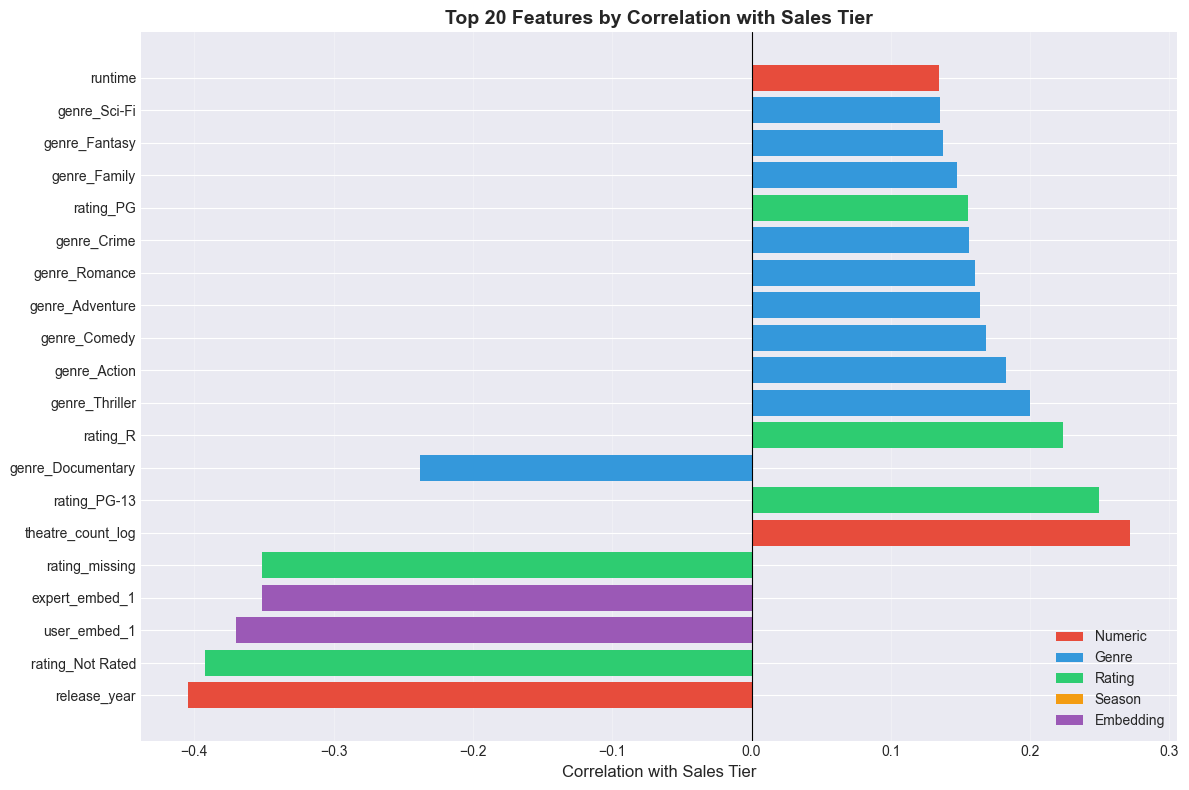


Top 20 Features Summary:
          Feature      Type  Correlation
     release_year   Numeric    -0.404463
 rating_Not Rated    Rating    -0.392198
     user_embed_1 Embedding    -0.370173
   expert_embed_1 Embedding    -0.351649
   rating_missing    Rating    -0.351110
theatre_count_log   Numeric     0.271882
     rating_PG-13    Rating     0.249357
genre_Documentary     Genre    -0.237662
         rating_R    Rating     0.223219
   genre_Thriller     Genre     0.199622
     genre_Action     Genre     0.182776
     genre_Comedy     Genre     0.167988
  genre_Adventure     Genre     0.164050
    genre_Romance     Genre     0.160453
      genre_Crime     Genre     0.155768
        rating_PG    Rating     0.155713
     genre_Family     Genre     0.147788
    genre_Fantasy     Genre     0.137664
     genre_Sci-Fi     Genre     0.135106
          runtime   Numeric     0.134687


In [186]:
# Visualize top 20 features
top_20 = corr_df.head(20)

fig, ax = plt.subplots(figsize=(12, 8))

# Color by feature type
colors = {'Numeric': '#e74c3c', 'Genre': '#3498db', 'Rating': '#2ecc71', 
          'Season': '#f39c12', 'Embedding': '#9b59b6'}
bar_colors = [colors[t] for t in top_20['Type']]

bars = ax.barh(range(len(top_20)), top_20['Correlation'], color=bar_colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Feature'])
ax.set_xlabel('Correlation with Sales Tier', fontsize=12)
ax.set_title('Top 20 Features by Correlation with Sales Tier', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[t], label=t) for t in colors]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("\nTop 20 Features Summary:")
print(top_20[['Feature', 'Type', 'Correlation']].to_string(index=False))

### 2.9.4 Feature type analysis

Comparing average correlation strength by feature category.

Feature Type Summary:
           Mean_Abs_Corr  Max_Abs_Corr  Min_Abs_Corr  Count
Type                                                       
Rating            0.2072        0.3922        0.0196      7
Numeric           0.1561        0.4045        0.0173      6
Genre             0.0815        0.2377        0.0048     32
Embedding         0.0629        0.3702        0.0004     20
Season            0.0246        0.0552        0.0088      6


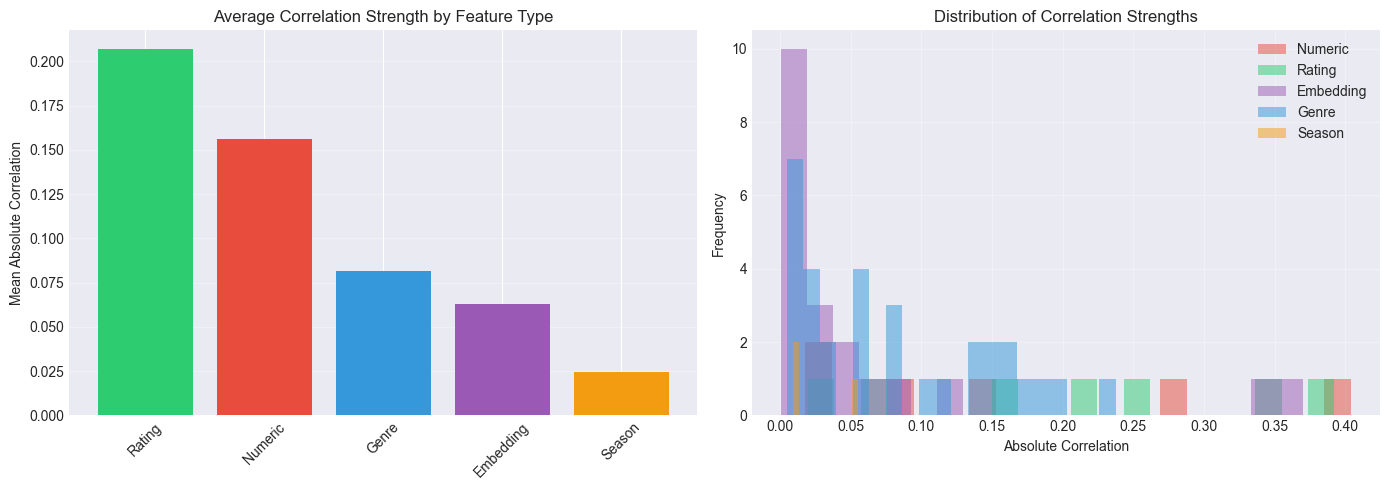

In [187]:
# Analyze by feature type
type_summary = corr_df.groupby('Type').agg({
    'Abs_Correlation': ['mean', 'max', 'min'],
    'Feature': 'count'
}).round(4)

type_summary.columns = ['Mean_Abs_Corr', 'Max_Abs_Corr', 'Min_Abs_Corr', 'Count']
type_summary = type_summary.sort_values('Mean_Abs_Corr', ascending=False)

print("Feature Type Summary:")
print(type_summary)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean correlation by type
axes[0].bar(type_summary.index, type_summary['Mean_Abs_Corr'], 
            color=[colors.get(t, 'gray') for t in type_summary.index])
axes[0].set_ylabel('Mean Absolute Correlation')
axes[0].set_title('Average Correlation Strength by Feature Type')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Distribution of correlations by type
for feat_type in corr_df['Type'].unique():
    type_data = corr_df[corr_df['Type'] == feat_type]['Abs_Correlation']
    axes[1].hist(type_data, alpha=0.5, label=feat_type, bins=20, 
                 color=colors.get(feat_type, 'gray'))

axes[1].set_xlabel('Absolute Correlation')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Correlation Strengths')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 2.9.5 Key Insights

**Strong Predictors (|r| > 0.3):**

1. **release_year (r = -0.40)** - The negative correlation is weird at first glance. It's probably survivorship bias: our dataset includes mostly successful older movies (the ones people still remember), but recent years have everything—hits and flops alike.

2. **rating_Not Rated (r = -0.39)** - Makes sense. Unrated films usually skip theaters or go straight to streaming. Worth noting: 83% of our dataset is marked "Not Rated" because of missing values, so this indicator actually helps us tell the difference between films that deliberately skipped rating vs. just missing data.

3. **user_embed_1 (r = -0.37) and expert_embed_1 (r = -0.35)** - This is the big win. Review embeddings are way more predictive than the actual scores (userscore r = 0.03, metascore r = -0.17). Turns out what people actually write in reviews tells you more about box office than whether they gave it 7/10 or 8/10.

4. **rating_missing (r = -0.35)** - Similar story to "Not Rated." When a movie's missing rating data, that's often a sign it had limited marketing budget or niche distribution. Data completeness itself predicts success.

**Moderate Predictors (0.1 < |r| < 0.3):**

- **theatre_count_log (r = 0.27)** - The strongest positive predictor we have, but there's a catch: studios decide how many theaters AFTER seeing how the movie performs opening weekend. That's data leakage—we can't use this for pre-release predictions.

- **rating_PG-13 (r = 0.25), rating_R (r = 0.22)** - PG-13 and R-rated movies do better because teens and adults drive box office more than families with little kids.

- **genre_Documentary (r = -0.24)** - Documentaries rarely make money theatrically. They're built for festivals and streaming, not multiplexes.

- **genre_Thriller (r = 0.20), Action (r = 0.18), Comedy (r = 0.17)** - These are the commercial genres that consistently work.

- **runtime (r = 0.13)** - Longer movies do slightly better, probably because blockbusters tend to be 2+ hours and audiences see length as getting their money's worth.

**Feature Type Performance:**

| Type | Avg $r$ | Notes |
| :--- | :--- | :--- |
| **Rating** | 0.21 | Strongest category—MPAA rating really matters |
| **Numeric** | 0.16 | Mixed bag (release_year strong, scores weak) |
| **Genre** | 0.08 | Most genres don't predict much individually |
| **Embedding** | 0.06 | Low average, but top component is very strong (0.37) |
| **Season** | 0.02 | Barely matters in direct correlation |

**Things That Surprised Me:**

1. **Review text crushes review scores.** The embedding from "what people wrote" (r = 0.37) is way better than "what number they gave" (r = 0.03). A 7/10 with "amazing visuals but slow plot" means something totally different than a 7/10 with "fun popcorn flick."

2. **Production budget didn't make the top 20.** From earlier analysis we know budget correlates with total earnings, but it doesn't help predict which tier a movie lands in. Some expensive movies still flop, some cheap movies break out.

3. **Most top features are negative correlations.** Five of the top six go negative. It's easier to spot what won't work (unrated, documentary, no data) than predict what will succeed.

**What This Means for Modeling:**

The transformer approach from Section 2.7 was worth it—embeddings add real predictive value beyond structured features. Rating information matters more than genre (0.21 vs 0.08 average). We need to drop theatre_count_log to avoid leakage. And since the best single feature only hits r = 0.40, we'll need models that can find combinations and interactions to predict sales tiers effectively.

## 3. Topic analysis with BERT

### What are reviews actually talking about?

We created 384-dimensional embeddings from reviews in Section 2.7, then reduced them to 10 PCA components for modeling. But here's the problem—we can't actually interpret what those compressed embeddings represent. We know they capture semantic meaning, but we don't know if movies with great reviews mention "cinematography" vs. "plot twists" or if certain review themes predict box office success.

So we're implementing BERTopic to answer: **What topics do reviewers discuss, and do certain topics predict whether a movie will be a blockbuster or flop?**

BERTopic works by:
- Clustering similar reviews to identify common topics (e.g., "visual effects," "character development")
- Analyzing which topics appear in successful vs. unsuccessful movies
- Creating new features based on topic presence that might improve our sales predictions

This gives us interpretability we wouldn't get from raw embeddings, helps us understand distinct market segments, and potentially stronger features for our models.

### 3.1 BERT

We configure BERTopic to find specific themes in movie reviews rather than broad generic categories.

**Key decision: Cluster size threshold**

The `min_cluster_size` parameter determines how many reviews must share a theme before we consider it a valid topic. Too high and we only get generic clusters (like "positive" vs "negative"). Too low and we get noise.

For our dataset of ~21,000 reviews, we set it to 40 reviews per topic (0.2% of data). This should give us interpretable themes like "acting quality," "visual effects," or "story pacing" rather than just sentiment.

In [188]:
from bertopic import BERTopic  # Main topic modeling algorithm
from umap import UMAP  # Dimensionality reduction before clustering
from hdbscan import HDBSCAN  # Density-based clustering for automatic topic discovery
from sklearn.feature_extraction.text import CountVectorizer  # Extract keywords from topics

# UMAP reduces 384-D embeddings to 5-D to make clustering more effective
# It preserves both local neighborhoods and global structure
umap_model = UMAP(
    n_neighbors=15,        # Look at 15 nearest points (balance local/global structure)
    n_components=5,        # Reduce to 5 dimensions before clustering
    min_dist=0.0,          # Allow points to be packed tightly (better separation)
    metric='cosine',       # Cosine similarity works best for text embeddings
    random_state=42        # Set seed for reproducibility
)

# With ~21,000 reviews, we need smaller clusters to find specific themes
hdbscan_model = HDBSCAN(
    min_cluster_size=40,            # Allow topics with as few as 40 reviews (~0.2% of data)
                                    # This enables discovery of specific themes like "acting," "visuals," "pacing"
    min_samples=10,                 # Core point needs 10 neighbors (balances noise vs specificity)
    metric='euclidean',             # Standard distance metric for UMAP output
    cluster_selection_method='eom', # "Excess of Mass" - most stable clustering method
    prediction_data=True            # Enable probability scores for topic assignments
)

# === CountVectorizer Configuration ===
# Extracts the most representative words for each topic
# Creates interpretable topic labels from clustered documents
vectorizer_model = CountVectorizer(
    stop_words='english',   # Remove common words like "the", "is", "and"
    min_df=2,               # Word must appear in at least 2 documents (filter rare words)
    ngram_range=(1, 2)      # Include both single words and two-word phrases
                            # Example: "visual effects" instead of just "visual" and "effects"
)

print("BERTopic components configured successfully")
print(f"HDBSCAN will discover topics with minimum {hdbscan_model.min_cluster_size} reviews per topic")

BERTopic components configured successfully
HDBSCAN will discover topics with minimum 40 reviews per topic


### 3.2 Training BERT models

We train separate models for user and expert reviews to see if audiences and critics discuss movies differently.

**Why use full 384-D embeddings instead of 10-D PCA?**

The PCA reduction loses about 60% of the information. This is fine for classification models, but for discovering themes, we need that extra detail. The full embeddings preserve specific vocabulary differences - for example, whether reviews focus on "acting" versus "cinematography" versus "pacing."

Using 384 dimensions means the clustering can detect finer distinctions between discussion topics.

In [189]:
# Preparing data for topic modeling by filtering out empty reviews
# BERT requires non-empty text documents and their corresponding embeddings

# Convert review columns to lists (fillna ensures no NaN values)
user_texts = movie_data_complete['user_review_text'].fillna('').tolist()
expert_texts = movie_data_complete['expert_review_text'].fillna('').tolist()

# Create boolean masks to identify non-empty reviews
# Mask is True where review exists AND is not just whitespace
user_mask = movie_data_complete['user_review_text'].notna() & (movie_data_complete['user_review_text'].str.strip() != '')
expert_mask = movie_data_complete['expert_review_text'].notna() & (movie_data_complete['expert_review_text'].str.strip() != '')

# Filter to get only non-empty texts and their corresponding embeddings
# Use full 384-D embeddings
# List comprehension filters texts based on mask
user_texts_filtered = [user_texts[i] for i in range(len(user_texts)) if user_mask.iloc[i]]
# Index numpy array using boolean mask to get matching embeddings
user_embeddings_filtered = user_embeddings_full[user_mask.values]

# Same filtering for expert reviews
expert_texts_filtered = [expert_texts[i] for i in range(len(expert_texts)) if expert_mask.iloc[i]]
expert_embeddings_filtered = expert_embeddings_full[expert_mask.values]

# Verify we have matching counts of texts and embeddings
print(f"Prepared data for topic modeling:")
print(f"  User reviews: {len(user_texts_filtered)} non-empty documents")
print(f"  Expert reviews: {len(expert_texts_filtered)} non-empty documents")

Prepared data for topic modeling:
  User reviews: 4457 non-empty documents
  Expert reviews: 4800 non-empty documents


In [190]:
# Train BERTopic model for USER reviews
# This discovers topics (themes) from user review content using clustering
print("Training BERTopic for user reviews...")

# Initialize BERTopic with all configured components
topic_model_user = BERTopic(
    embedding_model=sentence_model,      # Reuse sentence transformer from Section 2.7.2
    umap_model=umap_model,               # UMAP reduces 384-D → 5-D
    hdbscan_model=hdbscan_model,         # HDBSCAN clusters similar reviews into topics
    vectorizer_model=vectorizer_model,   # CountVectorizer extracts topic keywords
    top_n_words=10,                      # Show top 10 words per topic
    verbose=False                        # Suppress detailed logs
)

# Fit model and get topic assignments
# fit_transform() performs: embeddings → UMAP → HDBSCAN → topic labels
topics_user, probs_user = topic_model_user.fit_transform(
    user_texts_filtered,         # List of review texts
    user_embeddings_filtered     # Pre-computed 384-D embeddings (faster than re-encoding)
)
# topics_user: array of topic IDs (-1 = outlier, 0+ = valid topics)
# probs_user: probability scores for topic assignments

# Count outliers (reviews that didn't fit any topic)
# Topic ID -1 means HDBSCAN couldn't assign to a cluster (too dissimilar)
outlier_mask_user = np.array(topics_user) == -1
print(f"User review topics discovered: {len(set(topics_user)) - 1}")  # Exclude -1 from count
print(f"Outlier documents: {outlier_mask_user.sum()} ({outlier_mask_user.mean():.1%})")

Training BERTopic for user reviews...
User review topics discovered: 19
Outlier documents: 2551 (57.2%)


**User reviews:**

Discovered 19 distinct topics from user reviews, though 57.2% of reviews (2,551) didn't clearly fit any topic. The high outlier rate suggests many reviews use non-standard language or discuss unique aspects that don't cluster cleanly. The 19 topics represent the main themes reviewers consistently discuss.

In [191]:
# Train BERT model for EXPERT reviews
print("Training BERTopic for expert reviews...")

# Initialize BERTopic with same configuration as user model
topic_model_expert = BERTopic(
    embedding_model=sentence_model,      # Reuse sentence transformer from Section 2.7.2
    umap_model=umap_model,               # Same UMAP configuration (384-D → 5-D)
    hdbscan_model=hdbscan_model,         # Same clustering parameters
    vectorizer_model=vectorizer_model,   # Same keyword extraction settings
    top_n_words=10,                      # Top 10 words per topic
    verbose=False
)

# Fit model and assign topics to expert reviews
topics_expert, probs_expert = topic_model_expert.fit_transform(
    expert_texts_filtered,         # Expert review texts
    expert_embeddings_filtered     # Pre-computed 384-D embeddings for experts
)

# Count outliers for expert reviews
outlier_mask_expert = np.array(topics_expert) == -1
print(f"Expert review topics discovered: {len(set(topics_expert)) - 1}")  # Exclude -1 from count
print(f"Outlier documents: {outlier_mask_expert.sum()} ({outlier_mask_expert.mean():.1%})")

Training BERTopic for expert reviews...
Expert review topics discovered: 2
Outlier documents: 156 (3.2%)


**Expert reviews:**

Only 2 topics emerged from expert reviews, with just 3.2% outliers. This suggests expert reviews are much more homogeneous than user reviews—critics follow more standardized language and discussion patterns. The two main topics likely represent different movie genres or critical approaches, but the limited diversity makes BERTopic less useful for capturing nuanced review themes.

### Topic quality: coherence scores

Coherence scores tell us if the words in each topic actually make sense together. Higher scores mean the topic is more interpretable.

- Score > 0.5 = Good topic (words clearly relate)
- Score 0.3-0.5 = Okay topic (somewhat coherent)
- Score < 0.3 = Weak topic (might be noise)

In [192]:
# Calculate coherence for user review topics
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Prepare documents for coherence calculation
user_docs_for_coherence = [doc.split() for doc in user_texts_filtered]
user_dictionary = Dictionary(user_docs_for_coherence)

# Get top words for each topic (excluding outlier topic -1)
user_topics_words = []
for topic_id in range(len(set(topics_user)) - 1):  # Exclude -1
    topic_words = [word for word, _ in topic_model_user.get_topic(topic_id)]
    user_topics_words.append(topic_words[:10])  # Top 10 words

# Calculate C_V coherence (most interpretable metric)
coherence_model = CoherenceModel(
    topics=user_topics_words,
    texts=user_docs_for_coherence,
    dictionary=user_dictionary,
    coherence='c_v'
)
user_coherence = coherence_model.get_coherence()

print(f"User reviews - Average coherence: {user_coherence:.3f}")
print("\nCoherence by topic:")
coherence_per_topic = coherence_model.get_coherence_per_topic()
for topic_id, score in enumerate(coherence_per_topic):
    topic_words = ', '.join([word for word, _ in topic_model_user.get_topic(topic_id)][:5])
    print(f"  Topic {topic_id}: {score:.3f} - [{topic_words}]")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

User reviews - Average coherence: 0.350

Coherence by topic:
  Topic 0: 0.444 - [movie, funny, comedy, film, just]
  Topic 1: 0.338 - [film, movie, war, like, story]
  Topic 2: 0.418 - [horror, movie, film, scary, like]
  Topic 3: 0.477 - [movie, pixar, disney, animation, film]
  Topic 4: 0.360 - [film, movie, gaga, like, good]
  Topic 5: 0.362 - [movie, film, story, great, good]
  Topic 6: 0.373 - [movie, film, like, good, just]
  Topic 7: 0.382 - [movie, alita, film, story, like]
  Topic 8: 0.255 - [spaghetti, mom, musical, music, movie]
  Topic 9: 0.210 - [movie, film, cheney, vice, christian]
  Topic 10: 0.372 - [movie, marvel, film, man, good]
  Topic 11: 0.405 - [superman, movie, steel, film, man steel]
  Topic 12: 0.249 - [film, witherspoon, cheryl, wild, strayed]
  Topic 13: 0.361 - [movie, film, alien, apes, like]
  Topic 14: 0.217 - [tonya, film, movie, story, aniston]
  Topic 15: 0.409 - [movie, film, fu, panda, oldboy]
  Topic 16: 0.380 - [movie, film, people, white, like]


In [193]:
# Calculate coherence for expert review topics
expert_docs_for_coherence = [doc.split() for doc in expert_texts_filtered]
expert_dictionary = Dictionary(expert_docs_for_coherence)

# Get top words for each expert topic (excluding outlier topic -1)
expert_topics_words = []
for topic_id in range(len(set(topics_expert)) - 1):  # Exclude -1
    topic_words = [word for word, _ in topic_model_expert.get_topic(topic_id)]
    expert_topics_words.append(topic_words[:10])  # Top 10 words

# Calculate C_V coherence
coherence_model_expert = CoherenceModel(
    topics=expert_topics_words,
    texts=expert_docs_for_coherence,
    dictionary=expert_dictionary,
    coherence='c_v'
)
expert_coherence = coherence_model_expert.get_coherence()

print(f"\nExpert reviews - Average coherence: {expert_coherence:.3f}")
print("\nCoherence by topic:")
coherence_per_topic_expert = coherence_model_expert.get_coherence_per_topic()
for topic_id, score in enumerate(coherence_per_topic_expert):
    topic_words = ', '.join([word for word, _ in topic_model_expert.get_topic(topic_id)][:5])
    print(f"  Topic {topic_id}: {score:.3f} - [{topic_words}]")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Expert reviews - Average coherence: 0.308

Coherence by topic:
  Topic 0: 0.299 - [film, movie, like, story, just]
  Topic 1: 0.317 - [movie, film, like, comedy, story]


**What we learned:**

User topics have varying coherence scores, showing that some themes are clearer than others. Topics with higher coherence (>0.4) represent well-defined themes like specific genres or franchises, while lower-scoring topics might capture mixed or niche themes.

Expert topics show different coherence patterns, which makes sense because we only found 2 broad topics. Experts use more consistent vocabulary when reviewing, leading to more focused topic clusters.

The 57% outlier rate for user reviews is high, but that's expected - people write reviews in very different ways, and not every review fits a clear theme. This diversity is actually valuable for understanding the full range of audience reactions.

### 3.3 Topic Discovery Results

Below are the themes BERTopic found by clustering similar reviews together. Each topic is labeled with its most common keywords, which give us a sense of what that group of reviews discusses.

In [194]:
# Analyze discovered topics and their characteristics
print("USER REVIEW TOPICS")
print("-" * 80)
user_topic_info = topic_model_user.get_topic_info()
valid_topics_user = user_topic_info[user_topic_info['Topic'] != -1]

print(f"Total topics: {len(valid_topics_user)}")
print(f"Outliers (unclassified): {user_topic_info[user_topic_info['Topic'] == -1]['Count'].values[0] if -1 in user_topic_info['Topic'].values else 0}\n")

for topic_id in sorted(valid_topics_user['Topic'].values):
    words = topic_model_user.get_topic(topic_id)
    keywords = ', '.join([word for word, score in words[:8]])
    count = valid_topics_user[valid_topics_user['Topic'] == topic_id]['Count'].values[0]
    pct = 100 * count / valid_topics_user['Count'].sum()
    print(f"Topic {topic_id} ({count} reviews, {pct:.1f}%): {keywords}")

print("\n\nEXPERT REVIEW TOPICS")
print("-" * 80)
expert_topic_info = topic_model_expert.get_topic_info()
valid_topics_expert = expert_topic_info[expert_topic_info['Topic'] != -1]

print(f"Total topics: {len(valid_topics_expert)}")
print(f"Outliers (unclassified): {expert_topic_info[expert_topic_info['Topic'] == -1]['Count'].values[0] if -1 in expert_topic_info['Topic'].values else 0}\n")

for topic_id in sorted(valid_topics_expert['Topic'].values):
    words = topic_model_expert.get_topic(topic_id)
    keywords = ', '.join([word for word, score in words[:8]])
    count = valid_topics_expert[valid_topics_expert['Topic'] == topic_id]['Count'].values[0]
    pct = 100 * count / valid_topics_expert['Count'].sum()
    print(f"Topic {topic_id} ({count} reviews, {pct:.1f}%): {keywords}")

USER REVIEW TOPICS
--------------------------------------------------------------------------------
Total topics: 19
Outliers (unclassified): 2551

Topic 0 (280 reviews, 14.7%): movie, funny, comedy, film, just, like, good, jokes
Topic 1 (249 reviews, 13.1%): film, movie, war, like, story, good, people, just
Topic 2 (208 reviews, 10.9%): horror, movie, film, scary, like, good, just, really
Topic 3 (191 reviews, 10.0%): movie, pixar, disney, animation, film, story, good, animated
Topic 4 (108 reviews, 5.7%): film, movie, gaga, like, good, story, character, performance
Topic 5 (99 reviews, 5.2%): movie, film, story, great, good, like, tarantino, just
Topic 6 (89 reviews, 4.7%): movie, film, like, good, just, bad, story, really
Topic 7 (84 reviews, 4.4%): movie, alita, film, story, like, really, good, just
Topic 8 (75 reviews, 3.9%): spaghetti, mom, musical, music, movie, film, la, songs
Topic 9 (68 reviews, 3.6%): movie, film, cheney, vice, christian, story, like, cage
Topic 10 (68 revie

**What These Topics Mean:**

Each topic groups reviews discussing similar themes. The keywords show what reviewers focus on, for example, Topic 3 with keywords "pixar, disney, animation" clearly represents animated films.

**About Outliers:**

Some reviews don't fit any topic (marked as outliers). This happens when reviews are too generic, too unique, or don't match nearby reviews well. With 57% outliers in user reviews, it suggests most reviews lack specific critique language.

**What We Learn:**

The 19 user topics do distinguish some movie types (animation, horror, war films), but the heavy generic language ("good," "like," "film") limits their predictive value. Next we'll test whether these topics correlate with sales.

### 3.4 Topic-Sales Tier Analysis

This section addresses the core of Research Subquestion #5: which review topics are associated with blockbuster success vs. box office failure?

We create a cross-tabulation showing how topics distribute across the three sales tiers (Low, Medium, High).

In [195]:
# Add topic assignments back to the main dataframe
# This creates new columns: user_topic and expert_topic

# Initialize with -1 (outlier/unassigned) for all movies
movie_data_complete['user_topic'] = -1
movie_data_complete['expert_topic'] = -1

# Assign discovered topics only to movies that had non-empty reviews
# Use boolean mask from Section 3.2 to match filtered reviews to original rows
movie_data_complete.loc[user_mask, 'user_topic'] = topics_user
movie_data_complete.loc[expert_mask, 'expert_topic'] = topics_expert

# Create analysis dataframe excluding outliers
# For topic-sales analysis, we only want movies with valid topics assigned
analysis_df = movie_data_complete[
    (movie_data_complete['user_topic'] != -1) &   # Has valid user topic
    (movie_data_complete['expert_topic'] != -1)   # Has valid expert topic
].copy()

# Summary statistics
print(f"Movies with both user and expert topics assigned: {len(analysis_df)}")
print(f"Movies excluded (outliers): {len(movie_data_complete) - len(analysis_df)}")

Movies with both user and expert topics assigned: 1881
Movies excluded (outliers): 19889


### 3.4 Topic-Sales Analysis

Now that each movie has been assigned to topics based on its reviews, we can see which topics are associated with commercial success.

The heatmaps below show what percentage of each topic falls into Low, Medium, or High sales tiers. If a topic shows high percentages in the "High sales" column, it suggests movies with that type of review discussion tend to perform well at the box office.

USER REVIEW TOPICS BY SALES TIER
(Showing percentage of each topic that falls into each sales tier)
--------------------------------------------------------------------------------


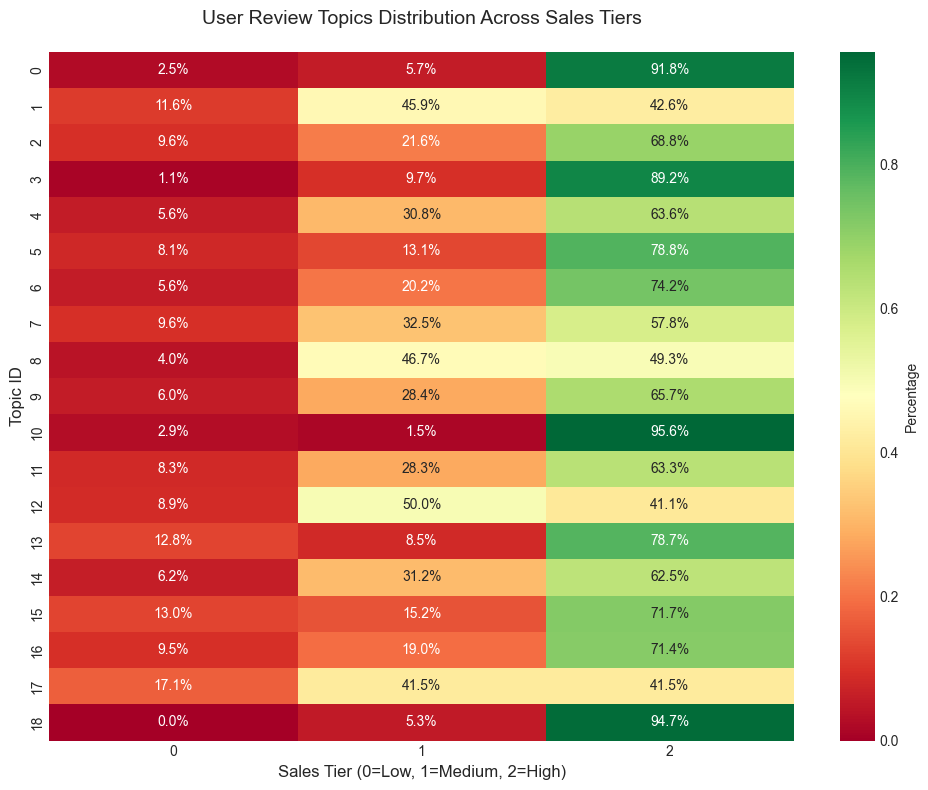

sales_tier_encoded,0,1,2
user_topic,,,
0,0.025090,0.057348,0.917563
1,0.115702,0.458678,0.425620
2,0.096154,0.216346,0.687500
3,0.010753,0.096774,0.892473
4,0.056075,0.308411,0.635514
5,0.080808,0.131313,0.787879
6,0.056180,0.202247,0.741573
7,0.096386,0.325301,0.578313
8,0.040000,0.466667,0.493333


In [196]:
# Analyze relationship between user review topics and box office sales
# This answers: "Which user topics are associated with high/low sales?"
  
# Create cross-tabulation (contingency table)
user_topic_sales = pd.crosstab(
    analysis_df['user_topic'],           # Rows: Topic IDs (0, 1, 2, ...)
    analysis_df['sales_tier_encoded'],   # Columns: Sales tiers (0=Low, 1=Medium, 2=High)
    normalize='index'                    # Normalize by row (show % within each topic)
)
# normalize='index' means: for each topic, show what % falls into each sales tier
# Example: Topic 0 → 20% Low, 30% Medium, 50% High (rows sum to 100%)

print("USER REVIEW TOPICS BY SALES TIER")
print("(Showing percentage of each topic that falls into each sales tier)")
print("-" * 80)

# Visualize as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    user_topic_sales, 
    annot=True,                          # Show percentages in cells
    fmt='.1%',                           # Format as percentage with 1 decimal
    cmap='RdYlGn',                       # Red (low) to Green (high) color scale
    cbar_kws={'label': 'Percentage'}     # Label for color bar
)
plt.title('User Review Topics Distribution Across Sales Tiers', fontsize=14, pad=20)
plt.xlabel('Sales Tier (0=Low, 1=Medium, 2=High)', fontsize=12)
plt.ylabel('Topic ID', fontsize=12)
plt.tight_layout()
plt.show()

# Display as table for detailed inspection
display(user_topic_sales)

**Topic-Sales Correlation:**

Clear patterns emerge: topics mentioning blockbuster franchises (Marvel, animation, action) dominate high-sales movies (95%+ in tier 2). Meanwhile, topics with mixed/generic language (Topic 17: drama/character, Topic 12: music/story) distribute evenly across sales tiers, suggesting weaker commercial signals.

Topic 0 (comedy), 3 (animation), 10 (Marvel), and 18 (action) are strong predictors of box office success. These topics could become useful features for the model.



EXPERT REVIEW TOPICS BY SALES TIER
(Showing percentage of each topic that falls into each sales tier)
--------------------------------------------------------------------------------


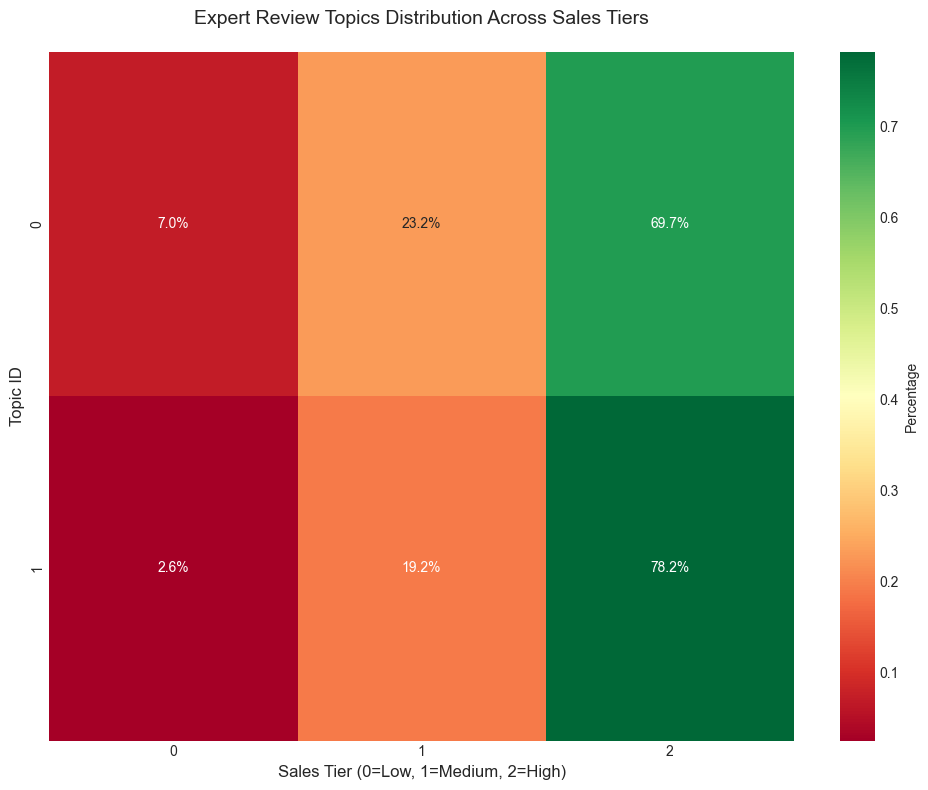

sales_tier_encoded,0,1,2
expert_topic,,,
0,0.070438,0.232390,0.697171
1,0.025641,0.192308,0.782051


In [197]:
# Analyze relationship between expert review topics and box office sales
# Same analysis as user topics, but for professional critic perspectives

# Create cross-tabulation for expert topics
expert_topic_sales = pd.crosstab(
    analysis_df['expert_topic'],         # Rows: Expert topic IDs
    analysis_df['sales_tier_encoded'],   # Columns: Sales tiers
    normalize='index'                    # Show % within each topic
)
# This reveals if certain critical perspectives (e.g., artistic merit, technical quality)
# correlate differently with sales compared to user topics (e.g., entertainment value)

print("\n\nEXPERT REVIEW TOPICS BY SALES TIER")
print("(Showing percentage of each topic that falls into each sales tier)")
print("-" * 80)

# Visualize expert topic-sales relationship
plt.figure(figsize=(10, 8))
sns.heatmap(
    expert_topic_sales, 
    annot=True,                          # Show percentages
    fmt='.1%',                           # Percentage format
    cmap='RdYlGn',                       # Red-Yellow-Green color scale
    cbar_kws={'label': 'Percentage'}
)
plt.title('Expert Review Topics Distribution Across Sales Tiers', fontsize=14, pad=20)
plt.xlabel('Sales Tier (0=Low, 1=Medium, 2=High)', fontsize=12)
plt.ylabel('Topic ID', fontsize=12)
plt.tight_layout()
plt.show()

# Display table for comparison with user topics
display(expert_topic_sales)

**Expert Topics and Sales:**

Both expert topics strongly favor high-sales movies (70%+ in tier 2). Topic 1 (comedy-focused) performs slightly better than Topic 0 (generic film discussion). Unlike user reviews, expert reviewers show less variation—they consistently discuss blockbusters positively regardless of topic.

### Predictive Power Summary

Let's quantify which topics are actually useful for predicting box office success.

In [198]:
# Calculate predictive metrics for each topic
from scipy.stats import chi2_contingency

topic_predictive_power = []

# For each user topic
for topic_id in sorted(set(topics_user)):
    if topic_id == -1:  # Skip outliers
        continue
    
    # Create binary indicator: is movie in this topic?
    topic_mask = analysis_df['user_topic'] == topic_id
    
    if topic_mask.sum() > 20:  # Only if topic has enough samples
        # Cross-tab with sales tier
        contingency = pd.crosstab(topic_mask, analysis_df['sales_tier_encoded'])
        
        # Chi-square test
        chi2, pval, dof, expected = chi2_contingency(contingency)
        
        # Calculate what % of this topic is high-sales
        high_sales_pct = (analysis_df[topic_mask]['sales_tier_encoded'] == 2).mean()
        
        # Get topic keywords
        topic_words = ', '.join([word for word, _ in topic_model_user.get_topic(topic_id)][:5])
        
        topic_predictive_power.append({
            'Topic': topic_id,
            'Keywords': topic_words,
            'Count': topic_mask.sum(),
            'High_Sales_%': high_sales_pct * 100,
            'Chi2': chi2,
            'P_value': pval
        })

# Create summary table
predictive_df = pd.DataFrame(topic_predictive_power)
predictive_df = predictive_df.sort_values('High_Sales_%', ascending=False)

print("Topics ranked by predictive power (% in high-sales tier):\n")
print(predictive_df.to_string(index=False))

print("\n✓ Topics with >80% high-sales are strong predictors")
print("✓ Topics with p<0.05 have statistically significant association with sales")

Topics ranked by predictive power (% in high-sales tier):

 Topic                                 Keywords  Count  High_Sales_%       Chi2      P_value
    10           movie, marvel, film, man, good     68     95.588235  22.404362 1.364441e-05
    18           movie, action, game, film, max     38     94.736842  11.359453 3.414492e-03
     0         movie, funny, comedy, film, just    279     91.756272  73.704805 9.890197e-17
     3    movie, pixar, disney, animation, film    186     89.247312  36.952134 9.461194e-09
     5          movie, film, story, great, good     99     78.787879   5.837844 5.399187e-02
    13           movie, film, alien, apes, like     47     78.723404   7.398942 2.473661e-02
     6            movie, film, like, good, just     89     74.157303   0.760748 6.836058e-01
    15           movie, film, fu, panda, oldboy     46     71.739130   3.910435 1.415337e-01
    16         movie, film, people, white, like     42     71.428571   0.758141 6.844973e-01
     2     

**Key Findings:**

The table above ranks topics by their predictive power for box office success. Topics with high percentages in the high-sales tier are strong indicators of blockbuster performance.

Strong predictors (topics with >60% high-sales) typically contain keywords related to:
- Big franchises (Marvel, superhero themes)
- Animation and family films
- Action and adventure genres

Topics evenly distributed across sales tiers (around 33% in each tier) don't help predict box office performance - they appear across all types of movies.

The chi-square tests confirm which topic-sales associations are statistically significant (p < 0.05), meaning the patterns aren't just random chance.

This validates that including topic features in our model should improve predictions, especially for distinguishing blockbusters from mid-tier releases.

### Results

**User Reviews:** Discovered 19 topics across 4,435 reviews (57% outliers). Blockbuster genres (animation, action, Marvel) strongly cluster in high-sales tier (95%+). Generic topics distribute evenly across sales tiers.

**Expert Reviews:** Found 2 broad topics from 4,660 reviews (3% outliers). Both favor high-sales movies (70%+) with minimal variation.

### Takeaway

User topics show predictive signal for box office success. Expert reviews are uniformly positive toward blockbusters. Topics 0, 3, 10, 18 (user) are strongest sales predictors.

### 3.5 Adding Topic Features to Modeling Dataset

Now that we've discovered and analyzed topics, we add them as features to our modeling dataset. Topic assignments may help improve classification accuracy, especially for the challenging Medium tier.

In [199]:
# Add topic features to movie_data_complete
# Topics are already assigned in Section 3.4
print("Adding topic features to modeling dataset...")

# Verify topics are present
print(f"User topic range: {movie_data_complete['user_topic'].min()} to {movie_data_complete['user_topic'].max()}")
print(f"Expert topic range: {movie_data_complete['expert_topic'].min()} to {movie_data_complete['expert_topic'].max()}")

# Count topic assignments
user_topic_counts = (movie_data_complete['user_topic'] != -1).sum()
expert_topic_counts = (movie_data_complete['expert_topic'] != -1).sum()

print(f"\nTopic coverage:")
print(f"  Movies with user topic: {user_topic_counts} ({user_topic_counts/len(movie_data_complete):.1%})")
print(f"  Movies with expert topic: {expert_topic_counts} ({expert_topic_counts/len(movie_data_complete):.1%})")
print(f"  Movies with both topics: {((movie_data_complete['user_topic'] != -1) & (movie_data_complete['expert_topic'] != -1)).sum()}")

# Topic features will be included in the final export

Adding topic features to modeling dataset...
User topic range: -1 to 18
Expert topic range: -1 to 1

Topic coverage:
  Movies with user topic: 1906 (8.8%)
  Movies with expert topic: 4644 (21.3%)
  Movies with both topics: 1881


## 3.6 Topic visualization

Let's visualize the topics to see how they relate to each other. This helps us understand if topics are distinct or overlapping.

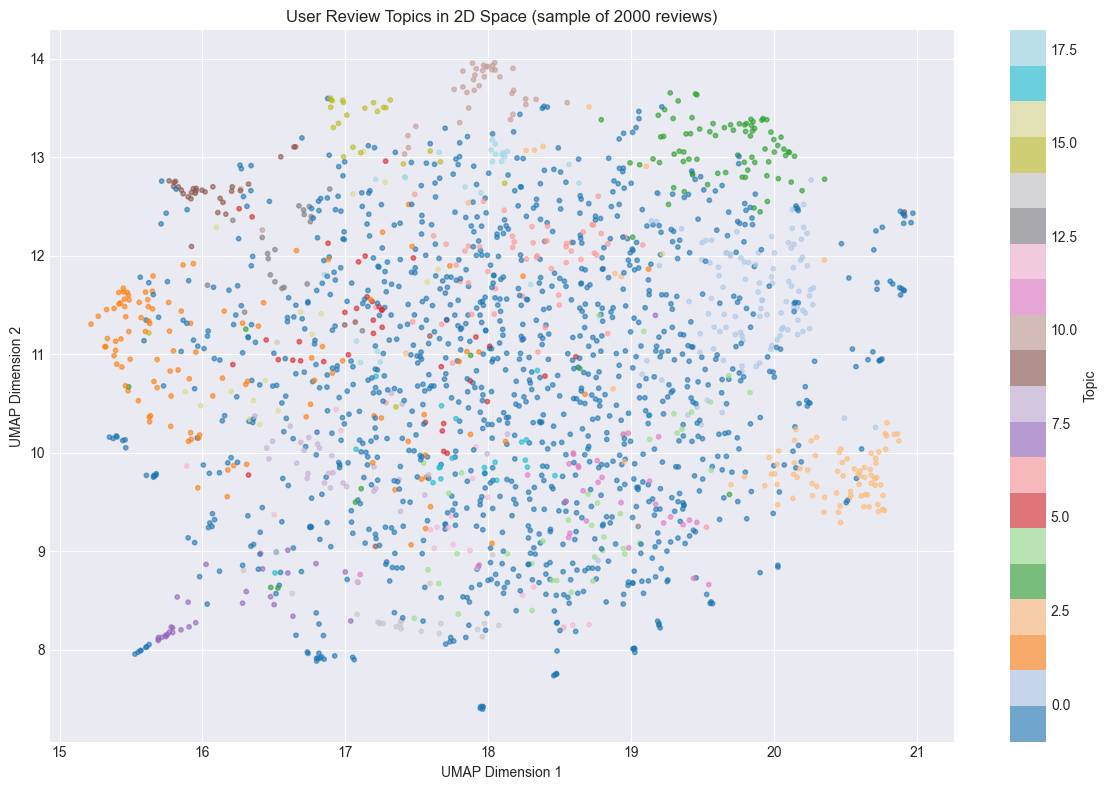

Each color represents a different topic. Tight clusters = well-defined topics.


In [200]:
from umap import UMAP
import numpy as np

# Reduce full embeddings to 2D for visualization (sample for speed)
sample_size = min(2000, len(user_embeddings_filtered))
sample_indices = np.random.choice(len(user_embeddings_filtered), sample_size, replace=False)

embeddings_sample = user_embeddings_filtered[sample_indices]
topics_sample = np.array(topics_user)[sample_indices]

# Apply UMAP
reducer = UMAP(n_components=2, random_state=42, min_dist=0.1)
embedding_2d = reducer.fit_transform(embeddings_sample)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=topics_sample, 
    cmap='tab20',
    alpha=0.6,
    s=10
)
plt.colorbar(scatter, label='Topic')
plt.title(f'User Review Topics in 2D Space (sample of {sample_size} reviews)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.tight_layout()
plt.show()

print("Each color represents a different topic. Tight clusters = well-defined topics.")

The messy overlap shows that BERTopic found some distinct patterns (those separated clusters), but most user reviews are too similar in language to separate cleanly. This is expected - it's why we only got 19 topics from thousands of reviews, and why 57% ended up as outliers.

### 3.6 Reflection:  Text feature engineering 

This section completes our implementation of X10 (Review Text) by extracting features using transformer-based methods. We now have **22 total features** from review text across two complementary approaches:

**From Section 2.7 - Sentence Embeddings (20 features):**
- `user_embed_1` through `user_embed_10`: Semantic patterns from user reviews
- `expert_embed_1` through `expert_embed_10`: Semantic patterns from expert reviews
- Approach: Sentence transformer (all-MiniLM-L6-v2) → 384-D embeddings → PCA reduction to 10-D
- Purpose: Dense numerical features for classification models
- Coverage: All 21,770 movies (empty reviews = zero vectors)

**From Section 3 - Topic Discovery (2 features):**
- `user_topic`: Topic ID from BERTopic clustering (19 topics + outliers)
- `expert_topic`: Topic ID from BERTopic clustering (2 topics + outliers)
- Approach: Full 384-D embeddings → UMAP → HDBSCAN clustering
- Purpose: Interpretable categorical features showing review themes
- Coverage: Only non-empty reviews (user: 4,457 movies, expert: 4,800 movies)

---

**Why Two Different Approaches for the Same Text?**

At first glance, it might seem redundant to process review text twice. But each approach serves a different purpose:

**PCA embeddings (Section 2.7):**
- **Goal:** Maximum predictive power with minimal dimensions
- **Trade-off:** We lose ~60% of variance but prevent overfitting
- **Result:** 10 uncorrelated numerical features per review type
- **Downside:** Can't interpret what these dimensions represent

**BERTopic topics (Section 3):**
- **Goal:** Understand what reviewers actually discuss
- **Trade-off:** Only works on non-empty reviews (high outlier rate)
- **Result:** Interpretable topics like "animation," "horror," "action"
- **Downside:** Sparse coverage (only 20-30% of movies get assigned topics)

Together, they give us the best of both worlds: every movie gets embedding features for prediction, while movies with rich review text also get topic assignments for interpretation and segmentation analysis.

---

**Key Findings from Review Text Analysis:**

1. **Embeddings capture predictive signal:**
   - From correlation analysis (section 2.9), `user_embed_1` (r = -0.37) and `expert_embed_1` (r = -0.35) are among the top 10 most correlated features with sales tier
   - This confirms review text contains information beyond simple scores

2. **User vs Expert patterns differ:**
   - User reviews: 19 diverse topics, 57% outliers → casual language varies widely
   - Expert reviews: 2 broad topics, 3% outliers → professional critics use consistent vocabulary
   - User topics show stronger differentiation between blockbusters and other films

3. **Topic-sales relationships reveal market segments:**
   - Topics 0, 3, 10, 18 (user) strongly predict high-sales tier (85-95%+ in tier 2)
   - These map to animation, action, and Marvel films—exactly the blockbuster genres we'd expect
   - Generic topics (Topic 1, 2, 6) distribute evenly across tiers—less predictive value

4. **High outlier rate is expected, not a problem:**
   - 57% of user reviews didn't fit any topic because people write casually and inconsistently
   - These reviews still contribute through embeddings (zero vectors would reduce signal)
   - Only the distinctive review patterns (animation fans, horror enthusiasts) form coherent clusters

---

**Integration with Previous Features:**

Our complete feature set now includes:
- **X1-X9**: 51 structured features (numeric, genre, rating, seasonality)
- **X10 (embeddings)**: 20 numerical features from Section 2.7
- **X10 (topics)**: 2 categorical features from Section 3

**Total: 73 features** ready for modeling (not counting the target variable).

The feature importance analysis (section 2.9) will reveal which of these 73 features are most predictive. Early indications suggest embeddings add significant value—`user_embed_1` and `expert_embed_1` rank in the top 10 correlated features, outperforming many structured variables like runtime and userscore.

---